# Phase 1-1: Member County Activity

* Purpose: This file attempts to aggregate member's account data based on their counties and classify them into distinct activity groups.

## Importing Packages and Data

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler # MinMaxScaler affected by outliers
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
member_level_df = pd.read_csv('data/Member_Level_Dataset.csv')
member_level_df.head()

Unique_Member_Identifier EOM_TRANS_DATE  age  \
0  360faa7e8e345d2725f92460ca39696ad885b876805328...     2022-01-31   85   
1  4ef271022b929dd2ea56f3c0e9a7efae346a07e40f6ea1...     2022-01-31   59   
2  f868c8fb32d526c00024e408fdd712e881de936372bef8...     2022-01-31   38   
3  4fe6ec028a8a5234bb02fbe97488fb9431109a292ee8bc...     2022-01-31   67   
4  f46df5083939ce116be51669af3315c474655c936204c2...     2022-01-31   47   

  BranchCategory address_zip  n_accts  n_checking_accts  n_savings_accts  \
0  Winter Garden       34760        1                 0                1   
1      Lake Nona       34771        2                 1                1   
2      MetroWest       32765        2                 0                1   
3      Kissimmee       34744        1                 0                1   
4   East Orlando       32825        3                 2                1   

   n_open_loans  n_open_cds  ...  ATMCount  BillPaymentCount  CashCount  \
0             0           0  ...         0                 0          0   
1             0           0  ...         0                 0          0   
2             0           0  ...         0                 0          0   
3             1           0  ...         0                 0          0   
4             0           0  ...         0                 0          0   

   DraftCount  ACHCount  FeeCount  Credit_DebitCount  Home_Banking  WireCount  \
0           0         0         0                  0             0          0   
1           0         0         0                  0             0          0   
2           0         0         0                  0             0          0   
3           0         0         0                  0             0          0   
4           0         0         1                  2             2          0   

   DividendCount  
0              1  
1              1  
2              1  
3              1  
4              1  

[5 rows x 22 columns]

In [3]:
# Map BranchCategory to County
city_to_county_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}


## Data Preprocessing

In [4]:
# Remove member identifiers
member_level_df = member_level_df.drop(columns=['Unique_Member_Identifier'])

In [5]:
# Remove the rows that contains 'Virtual Branch' in the 'BranchCategory' column
no_virtual_df = member_level_df[member_level_df['BranchCategory'] != 'Virtual Branch']

In [6]:
# Remove the rows that contains 'High School' in the name in 'BranchCategory' column
no_highschool_df = no_virtual_df[~member_level_df['BranchCategory'].str.contains('High School')]

C:\Users\perez\AppData\Local\Temp\ipykernel_14192\2725168190.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_highschool_df = no_virtual_df[~member_level_df['BranchCategory'].str.contains('High School')]


In [7]:
# Drop empty rows
no_highschool_df = no_highschool_df.dropna()

In [8]:
# numerical columns
numerical_df = no_highschool_df.select_dtypes(include=['int64', 'float64'])

vif_data = pd.DataFrame()
vif_data["Variable"] = numerical_df.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_df.values, i) for i in range(numerical_df.shape[1])]
print(vif_data)

c:\Users\perez\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


               Variable       VIF
0                   age  4.469401
1               n_accts       inf
2      n_checking_accts       inf
3       n_savings_accts       inf
4          n_open_loans  1.956129
5            n_open_cds       inf
6     n_open_club_accts       inf
7   n_open_credit_cards  1.823530
8              ATMCount  1.087761
9      BillPaymentCount  1.066652
10            CashCount  1.018235
11           DraftCount  1.165459
12             ACHCount  1.226394
13             FeeCount  1.232675
14    Credit_DebitCount  1.267735
15         Home_Banking  1.089248
16            WireCount  1.003263
17        DividendCount  4.249345


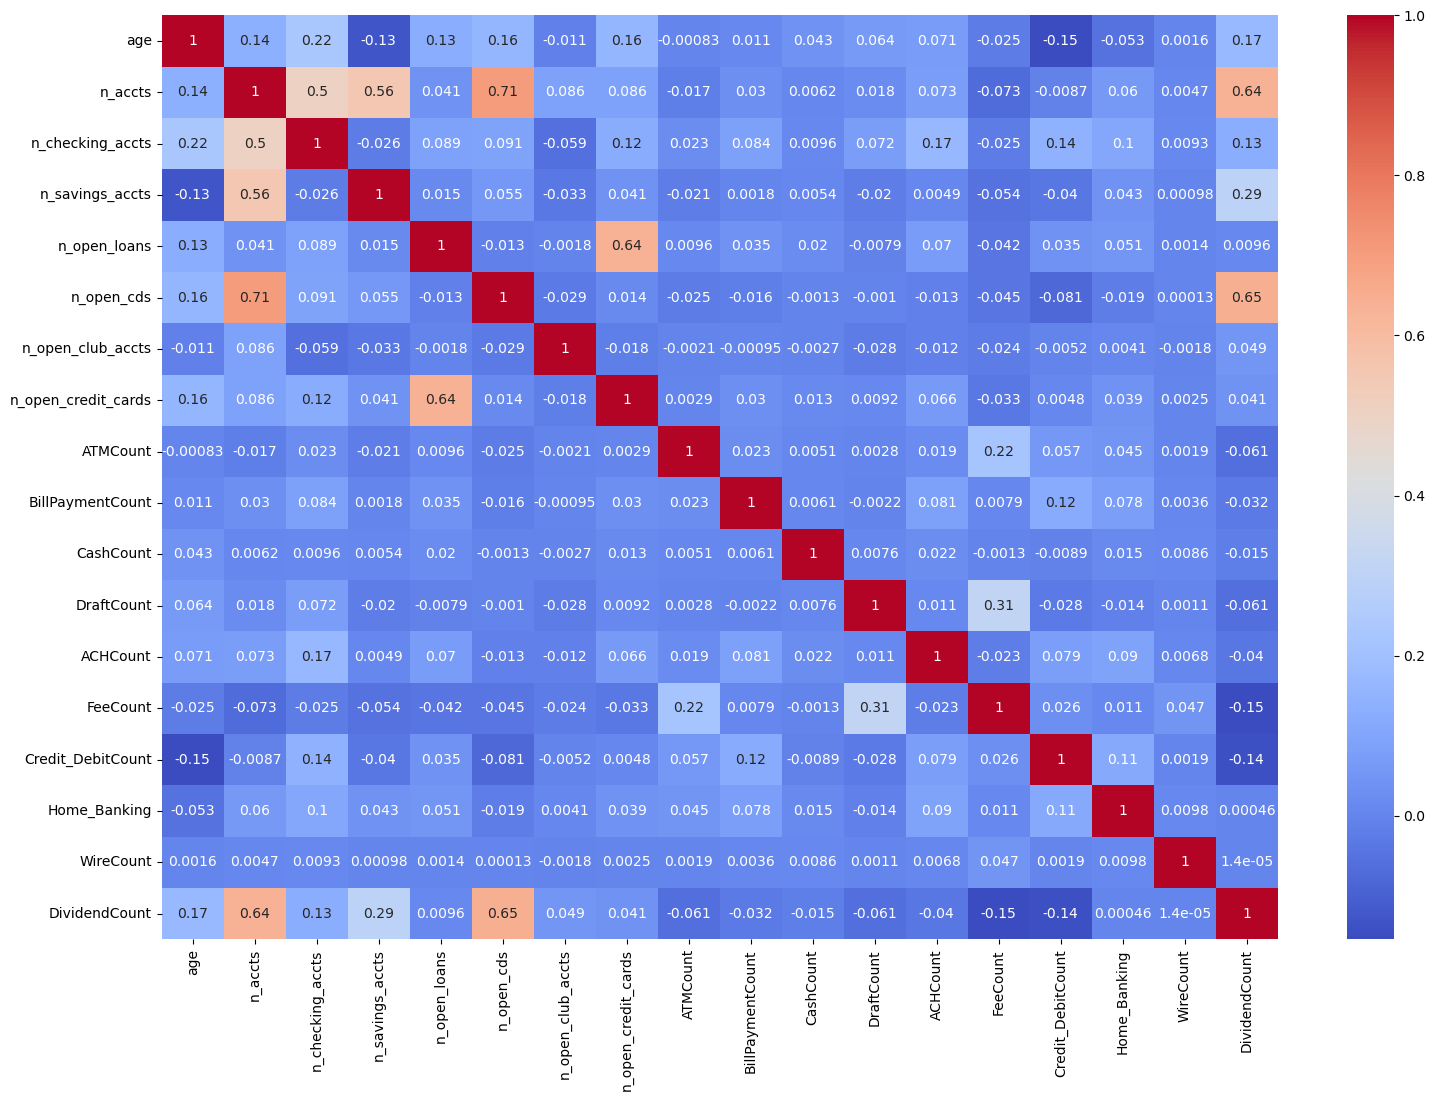

In [9]:
# Plot correlation matrix
corr = numerical_df.corr()
plt.figure(figsize=(18, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [10]:
# Displays the number of unique values for each column
numerical_df.nunique().sort_values(ascending=False)

age                    109
DividendCount           46
Credit_DebitCount       40
Home_Banking            40
ACHCount                34
n_accts                 29
n_open_cds              27
BillPaymentCount        24
FeeCount                17
n_savings_accts         15
DraftCount              13
ATMCount                12
CashCount                9
n_checking_accts         8
n_open_loans             5
WireCount                4
n_open_club_accts        3
n_open_credit_cards      2
dtype: int64

In [11]:
county_df = no_highschool_df.copy()

county_df['County'] = county_df['BranchCategory'].map(city_to_county_mapping)

# Load revenue data
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only 'County' and 'TOTAL - All Revenue Account Codes' columns
df_revenue = df_revenue.iloc[:, [0, -3]]
df_revenue.columns = ['County', 'Revenue_Per_County']
df_revenue = df_revenue.drop(0)

# Merging the DataFrames
county_df = pd.merge(county_df, df_revenue, on='County', how='left')

# Displaying the combined DataFrame
county_df.head()

EOM_TRANS_DATE  age BranchCategory address_zip  n_accts  n_checking_accts  \
0     2022-01-31   85  Winter Garden       34760        1                 0   
1     2022-01-31   59      Lake Nona       34771        2                 1   
2     2022-01-31   38      MetroWest       32765        2                 0   
3     2022-01-31   67      Kissimmee       34744        1                 0   
4     2022-01-31   47   East Orlando       32825        3                 2   

   n_savings_accts  n_open_loans  n_open_cds  n_open_club_accts  ...  \
0                1             0           0                  0  ...   
1                1             0           0                  0  ...   
2                1             0           0                  1  ...   
3                1             1           0                  0  ...   
4                1             0           0                  0  ...   

   CashCount  DraftCount  ACHCount  FeeCount  Credit_DebitCount  Home_Banking  \
0          0           0         0         0                  0             0   
1          0           0         0         0                  0             0   
2          0           0         0         0                  0             0   
3          0           0         0         0                  0             0   
4          0           0         0         1                  2             2   

   WireCount  DividendCount   County  Revenue_Per_County  
0          0              1   Orange          6968835122  
1          0              1   Orange          6968835122  
2          0              1   Orange          6968835122  
3          0              1  Osceola          1592120547  
4          0              1   Orange          6968835122  

[5 rows x 23 columns]

In [12]:
# Assuming 'BranchCategory' uniquely identifies each branch
branch_count = county_df.groupby('County')['BranchCategory'].nunique()
branch_count.name = 'Branch_Count'

# Aggregate the member activity data by the 'County' column, summing up all the activity-related columns
county_activity_agg = county_df.groupby('County').agg({
    'DividendCount': 'sum',
    'Home_Banking': 'sum',
    'Credit_DebitCount': 'sum',
    'ACHCount': 'sum',
    'n_accts': 'sum',
    'n_open_cds': 'sum',
    'BillPaymentCount': 'sum',
    'FeeCount': 'sum',
    'n_savings_accts': 'sum',
    'DraftCount': 'sum',
    'ATMCount': 'sum',
    'CashCount': 'sum',
    'n_checking_accts': 'sum',
    'n_open_loans': 'sum',
    'WireCount': 'sum',
    'n_open_club_accts': 'sum',
    'n_open_credit_cards': 'sum'
}).reset_index()

# Calculate the total Activity per county
county_activity_agg['Total_Activity'] = county_activity_agg.drop('County', axis=1).sum(axis=1)

# Calculate the average Activity per branch for each county
county_activity_agg = county_activity_agg.merge(branch_count.reset_index(), on='County')
county_activity_agg['Average_Activity_Per_Branch'] = county_activity_agg['Total_Activity'] / county_activity_agg['Branch_Count']

# Display the DataFrame with total and average Activity
county_activity_agg[['County', 'Total_Activity', 'Branch_Count', 'Average_Activity_Per_Branch']]

County  Total_Activity  Branch_Count  Average_Activity_Per_Branch
0   Brevard           94796             1                 94796.000000
1      Lake         1110490             3                370163.333333
2    Orange         5820144            10                582014.400000
3   Osceola         2087538             3                695846.000000
4      Polk          264614             1                264614.000000
5  Seminole         2510613             7                358659.000000
6   Volusia          305654             1                305654.000000

     County  Total_Activity  Branch_Count  Average_Activity_Per_Branch
3   Osceola         2087538             3                695846.000000
2    Orange         5820144            10                582014.400000
1      Lake         1110490             3                370163.333333
5  Seminole         2510613             7                358659.000000
6   Volusia          305654             1                305654.000000
4      Polk          264614             1                264614.000000
0   Brevard           94796             1                 94796.000000


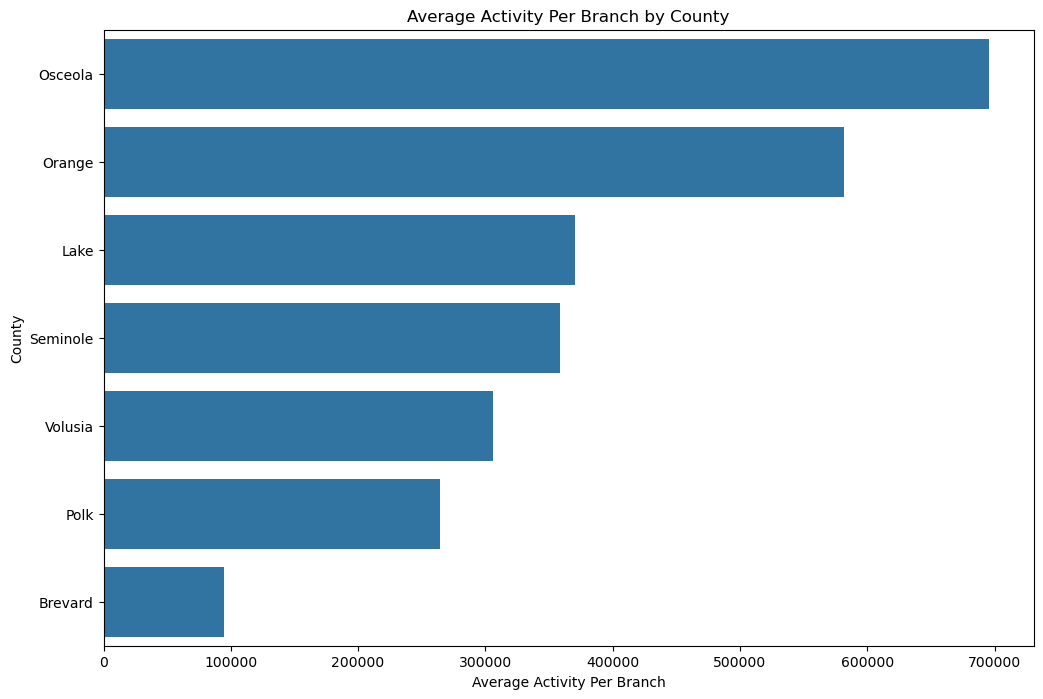

In [13]:
# Sorting counties by the average transactions per branch
county_activity_agg_sorted = county_activity_agg.sort_values(by='Average_Activity_Per_Branch', ascending=False)

# Displaying the counties with their average transaction data per branch
print(county_activity_agg_sorted[['County', 'Total_Activity', 'Branch_Count', 'Average_Activity_Per_Branch']])

# Visualization - Average Activity per Branch by County
plt.figure(figsize=(12, 8))
sns.barplot(y=county_activity_agg_sorted['County'], x=county_activity_agg_sorted['Average_Activity_Per_Branch'], )
plt.title('Average Activity Per Branch by County')
plt.ylabel('County')
plt.xlabel('Average Activity Per Branch')
plt.show()

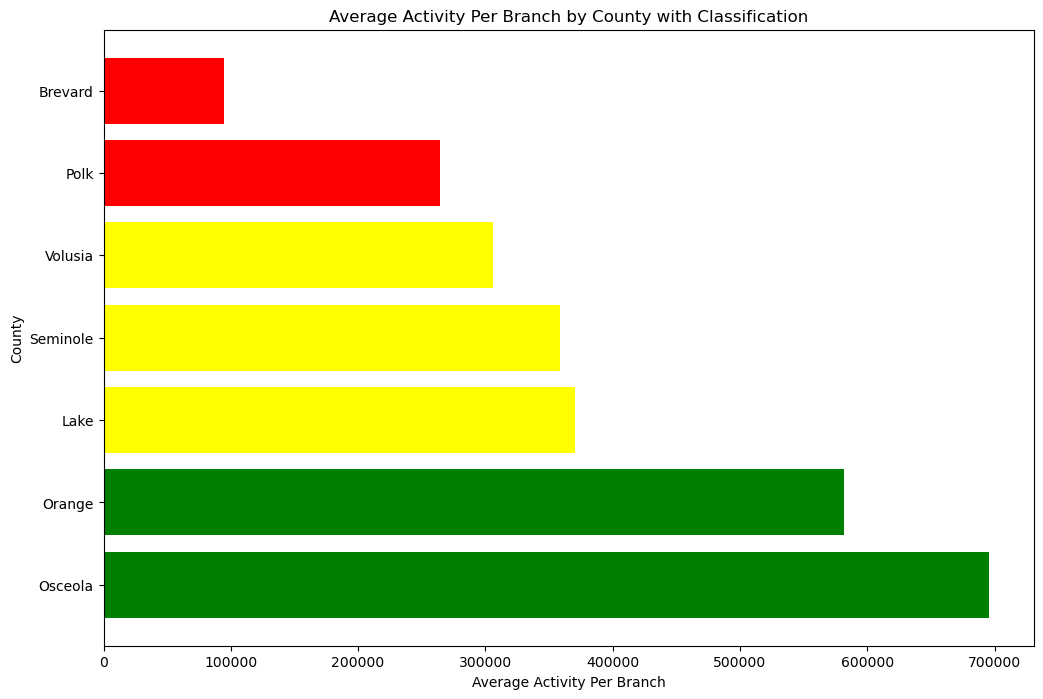

In [14]:
# Define classification thresholds
high_threshold = county_activity_agg_sorted['Average_Activity_Per_Branch'].quantile(0.75) # top 25%
medium_threshold = county_activity_agg_sorted['Average_Activity_Per_Branch'].quantile(0.25) # bottom 25%

# Classify counties
county_activity_agg_sorted['Classification'] = 'Low'
county_activity_agg_sorted.loc[county_activity_agg_sorted['Average_Activity_Per_Branch'] >= medium_threshold, 'Classification'] = 'Medium'
county_activity_agg_sorted.loc[county_activity_agg_sorted['Average_Activity_Per_Branch'] >= high_threshold, 'Classification'] = 'High'

# Visualize the classified data
colors = {'Low': 'red', 'Medium': 'yellow', 'High': 'green'}
plt.figure(figsize=(12, 8))
plt.barh(county_activity_agg_sorted['County'], county_activity_agg_sorted['Average_Activity_Per_Branch'], color=[colors[cls] for cls in county_activity_agg_sorted['Classification']])
plt.title('Average Activity Per Branch by County with Classification')
plt.xlabel('Average Activity Per Branch')
plt.ylabel('County')
plt.show()


# Phase 1-2: Member County PCA

*   Purpose: This file attempts to view if any pattern emerged from PCA analysis and county groupings

## Data Preprocessing

In [15]:
# Remove the rows that contains 'Virtual Branch' in the 'BranchCategory' column
no_virtual_df = member_level_df[member_level_df['BranchCategory'] != 'Virtual Branch']

In [16]:
# Remove the rows that contains 'High School' in the name in 'BranchCategory' column
no_highschool_df = no_virtual_df[~member_level_df['BranchCategory'].str.contains('High School')]

C:\Users\perez\AppData\Local\Temp\ipykernel_14192\2725168190.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_highschool_df = no_virtual_df[~member_level_df['BranchCategory'].str.contains('High School')]


In [17]:
# Drop empty rows
no_highschool_df = no_highschool_df.dropna()

In [18]:
# Mapping dictionary with proper case
city_to_county_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}

county_df = no_highschool_df.copy()

# Add a 'County' column based on the 'BranchCategory' column
county_df['County'] = county_df['BranchCategory'].map(city_to_county_mapping)

# Identify any rows where the county couldn't be mapped
unmapped_rows = county_df[county_df['County'].isnull()]
print(unmapped_rows)

Empty DataFrame
Columns: [EOM_TRANS_DATE, age, BranchCategory, address_zip, n_accts, n_checking_accts, n_savings_accts, n_open_loans, n_open_cds, n_open_club_accts, n_open_credit_cards, ATMCount, BillPaymentCount, CashCount, DraftCount, ACHCount, FeeCount, Credit_DebitCount, Home_Banking, WireCount, DividendCount, County]
Index: []

[0 rows x 22 columns]


Attempting to cluster the different counties and view what pattern emerges.

In [19]:
# Drop unnecessary columns
data_for_clustering = county_df.drop(['EOM_TRANS_DATE', 'BranchCategory', 'address_zip', 'County'], axis=1)
data_for_clustering.head()

age  n_accts  n_checking_accts  n_savings_accts  n_open_loans  n_open_cds  \
0   85        1                 0                1             0           0   
1   59        2                 1                1             0           0   
2   38        2                 0                1             0           0   
3   67        1                 0                1             1           0   
4   47        3                 2                1             0           0   

   n_open_club_accts  n_open_credit_cards  ATMCount  BillPaymentCount  \
0                  0                    0         0                 0   
1                  0                    0         0                 0   
2                  1                    0         0                 0   
3                  0                    0         0                 0   
4                  0                    0         0                 0   

   CashCount  DraftCount  ACHCount  FeeCount  Credit_DebitCount  Home_Banking  \
0          0           0         0         0                  0             0   
1          0           0         0         0                  0             0   
2          0           0         0         0                  0             0   
3          0           0         0         0                  0             0   
4          0           0         0         1                  2             2   

   WireCount  DividendCount  
0          0              1  
1          0              1  
2          0              1  
3          0              1  
4          0              1

In [20]:
scaler = StandardScaler()
normalized_df = scaler.fit_transform(data_for_clustering)
normalized_df = pd.DataFrame(normalized_df, columns=data_for_clustering.columns)
# normalized_df.columns = [col + '_norm' for col in normalized_df.columns]
normalized_df.index = data_for_clustering.index
normalized_df.head()

age   n_accts  n_checking_accts  n_savings_accts  n_open_loans  \
0  1.727636 -1.153673         -1.515371        -0.454164     -0.396081   
1  0.453627 -0.396488          0.097839        -0.454164     -0.396081   
2 -0.575380 -0.396488         -1.515371        -0.454164     -0.396081   
3  0.845630 -1.153673         -1.515371        -0.454164      1.843818   
4 -0.134377  0.360698          1.711049        -0.454164     -0.396081   

   n_open_cds  n_open_club_accts  n_open_credit_cards  ATMCount  \
0   -0.261204          -0.205127            -0.275022 -0.157307   
1   -0.261204          -0.205127            -0.275022 -0.157307   
2   -0.261204           4.843145            -0.275022 -0.157307   
3   -0.261204          -0.205127            -0.275022 -0.157307   
4   -0.261204          -0.205127            -0.275022 -0.157307   

   BillPaymentCount  CashCount  DraftCount  ACHCount  FeeCount  \
0         -0.194599  -0.119586    -0.17688 -0.405615 -0.193520   
1         -0.194599  -0.119586    -0.17688 -0.405615 -0.193520   
2         -0.194599  -0.119586    -0.17688 -0.405615 -0.193520   
3         -0.194599  -0.119586    -0.17688 -0.405615 -0.193520   
4         -0.194599  -0.119586    -0.17688 -0.405615  3.740215   

   Credit_DebitCount  Home_Banking  WireCount  DividendCount  
0          -0.438801     -0.219496  -0.018926      -0.046666  
1          -0.438801     -0.219496  -0.018926      -0.046666  
2          -0.438801     -0.219496  -0.018926      -0.046666  
3          -0.438801     -0.219496  -0.018926      -0.046666  
4           1.375045      2.763451  -0.018926      -0.046666

## PCA Analysis

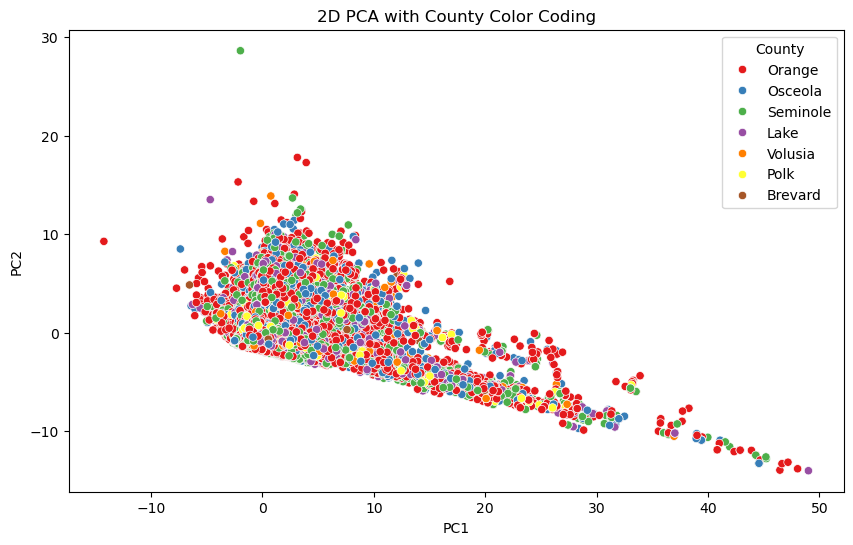

In [21]:
# Apply 2D PCA
pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(normalized_df)

# Create a DataFrame for 2D PCA results
pca_df_2d = pd.DataFrame(data=pca_result_2d, columns=['PC1', 'PC2'])
pca_df_2d['County'] = county_df['County']

# Plot 2D PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='County', data=pca_df_2d, palette='Set1')
plt.title('2D PCA with County Color Coding')
plt.show()

In [22]:
# Get the feature loadings for PC1 and PC2
loadings_df = pd.DataFrame(pca_2d.components_, columns=normalized_df.columns, index=['PC1', 'PC2'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

Feature Loadings for PC1:
n_accts                0.569519
DividendCount          0.488589
n_open_cds             0.462143
n_savings_accts        0.275162
n_checking_accts       0.263200
age                    0.177430
n_open_credit_cards    0.125224
n_open_loans           0.093369
ACHCount               0.052811
Home_Banking           0.035481
n_open_club_accts      0.019655
BillPaymentCount       0.013841
CashCount              0.007266
WireCount              0.000820
DraftCount            -0.015738
ATMCount              -0.043514
Credit_DebitCount     -0.061830
FeeCount              -0.108820
Name: PC1, dtype: float64

Feature Loadings for PC2:
n_open_loans           0.570353
n_open_credit_cards    0.565873
n_checking_accts       0.268639
ACHCount               0.237639
age                    0.216634
Credit_DebitCount      0.169423
BillPaymentCount       0.157979
Home_Banking           0.153834
ATMCount               0.088112
DraftCount             0.076528
CashCount              0.

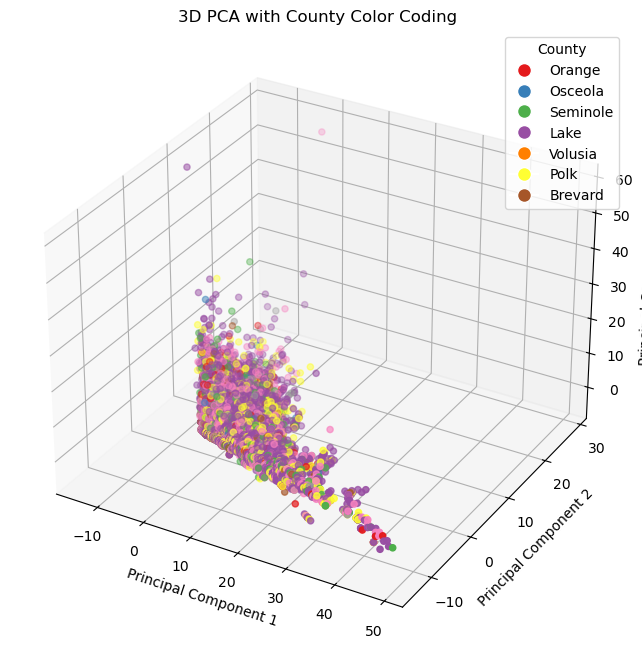

In [23]:
# Apply 3D PCA
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(normalized_df)

# Create a DataFrame for 3D PCA results
pca_df_3d = pd.DataFrame(data=pca_result_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['County'] = county_df['County']

# Plot 3D PCA
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter_3d = ax.scatter(pca_df_3d['PC1'], pca_df_3d['PC2'], pca_df_3d['PC3'], c=pca_df_3d['County'].astype('category').cat.codes, cmap='Set1')

# Create a legend
legend_labels = county_df['County'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sns.color_palette('Set1')[i], markersize=10, label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, title='County', loc='upper right')

ax.set_title('3D PCA with County Color Coding')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

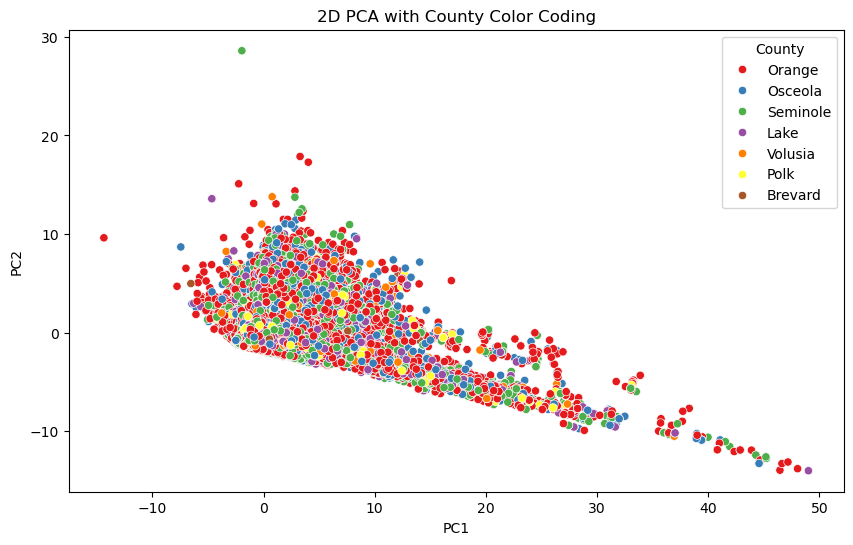

In [24]:
# Plot 2D PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='County', data=pca_df_3d, palette='Set1')
plt.title('2D PCA with County Color Coding')
plt.show()

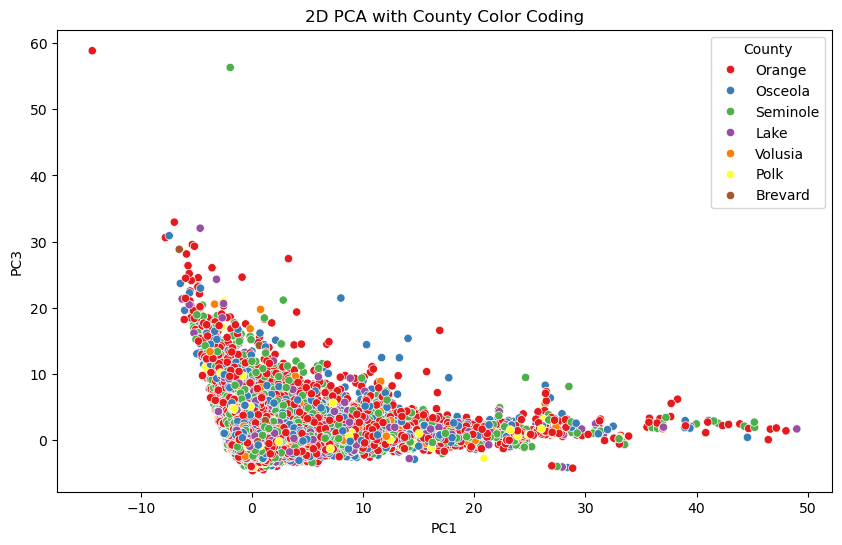

In [25]:
# Plot 2D PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC3', hue='County', data=pca_df_3d, palette='Set1')
plt.title('2D PCA with County Color Coding')
plt.show()

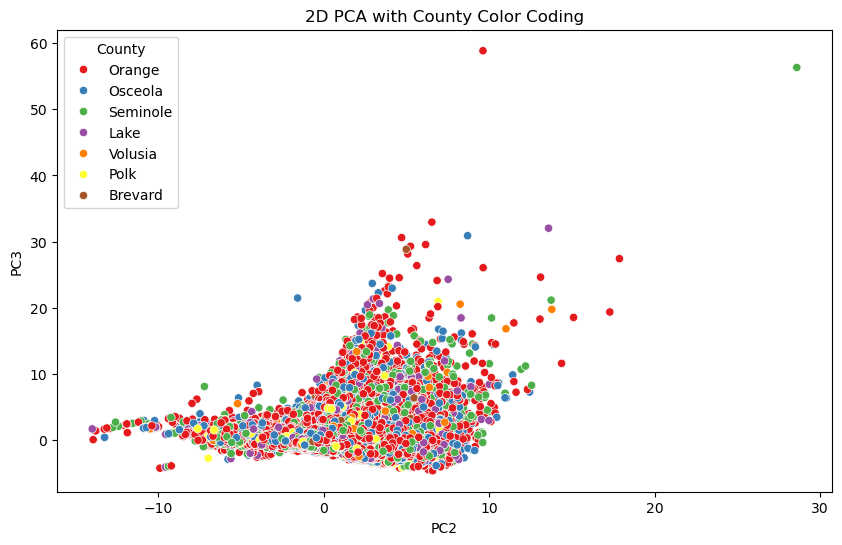

In [26]:
# Plot 2D PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC2', y='PC3', hue='County', data=pca_df_3d, palette='Set1')
plt.title('2D PCA with County Color Coding')
plt.show()

In [27]:
# Get the feature loadings for PC1, PC2, and PC3
loadings_df = pd.DataFrame(pca_3d.components_, columns=normalized_df.columns, index=['PC1', 'PC2', 'PC3'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

print("\nFeature Loadings for PC3:")
print(loadings_df.loc['PC3'].sort_values(ascending=False))

Feature Loadings for PC1:
n_accts                0.569411
DividendCount          0.488692
n_open_cds             0.462171
n_savings_accts        0.275168
n_checking_accts       0.263101
age                    0.177349
n_open_credit_cards    0.125277
n_open_loans           0.093386
ACHCount               0.052611
Home_Banking           0.035940
n_open_club_accts      0.019105
BillPaymentCount       0.013948
CashCount              0.007092
WireCount              0.001124
DraftCount            -0.015778
ATMCount              -0.043137
Credit_DebitCount     -0.062277
FeeCount              -0.109013
Name: PC1, dtype: float64

Feature Loadings for PC2:
n_open_loans           0.571016
n_open_credit_cards    0.566032
n_checking_accts       0.268087
ACHCount               0.240893
age                    0.214391
Credit_DebitCount      0.168016
BillPaymentCount       0.157520
Home_Banking           0.154335
ATMCount               0.087995
DraftCount             0.075508
CashCount              0.

# Phase 1-3: Branch County PCA

*	EDA: Explore multicollinearity using variance inflation factors, pinpoint heteroscedasticity, and delineate variable relationships.

## Import Packages and Data

In [28]:
branch_level_data = pd.read_csv('data/Branch_Level_Dataset.csv')
branch_level_data.head(5)

EOM_TRANS_DATE            BranchCategory  ATM  Bill Payment  Cash  Draft  \
0     2022-01-31  Addition Financial Arena    0             3     0     28   
1     2022-01-31         Altamonte Springs   98           394    64    469   
2     2022-01-31                    Apopka  198           540   132    705   
3     2022-01-31         Boone High School    1            10     2      8   
4     2022-01-31                  Clermont  143           482   103    499   

    ACH  Fee  Credit/Debit Card  Home Banking  Dividend  
0     5   20                  6             4        14  
1  1589  416               1642           646      3650  
2  2219  560               1983           724      5731  
3    30    9                 80            21        59  
4  1940  539               1834           580      4551

In [29]:
# print unique values for BranchCategory and their counts
print(branch_level_data['BranchCategory'].value_counts())

BranchCategory
MetroWest                    19
Sanford                      19
Oak Ridge High School        19
Ocoee High School            19
Orange City                  19
Oviedo                       19
Pine Hills                   19
Poinciana                    19
Poinciana High School        19
Seminole State               19
Altamonte Springs            19
South Orlando                19
St. Cloud                    19
St. Cloud High School        19
The Loop                     19
Timber Creek High School     19
UCF Campus                   19
Virtual Branch               19
Mills                        19
Winter Garden                19
Merritt Island               19
Longwood                     19
Apopka                       19
Boone High School            19
Clermont                     19
Colonial High School         19
Downtown Campus              19
East Orlando                 19
Edgewater High School        19
Eustis                       19
Fern Park                

## Data Preprocessing

In [30]:
# Remove rows where BranchCategory is 'High School' or 'Virtual Branch'
branch_level_data = branch_level_data[~branch_level_data['BranchCategory'].str.contains("High School|Virtual Branch")]

# Check for null values in the DataFrame
null_values = branch_level_data.isnull().sum()

# Displaying the DataFrame and the null values information
print(branch_level_data.head())
print(null_values)


  EOM_TRANS_DATE            BranchCategory  ATM  Bill Payment  Cash  Draft  \
0     2022-01-31  Addition Financial Arena    0             3     0     28   
1     2022-01-31         Altamonte Springs   98           394    64    469   
2     2022-01-31                    Apopka  198           540   132    705   
4     2022-01-31                  Clermont  143           482   103    499   
6     2022-01-31           Downtown Campus   27            35    12     62   

    ACH  Fee  Credit/Debit Card  Home Banking  Dividend  
0     5   20                  6             4        14  
1  1589  416               1642           646      3650  
2  2219  560               1983           724      5731  
4  1940  539               1834           580      4551  
6   134   78                227            47       275  
EOM_TRANS_DATE       0
BranchCategory       0
ATM                  0
Bill Payment         0
Cash                 0
Draft                0
ACH                  0
Fee                  0

In [31]:
# Load the Excel file
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only the 'County' and 'TOTAL - All Revenue Account Codes' columns
# Assuming these are the first and the third-last columns in your DataFrame
df_revenue = df_revenue.iloc[:, [0, -3]]

# Renaming the columns for clarity
df_revenue.columns = ['County', 'Revenue_Per_County']

# Dropping the first row if it contains headers from the original table
df_revenue = df_revenue.drop(0)

# Displaying the modified DataFrame
print(df_revenue.head())



     County Revenue_Per_County
1   Alachua         1082349199
2     Baker           89157684
3       Bay         1193216378
4  Bradford           85933027
5   Brevard          958971976


In [32]:
# Map BranchCategory to County
city_to_county_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}

branch_level_data['County'] = branch_level_data['BranchCategory'].map(city_to_county_mapping)

# Load revenue data
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only 'County' and 'TOTAL - All Revenue Account Codes' columns
df_revenue = df_revenue.iloc[:, [0, -3]]
df_revenue.columns = ['County', 'Revenue_Per_County']
df_revenue = df_revenue.drop(0)

# Merging the DataFrames
branch_level_data = pd.merge(branch_level_data, df_revenue, on='County', how='left')

# Displaying the combined DataFrame
branch_level_data.head()


EOM_TRANS_DATE            BranchCategory  ATM  Bill Payment  Cash  Draft  \
0     2022-01-31  Addition Financial Arena    0             3     0     28   
1     2022-01-31         Altamonte Springs   98           394    64    469   
2     2022-01-31                    Apopka  198           540   132    705   
3     2022-01-31                  Clermont  143           482   103    499   
4     2022-01-31           Downtown Campus   27            35    12     62   

    ACH  Fee  Credit/Debit Card  Home Banking  Dividend    County  \
0     5   20                  6             4        14    Orange   
1  1589  416               1642           646      3650  Seminole   
2  2219  560               1983           724      5731    Orange   
3  1940  539               1834           580      4551      Lake   
4   134   78                227            47       275    Orange   

  Revenue_Per_County  
0         6968835122  
1         1830400546  
2         6968835122  
3         1003940427  
4         6968835122

In [33]:
# Dropping unnecessary columns
pre_normalized_df = branch_level_data.drop(['EOM_TRANS_DATE', 'BranchCategory', 'County', 'Revenue_Per_County'], axis=1)
pre_normalized_df.head()

ATM  Bill Payment  Cash  Draft   ACH  Fee  Credit/Debit Card  Home Banking  \
0    0             3     0     28     5   20                  6             4   
1   98           394    64    469  1589  416               1642           646   
2  198           540   132    705  2219  560               1983           724   
3  143           482   103    499  1940  539               1834           580   
4   27            35    12     62   134   78                227            47   

   Dividend  
0        14  
1      3650  
2      5731  
3      4551  
4       275

In [34]:
# Fit the data on the scaler object
normalized_df = scaler.fit_transform(pre_normalized_df)

# Convert the normalized DataFrame into a DataFrame
normalized_df = pd.DataFrame(normalized_df, columns=pre_normalized_df.columns)
# normalized_df.columns = [col + '_norm' for col in normalized_df.columns]
normalized_df.head()

ATM  Bill Payment      Cash     Draft       ACH       Fee  \
0 -1.449119     -0.617278 -1.138159 -1.348628 -1.026666 -1.596365   
1 -0.279600      0.138588  0.004137  0.433753  0.592510  0.099428   
2  0.913787      0.420829  1.217827  1.387589  1.236501  0.716080   
3  0.257424      0.308706  0.700224  0.555003  0.951305  0.626152   
4 -1.126905     -0.555417 -0.923979 -1.211211 -0.894802 -1.347991   

   Credit/Debit Card  Home Banking  Dividend  
0          -1.436047     -1.445617 -1.484872  
1          -0.040356      0.380911  0.030027  
2           0.250555      0.602826  0.897052  
3           0.123441      0.193137  0.405418  
4          -1.247509     -1.323280 -1.376130

## PCA Analysis

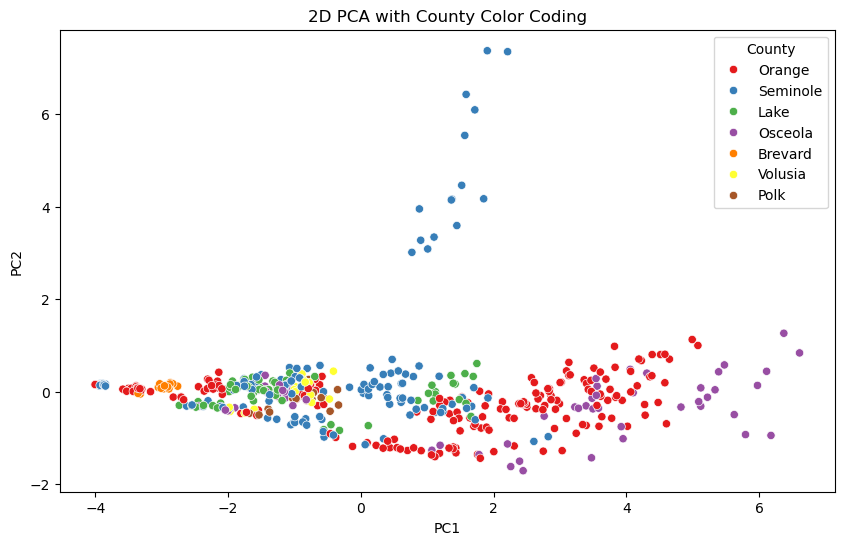

In [35]:
# Apply 2D PCA
pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(normalized_df)

# Create a DataFrame for 2D PCA results
pca_df_2d = pd.DataFrame(data=pca_result_2d, columns=['PC1', 'PC2'])
pca_df_2d['County'] = branch_level_data['County']

# Plot 2D PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='County', data=pca_df_2d, palette='Set1')
plt.title('2D PCA with County Color Coding')
plt.show()

In [36]:
# Print the explained variance ratio
explained_variance_ratio = pca_2d.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [0.73354733 0.10260918]


In [37]:
# Visualize the cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)

Cumulative Explained Variance: [0.73354733 0.83615651]


In [38]:
# Get the feature loadings for PC1 and PC2
loadings_df = pd.DataFrame(pca_2d.components_, columns=normalized_df.columns, index=['PC1', 'PC2'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

Feature Loadings for PC1:
Home Banking         0.375052
Draft                0.369809
Fee                  0.369386
Dividend             0.362099
ATM                  0.340491
Credit/Debit Card    0.334605
Cash                 0.320927
ACH                  0.313852
Bill Payment         0.160074
Name: PC1, dtype: float64

Feature Loadings for PC2:
Bill Payment         0.866065
ACH                  0.299259
Draft                0.050294
Home Banking         0.023659
Cash                -0.019683
Dividend            -0.099272
Fee                 -0.121951
Credit/Debit Card   -0.228182
ATM                 -0.283029
Name: PC2, dtype: float64


In [39]:
# Apply 3D PCA
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(normalized_df)

# Create a DataFrame for 3D PCA results
pca_df_3d = pd.DataFrame(data=pca_result_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['County'] = branch_level_data['County']

# Plot 3D PCA with Plotly
fig = px.scatter_3d(pca_df_3d, x='PC1', y='PC2', z='PC3', color='County', labels={'County': 'County'}, 
                    title='3D PCA with County Color Coding', opacity=0.7, width=1100, height=800,
                    color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker_size=5)
fig.update_layout(legend_title_text='County', legend=dict(yanchor="top", y=0.79, xanchor="left", x=0.01))

# Show the interactive 3D plot
fig.show()

In [40]:
# Print the explained variance ratio
explained_variance_ratio = pca_3d.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [0.73354733 0.10260918 0.080207  ]


In [41]:
# Visualize the cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)

Cumulative Explained Variance: [0.73354733 0.83615651 0.91636351]


In [42]:
# Get the feature loadings for PC1, PC2, and PC3
loadings_df = pd.DataFrame(pca_3d.components_, columns=normalized_df.columns, index=['PC1', 'PC2', 'PC3'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

print("\nFeature Loadings for PC3:")
print(loadings_df.loc['PC3'].sort_values(ascending=False))

Feature Loadings for PC1:
Home Banking         0.375052
Draft                0.369809
Fee                  0.369386
Dividend             0.362099
ATM                  0.340491
Credit/Debit Card    0.334605
Cash                 0.320927
ACH                  0.313852
Bill Payment         0.160074
Name: PC1, dtype: float64

Feature Loadings for PC2:
Bill Payment         0.866065
ACH                  0.299259
Draft                0.050294
Home Banking         0.023659
Cash                -0.019683
Dividend            -0.099272
Fee                 -0.121951
Credit/Debit Card   -0.228182
ATM                 -0.283029
Name: PC2, dtype: float64

Feature Loadings for PC3:
Credit/Debit Card    0.473294
Bill Payment         0.382239
Dividend             0.262590
Fee                  0.137018
ATM                  0.096695
Home Banking        -0.014182
Draft               -0.217140
Cash                -0.480137
ACH                 -0.504902
Name: PC3, dtype: float64


In [43]:
pca_df_3d['Revenue_Per_County'] = branch_level_data['Revenue_Per_County']
pca_df_3d.head()

PC1       PC2       PC3    County Revenue_Per_County
0 -3.928480  0.158439 -0.286203    Orange         6968835122
1  0.451635  0.401322 -0.372388  Seminole         1830400546
2  2.569815  0.302398 -0.817412    Orange         6968835122
3  1.357435  0.353113 -0.546204      Lake         1003940427
4 -3.407836  0.081765 -0.280570    Orange         6968835122

# XXXXX

* County Selection Model

In [44]:
import pandas as pd
from io import StringIO

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

# Load Branch Level Data and Member Level Data
df1 = pd.read_csv("data/Florida_County_Info_-_Sheet1.csv")
df1.rename(columns={'Count': 'County'}, inplace=True)

In [45]:
import pandas as pd
from io import StringIO

data_comma_separated = """Rank,County,Small Business Establishments,Establishments per 1,000 Residents,Share
1,Santa Rosa,3,209,16.6,99.8%
2,Hendry,681,16.9,99.9%
3,Washington,426,17.1,99.5%
4,Putnam,1,276,17.2,99.8%
5,Madison,314,17.4,100.0%
6,Polk,13,130,17.4,99.7%
7,Jackson,823,17.5,99.5%
8,Hernando,3,657,18.2,99.9%
9,Citrus,2,895,18.3,99.8%
10,Levy,810,18.3,100.0%
11,Pasco,11,112,19.0,99.9%
12,Osceola,7,707,19.1,99.8%
13,Clay,4,263,19.2,99.9%
14,Taylor,403,19.4,99.8%
15,Jefferson,282,19.5,100.0%
16,St. Lucie,6,750,19.6,99.9%
17,Highlands,2,043,19.8,100.0%
18,Marion,7,801,20.3,99.9%
19,Flagler,2,484,20.6,100.0%
20,Columbia,1,452,20.8,99.9%
21,Lake,8,333,21.0,99.9%
22,Okeechobee,868,21.7,99.8%
23,Nassau,2,071,21.9,100.0%
24,Charlotte,4,308,22.1,100.0%
25,Escambia,7,399,22.9,99.9%
26,Alachua,6,509,23.1,99.8%
27,Gulf,343,23.7,99.7%
28,Brevard,15,008,24.3,99.8%
29,Volusia,13,856,24.5,99.9%
30,Manatee,10,377,25.1,99.9%
31,Franklin,309,25.4,100.0%
32,St. Johns,7,692,26.2,99.9%
33,Lee,21,184,26.8,99.9%
34,Leon,7,932,26.8,99.9%
35,Okaloosa,5,789,27.1,99.9%
36,Duval,27,373,27.3,99.7%
37,Bay,4,989,27.8,99.9%
38,Hillsborough,41,277,27.8,99.7%
39,Indian River,4,626,28.2,99.9%
40,Orange,43,056,30.2,99.7%
41,Seminole,14,666,31.1,99.8%
42,Pinellas,30,937,32.3,99.8%
43,Sarasota,15,192,33.9,100.0%
44,Broward,67,026,34.6,99.8%
45,Collier,13,535,35.0,99.9%
46,Miami-Dade,94,470,35.4,99.9%
47,Palm Beach,53,680,35.7,99.9%
48,Walton,2,965,37.1,99.9%
49,Martin,6,041,37.7,99.9%
50,Monroe,4,009,48.7,100.0%"""

# load and display data
df2 = pd.read_csv(StringIO(data_comma_separated))
print(df2)

    Rank        County  Small Business Establishments  Establishments per 1  \
0      1    Santa Rosa                              3                 209.0   
1      2        Hendry                            681                  16.9   
2      3    Washington                            426                  17.1   
3      4        Putnam                              1                 276.0   
4      5       Madison                            314                  17.4   
5      6          Polk                             13                 130.0   
6      7       Jackson                            823                  17.5   
7      8      Hernando                              3                 657.0   
8      9        Citrus                              2                 895.0   
9     10          Levy                            810                  18.3   
10    11         Pasco                             11                 112.0   
11    12       Osceola                              

In [46]:
print(df1.columns)
print(df2.columns)

Index(['Rank', 'County', 'Per Capita Income', 'Median Household Income',
       'Median Family Income', 'Population', 'Number of households',
       'Total Number of Small Businesses', 'Number of Credit Unions'],
      dtype='object')
Index(['Rank', 'County', 'Small Business Establishments',
       'Establishments per 1', '000 Residents', 'Share'],
      dtype='object')


In [47]:
# merge datasets
merged_data = pd.merge(df1, df2, on="County")

merged_data.rename(columns={'Establishments per 1': 'Establishments per 1000 residents'}, inplace=True)
merged_data = merged_data.drop('000 Residents', axis=1)
merged_data = merged_data.drop('Small Business Establishments', axis=1)



# clean data
columns_to_clean = ['Per Capita Income', 'Median Household Income', 'Median Family Income', 'Number of households', 'Population']

# loop through columns and remove dollar signs and commas
for column in columns_to_clean:
    merged_data[column] = merged_data[column].str.replace('[\$,]', '', regex=True)
    
merged_data['Share'] = pd.to_numeric(merged_data['Share'].str.rstrip('%'), errors='coerce')
merged_data = merged_data.drop(['Rank_x', 'Rank_y'], axis=1)

merged_data = merged_data.set_index('County')
merged_data = merged_data.apply(pd.to_numeric, errors='coerce')
merged_data = merged_data.fillna(0)



    
merged_data

Per Capita Income  Median Household Income  \
County                                                     
Collier                   37046                    58106   
St. Johns                 36027                    62663   
Martin                    35772                    53210   
Monroe                    35516                    53821   
Palm Beach                33610                    53242   
Sarasota                  33045                    49388   
Indian River              31918                    47341   
Seminole                  29795                    58971   
Lee                       29445                    50014   
Nassau                    29089                    58712   
Pinellas                  28742                    45258   
Broward                   28631                    51694   
Okaloosa                  28621                    54242   
Manatee                   28072                    47812   
Walton                    27746                    47273   
Brevard                   27606                    49523   
Hillsborough              27062                    49536   
Charlotte                 26938                    45037   
Clay                      26872                    61185   
Duval                     25854                    49463   
Leon                      25803                    44490   
Orange                    25490                    50138   
Santa Rosa                25384                    55129   
Lake                      25323                    46477   
Bay                       25033                    47770   
Flagler                   24939                    48090   
Volusia                   24768                    44400   
Alachua                   24741                    40644   
Pasco                     24164                    44228   
Escambia                  23474                    43573   
St. Lucie                 23296                    45196   
Miami-Dade                22957                    43605   
Hernando                  22775                    42011   
Citrus                    22551                    37933   
Marion                    22384                    40339   
Polk                      21881                    43946   
Franklin                  21005                    36490   
Osceola                   20536                    46328   
Okeechobee                19664                    38339   
Jefferson                 19647                    41359   
Highlands                 19579                    34946   
Columbia                  19366                    38214   
Levy                      18703                    35737   
Taylor                    18649                    37408   
Washington                18470                    36216   
Putnam                    18402                    34645   
Gulf                      17968                    39178   
Jackson                   17177                    38257   
Madison                   16346                    37459   
Hendry                    14734                    37298   

              Median Family Income  Population  Number of households  \
County                                                                 
Collier                      68556      321520                133179   
St. Johns                    79080      190039                 75338   
Martin                       70271      146318                 63899   
Monroe                       66152       73090                 32629   
Palm Beach                   64445     1320134                544227   
Sarasota                     62326      379448                175746   
Indian River                 57477      138028                 60176   
Seminole                     70597      422718                164706   
Lee                          58950      618754                259818   
Nassau                       66233       73314                 28794   
Pinellas                     

In [48]:
# Check the data types of each column
print(merged_data.dtypes)

Per Capita Income                      int64
Median Household Income                int64
Median Family Income                   int64
Population                             int64
Number of households                   int64
Total Number of Small Businesses     float64
Number of Credit Unions              float64
Establishments per 1000 residents    float64
Share                                float64
dtype: object


In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# X contains the features, and y contains the target variable
X = merged_data.drop('Share', axis=1)
y = merged_data['Share']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# randome forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# train
rf_regressor.fit(X_train, y_train)

# Predict
y_pred = rf_regressor.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')




Mean Squared Error: 8.34816720000006
R-squared: 0.9947706585699941


In [50]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score 
# set the target variable
target_column = 'Number of Credit Unions'
y = merged_data[target_column]

# set features
X = merged_data.drop([target_column], axis=1)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions) 

print(f"Mean Squared Error: {mse}")
print(f'R-squared: {r2}')



Mean Squared Error: 9.42518
R-squared: 0.6539948604992658


In [51]:
# get feature importances to find the total small business establishments
feature_importances = model.feature_importances_

# create datafram to displace feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# sort
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# print
print(feature_importance_df)

                             Feature  Importance
3                         Population    0.289129
4               Number of households    0.258212
5   Total Number of Small Businesses    0.237611
0                  Per Capita Income    0.058341
6  Establishments per 1000 residents    0.055281
2               Median Family Income    0.051343
1            Median Household Income    0.039309
7                              Share    0.010775


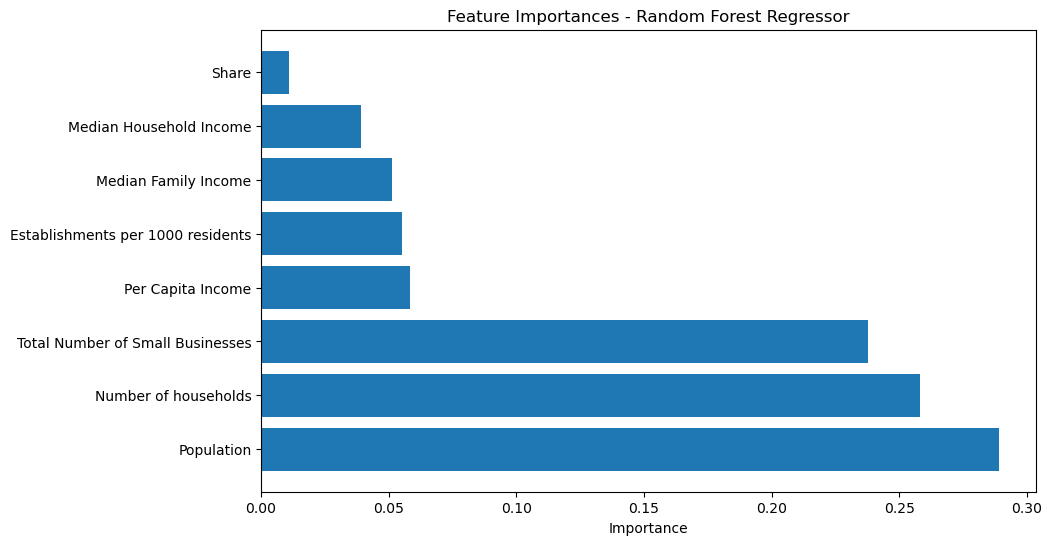

In [52]:
import matplotlib.pyplot as plt

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances - Random Forest Regressor')
plt.show()

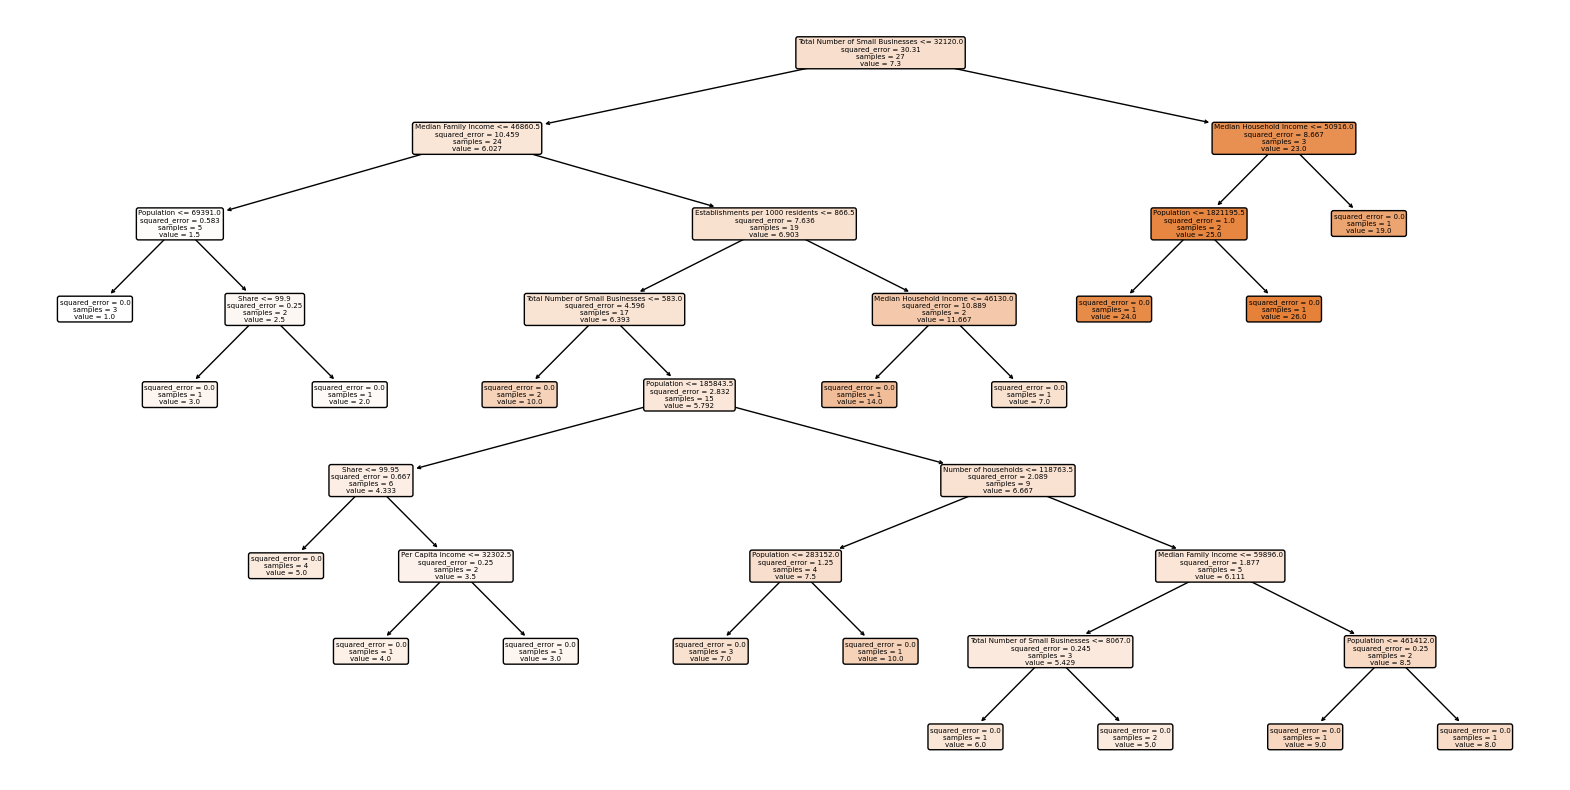

In [53]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=X.columns, filled=True, rounded=True, class_names=['Not Churn', 'Churn'])
plt.show()


Mean Squared Error: 4629280.129850002
R-squared: 0.7719016166316764
                             Feature  Importance
0                  Per Capita Income    0.488364
1               Median Family Income    0.395920
6  Establishments per 1000 residents    0.033417
4   Total Number of Small Businesses    0.027694
2                         Population    0.022943
3               Number of households    0.016948
5            Number of Credit Unions    0.012898
7                              Share    0.001817


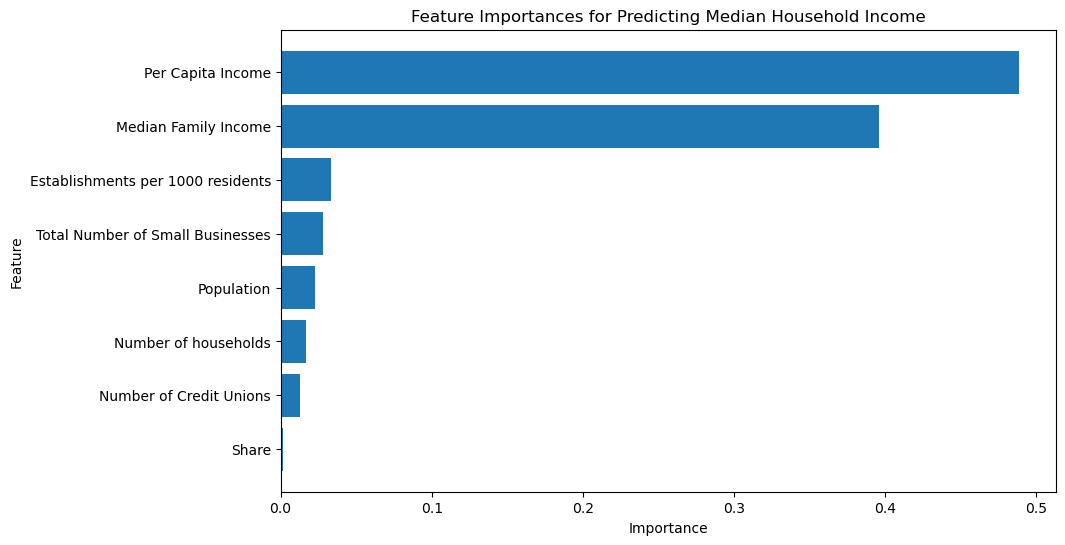

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# convert non-numeric columns to numeric using Label Encoding
label_encoders = {}
for column in merged_data.columns:
    if merged_data[column].dtype == object:
        le = LabelEncoder()
        merged_data[column] = le.fit_transform(merged_data[column])
        label_encoders[column] = le

# Set the target variable
target_column = 'Median Household Income'
y = merged_data[target_column]

# set features
X = merged_data.drop([target_column], axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f'R-squared: {r2}')

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the sorted feature importances
print(feature_importance_df)

# Visualization of Feature Importances
plt.figure(figsize=(10, 6))  # Set the figure size
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance']) 
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Predicting Median Household Income')
plt.gca().invert_yaxis()  
plt.show()

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

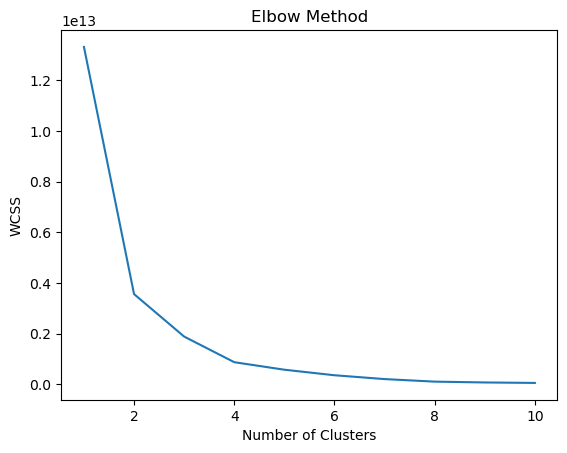

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



          County  Cluster
0        Collier        0
1      St. Johns        0
2         Martin        0
3         Monroe        0
4     Palm Beach        2
5       Sarasota        0
6   Indian River        0
7       Seminole        0
8            Lee        2
9         Nassau        0
10      Pinellas        2
11       Broward        1
12      Okaloosa        0
13       Manatee        0
14        Walton        0
15       Brevard        2
16  Hillsborough        2
17     Charlotte        0
18          Clay        0
19         Duval        2
20          Leon        0
21        Orange        2
22    Santa Rosa        0
23          Lake        0
24           Bay        0
25       Flagler        0
26       Volusia        0
27       Alachua        0
28         Pasco        0
29      Escambia        0
30     St. Lucie        0
31    Miami-Dade        1
32      Hernando        0
33        Citrus        0
34        Marion        0
35          Polk        2
36      Franklin        0
37       Osc

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# drop non-numeric columns
X = merged_data.select_dtypes(include=['float64', 'int64'])

# determine optimal k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# plot
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within-Cluster Sum of Squares
plt.show()

# Based on the Elbow method, choose the optimal number of clusters and fit the model
optimal_clusters = 3 
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X)

# Add the cluster labels 
merged_data['Cluster'] = kmeans.labels_

merged_data.reset_index(inplace=True)


# Display the cluster assignments
print(merged_data[['County', 'Cluster']])


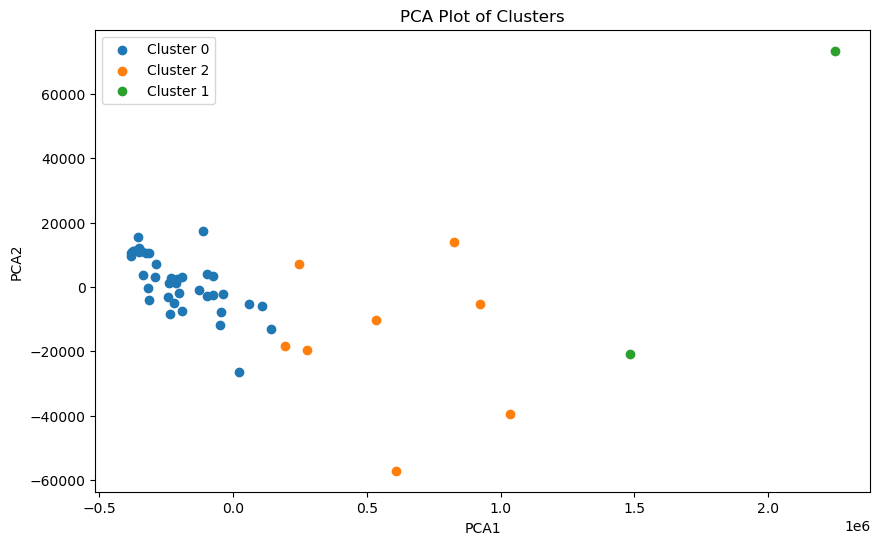

In [56]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming you have a DataFrame named 'merged_data' with 'Cluster' column
# Extract numerical columns for PCA
numerical_data = merged_data[['Per Capita Income', 'Median Household Income', 'Median Family Income', 'Population', 'Number of households', 'Total Number of Small Businesses', 'Share']]

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numerical_data)

# Add the 'Cluster' column to the reduced data
pca_data = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_data['Cluster'] = merged_data['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))

for cluster in pca_data['Cluster'].unique():
    cluster_data = pca_data[pca_data['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.title('PCA Plot of Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()




Mean Squared Error: 3634221.00
R-squared: 0.94


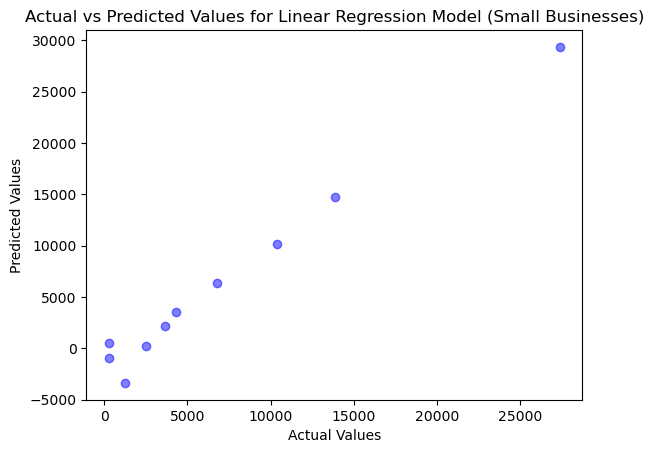

In [57]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# features and target variable
X = merged_data[['Per Capita Income', 'Median Household Income', 'Median Family Income', 'Population', 'Number of households', 'Share']]
y = merged_data['Total Number of Small Businesses']  # Change the target variable

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print evaluation metrics
print(f"\nMean Squared Error: {mse:.2f}")
print(f'R-squared: {r2:.2f}')

# Plot predicted vs actual values
plt.scatter(y_test, predictions, color='blue', alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Linear Regression Model (Small Businesses)")
plt.show()




[[7 1]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.67      1.00      0.80         2

    accuracy                           0.90        10
   macro avg       0.83      0.94      0.87        10
weighted avg       0.93      0.90      0.91        10



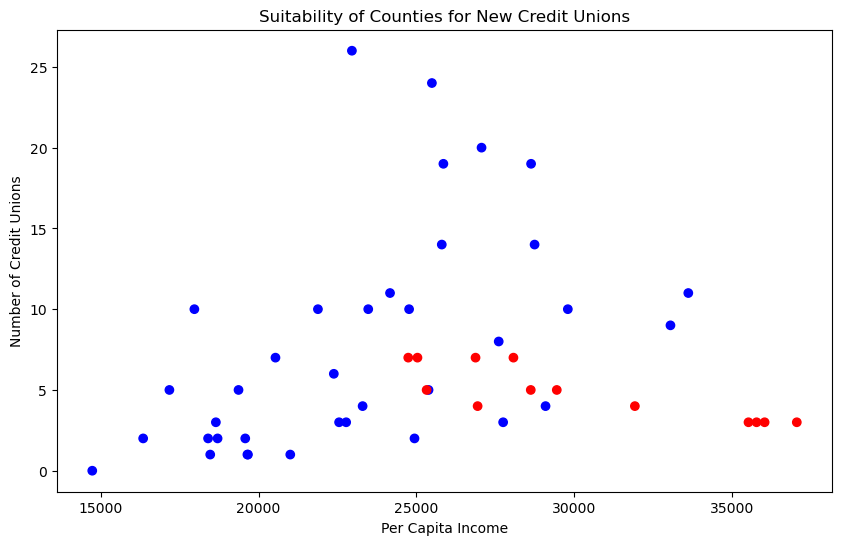

Counties suitable for a new credit union:
0
1
2
3
5
6
7
9
12
13
14
17
20
22
25
27


In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# calculate adjusted percentiles
percentile_40_income = merged_data['Per Capita Income'].quantile(0.40)
percentile_60_credit_unions = merged_data['Number of Credit Unions'].quantile(0.60)
percentile_40_small_businesses = merged_data['Total Number of Small Businesses'].quantile(0.40)

# define the new suitability criteria
merged_data['Suitable'] = ((merged_data['Per Capita Income'] >= percentile_40_income) & 
                           (merged_data['Number of Credit Unions'] <= percentile_60_credit_unions) &
                           (merged_data['Total Number of Small Businesses'] >= percentile_40_small_businesses)).astype(int)



# check if county is a column and drop it if it is
if 'County' in merged_data.columns:
    X = merged_data.drop(['Suitable', 'County'], axis=1)
else:
    X = merged_data.drop('Suitable', axis=1)

y = merged_data['Suitable']

# normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# create and train model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# predict sustainability
merged_data['Predicted_Suitability'] = knn.predict(X_scaled)

# Filter out suitable counties
suitable_counties = merged_data[merged_data['Predicted_Suitability'] == 1].index

# Predictions and evaluations
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualization
plt.figure(figsize=(10, 6))
colors = ['red' if label else 'blue' for label in merged_data['Suitable']]
plt.scatter(merged_data['Per Capita Income'], merged_data['Number of Credit Unions'], c=colors)
plt.title('Suitability of Counties for New Credit Unions')
plt.xlabel('Per Capita Income')
plt.ylabel('Number of Credit Unions')
plt.show()

# Print the suitable counties
print("Counties suitable for a new credit union:")
for county in suitable_counties:
    print(county)




In [59]:
# Include 'County' for reference but exclude it from the scaled features
merged_data['Predicted_Suitability'] = knn.predict(scaler.transform(X))

# Filter out suitable counties and include 'County' for reference
suitable_counties_df = merged_data[merged_data['Predicted_Suitability'] == 1]

# Print the suitable counties
print("Counties suitable for a new credit union:")
for county in suitable_counties_df['County']:
    print(county)

Counties suitable for a new credit union:
Collier
St. Johns
Martin
Monroe
Sarasota
Indian River
Seminole
Nassau
Okaloosa
Manatee
Walton
Charlotte
Leon
Santa Rosa
Flagler
Alachua


Counties strictly under the regression line (fewer credit unions than predicted):
['St. Johns', 'Palm Beach', 'Lee', 'Broward', 'Alachua', 'St. Lucie', 'Miami-Dade', 'Washington', 'Putnam', 'Madison']

Mean Squared Error: 6.57
R-squared: 0.82


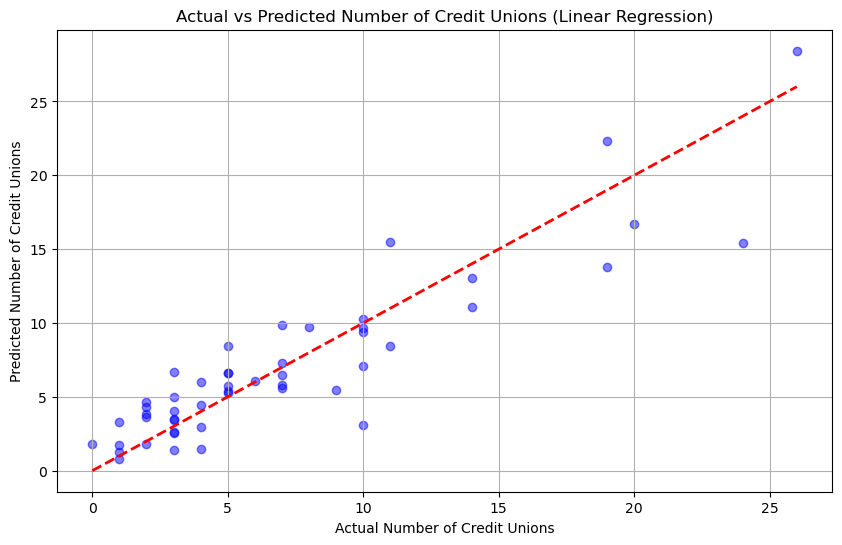

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Features and target variable
X = merged_data[['Per Capita Income', 'Median Household Income', 'Median Family Income', 'Population', 'Number of households', 'Share']]
y = merged_data['Number of Credit Unions']  # Target variable: Number of Credit Unions

# create a linear regression model
model = LinearRegression()

# fit the model
model.fit(X, y)

# make predictions
predictions = model.predict(X)

# calculate residuals
residuals = y - predictions

# define a stricter threshold (e.g., based on residuals)
strict_threshold = -2  

# get the counties with significantly fewer credit unions 
counties_strictly_under_regression_line = merged_data[residuals < strict_threshold]

# print names under regression line
print("Counties strictly under the regression line (fewer credit unions than predicted):")
print(counties_strictly_under_regression_line['County'].tolist())

# evaluate model
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)

# evaluation metrics
print(f"\nMean Squared Error: {mse:.2f}")
print(f'R-squared: {r2:.2f}')

# visualization
plt.figure(figsize=(10, 6))
plt.scatter(y, predictions, color='blue', alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linewidth=2, linestyle='--')  # Regression line (y=x)
plt.xlabel("Actual Number of Credit Unions")
plt.ylabel("Predicted Number of Credit Unions")
plt.title("Actual vs Predicted Number of Credit Unions (Linear Regression)")
plt.grid(True)
plt.show()


# XXXXX

Download given branch level data and remove the high school branches. Additionally, we create a new column for total transactions.

In [61]:
branch_data = pd.read_csv("data/Branch_Level_Dataset.csv")
filtered_branch_data = branch_data[~branch_data['BranchCategory'].str.contains('High School')]
#Create column for total transcations of a row
filtered_branch_data['Total_Transactions'] = filtered_branch_data[['ATM', 'Bill Payment', 'Cash', 'Draft', 'ACH', 'Fee', 'Credit/Debit Card', 'Home Banking', 'Dividend']].sum(axis=1)
print(filtered_branch_data['BranchCategory'].unique())


['Addition Financial Arena' 'Altamonte Springs' 'Apopka' 'Clermont'
 'Downtown Campus' 'East Orlando' 'Eustis' 'Fern Park' 'Kissimmee'
 'Lake Mary' 'Lake Nona' 'Leesburg' 'Longwood' 'Merritt Island'
 'MetroWest' 'Mills' 'Orange City' 'Oviedo' 'Pine Hills' 'Poinciana'
 'Sanford' 'Seminole State' 'South Orlando' 'St. Cloud' 'The Loop'
 'UCF Campus' 'UCF Commons' 'Virtual Branch' 'Winter Garden']


C:\Users\perez\AppData\Local\Temp\ipykernel_14192\3325202573.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Map the branches to their respective counties which they reside.

In [62]:
branch_category_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}

filtered_branch_data['County'] = filtered_branch_data['BranchCategory'].map(branch_category_mapping)

# Convert 'EOM TRANS DATE' to a datetime object for date-based operations
filtered_branch_data['EOM_TRANS_DATE'] = pd.to_datetime(filtered_branch_data['EOM_TRANS_DATE'])



C:\Users\perez\AppData\Local\Temp\ipykernel_14192\1077371473.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\perez\AppData\Local\Temp\ipykernel_14192\1077371473.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Addition financial and ucf commons do not have complete data, but this will be addressed later.

Here is the mostly cleaned branch level dataset. The virtual branch will be removed when the this dataset in inner merged with the outside economic dataset.

In [63]:
df_relevant = filtered_branch_data.drop(['EOM_TRANS_DATE'],axis = 1)
df_relevant

BranchCategory  ATM  Bill Payment  Cash  Draft   ACH  Fee  \
0    Addition Financial Arena    0             3     0     28     5   20   
1           Altamonte Springs   98           394    64    469  1589  416   
2                      Apopka  198           540   132    705  2219  560   
4                    Clermont  143           482   103    499  1940  539   
6             Downtown Campus   27            35    12     62   134   78   
..                        ...  ...           ...   ...    ...   ...  ...   
724                 St. Cloud  208           623   145    846  3279  779   
726                  The Loop   66           155    68    210   871  287   
728                UCF Campus   30            92    11    153   715  192   
729            Virtual Branch   56            98    10    325   426  611   
730             Winter Garden  167           448   114    665  2382  576   

     Credit/Debit Card  Home Banking  Dividend  Total_Transactions    County  
0                    6             4        14                  80    Orange  
1                 1642           646      3650                8968  Seminole  
2                 1983           724      5731               12792    Orange  
4                 1834           580      4551               10671      Lake  
6                  227            47       275                 897    Orange  
..                 ...           ...       ...                 ...       ...  
724               4750          1269      8096               19995   Osceola  
726               1206           378      2218                5459   Osceola  
728                839           250      1867                4149    Orange  
729               1090           455      1285                4356       NaN  
730               2933           774      6809               14868    Orange  

[541 rows x 12 columns]

Here we download and create the economic data by county. This contains information about income, population, and existing credit unions.

In [64]:
df1 = pd.read_csv("data/Florida_County_Info_-_Sheet1.csv")
df1.rename(columns={'Count': 'County'}, inplace=True)

In [65]:
from io import StringIO

data_comma_separated = """Rank,County,Small Business Establishments,Establishments per 1,000 Residents,Share
1,Santa Rosa,3,209,16.6,99.8%
2,Hendry,681,16.9,99.9%
3,Washington,426,17.1,99.5%
4,Putnam,1,276,17.2,99.8%
5,Madison,314,17.4,100.0%
6,Polk,13,130,17.4,99.7%
7,Jackson,823,17.5,99.5%
8,Hernando,3,657,18.2,99.9%
9,Citrus,2,895,18.3,99.8%
10,Levy,810,18.3,100.0%
11,Pasco,11,112,19.0,99.9%
12,Osceola,7,707,19.1,99.8%
13,Clay,4,263,19.2,99.9%
14,Taylor,403,19.4,99.8%
15,Jefferson,282,19.5,100.0%
16,St. Lucie,6,750,19.6,99.9%
17,Highlands,2,043,19.8,100.0%
18,Marion,7,801,20.3,99.9%
19,Flagler,2,484,20.6,100.0%
20,Columbia,1,452,20.8,99.9%
21,Lake,8,333,21.0,99.9%
22,Okeechobee,868,21.7,99.8%
23,Nassau,2,071,21.9,100.0%
24,Charlotte,4,308,22.1,100.0%
25,Escambia,7,399,22.9,99.9%
26,Alachua,6,509,23.1,99.8%
27,Gulf,343,23.7,99.7%
28,Brevard,15,008,24.3,99.8%
29,Volusia,13,856,24.5,99.9%
30,Manatee,10,377,25.1,99.9%
31,Franklin,309,25.4,100.0%
32,St. Johns,7,692,26.2,99.9%
33,Lee,21,184,26.8,99.9%
34,Leon,7,932,26.8,99.9%
35,Okaloosa,5,789,27.1,99.9%
36,Duval,27,373,27.3,99.7%
37,Bay,4,989,27.8,99.9%
38,Hillsborough,41,277,27.8,99.7%
39,Indian River,4,626,28.2,99.9%
40,Orange,43,056,30.2,99.7%
41,Seminole,14,666,31.1,99.8%
42,Pinellas,30,937,32.3,99.8%
43,Sarasota,15,192,33.9,100.0%
44,Broward,67,026,34.6,99.8%
45,Collier,13,535,35.0,99.9%
46,Miami-Dade,94,470,35.4,99.9%
47,Palm Beach,53,680,35.7,99.9%
48,Walton,2,965,37.1,99.9%
49,Martin,6,041,37.7,99.9%
50,Monroe,4,009,48.7,100.0%"""

# load written data
df2 = pd.read_csv(StringIO(data_comma_separated))

In [66]:
# merge datasets
merged_data = pd.merge(df1, df2, on="County")

merged_data.rename(columns={'Establishments per 1': 'Establishments per 1000 residents'}, inplace=True)
merged_data = merged_data.drop('000 Residents', axis=1)
merged_data = merged_data.drop('Small Business Establishments', axis=1)

# clean data
columns_to_clean = ['Per Capita Income', 'Median Household Income', 'Median Family Income', 'Number of households', 'Population']

# loop through columns and remove dollar signs and commas
for column in columns_to_clean:
    merged_data[column] = merged_data[column].str.replace('[\$,]', '', regex=True)
    
merged_data['Share'] = pd.to_numeric(merged_data['Share'].str.rstrip('%'), errors='coerce')
merged_data = merged_data.drop(['Rank_x', 'Rank_y'], axis=1)

merged_data = merged_data.set_index('County')
merged_data = merged_data.apply(pd.to_numeric, errors='coerce')
merged_data = merged_data.fillna(0)

merged_data = merged_data.drop(columns='Share')

merged_data

Per Capita Income  Median Household Income  \
County                                                     
Collier                   37046                    58106   
St. Johns                 36027                    62663   
Martin                    35772                    53210   
Monroe                    35516                    53821   
Palm Beach                33610                    53242   
Sarasota                  33045                    49388   
Indian River              31918                    47341   
Seminole                  29795                    58971   
Lee                       29445                    50014   
Nassau                    29089                    58712   
Pinellas                  28742                    45258   
Broward                   28631                    51694   
Okaloosa                  28621                    54242   
Manatee                   28072                    47812   
Walton                    27746                    47273   
Brevard                   27606                    49523   
Hillsborough              27062                    49536   
Charlotte                 26938                    45037   
Clay                      26872                    61185   
Duval                     25854                    49463   
Leon                      25803                    44490   
Orange                    25490                    50138   
Santa Rosa                25384                    55129   
Lake                      25323                    46477   
Bay                       25033                    47770   
Flagler                   24939                    48090   
Volusia                   24768                    44400   
Alachua                   24741                    40644   
Pasco                     24164                    44228   
Escambia                  23474                    43573   
St. Lucie                 23296                    45196   
Miami-Dade                22957                    43605   
Hernando                  22775                    42011   
Citrus                    22551                    37933   
Marion                    22384                    40339   
Polk                      21881                    43946   
Franklin                  21005                    36490   
Osceola                   20536                    46328   
Okeechobee                19664                    38339   
Jefferson                 19647                    41359   
Highlands                 19579                    34946   
Columbia                  19366                    38214   
Levy                      18703                    35737   
Taylor                    18649                    37408   
Washington                18470                    36216   
Putnam                    18402                    34645   
Gulf                      17968                    39178   
Jackson                   17177                    38257   
Madison                   16346                    37459   
Hendry                    14734                    37298   

              Median Family Income  Population  Number of households  \
County                                                                 
Collier                      68556      321520                133179   
St. Johns                    79080      190039                 75338   
Martin                       70271      146318                 63899   
Monroe                       66152       73090                 32629   
Palm Beach                   64445     1320134                544227   
Sarasota                     62326      379448                175746   
Indian River                 57477      138028                 60176   
Seminole                     70597      422718                164706   
Lee                          58950      618754                259818   
Nassau                       66233       73314                 28794   
Pinellas                     

In [67]:
df_relevant = pd.merge(df_relevant, merged_data, on='County', how='inner')
df_relevant

BranchCategory  ATM  Bill Payment  Cash  Draft   ACH  Fee  \
0    Addition Financial Arena    0             3     0     28     5   20   
1                      Apopka  198           540   132    705  2219  560   
2             Downtown Campus   27            35    12     62   134   78   
3                East Orlando  165           701   106    836  3325  789   
4                   Lake Nona   53           244    28    293  1119  368   
..                        ...  ...           ...   ...    ...   ...  ...   
517                 Poinciana  128           138    78    289   460  403   
518                 Poinciana   99           105     0    260     0  379   
519                 Poinciana   92           165    86    338   691  381   
520                 Poinciana  122           221    90    304   454  427   
521                 Poinciana   96           168    56    348   831  431   

     Credit/Debit Card  Home Banking  Dividend  Total_Transactions  County  \
0                    6             4        14                  80  Orange   
1                 1983           724      5731               12792  Orange   
2                  227            47       275                 897  Orange   
3                 2993          1057      7938               17910  Orange   
4                 1065           427      2623                6220  Orange   
..                 ...           ...       ...                 ...     ...   
517               1480           541      2137                5654    Polk   
518               1474           290      2148                4755    Polk   
519               1393           473      2230                5849    Polk   
520               1495           519      2256                5888    Polk   
521               1344           437      2207                5918    Polk   

     Per Capita Income  Median Household Income  Median Family Income  \
0                25490                    50138                 57473   
1                25490                    50138                 57473   
2                25490                    50138                 57473   
3                25490                    50138                 57473   
4                25490                    50138                 57473   
..                 ...                      ...                   ...   
517              21881                    43946                 51395   
518              21881                    43946                 51395   
519              21881                    43946                 51395   
520              21881                    43946                 51395   
521              21881                    43946                 51395   

     Population  Number of households  Total Number of Small Businesses  \
0       1145956                421847                           43056.0   
1       1145956                421847                           43056.0   
2       1145956                421847                           43056.0   
3       1145956                421847                           43056.0   
4       1145956                421847                           43056.0   
..          ...                   ...                               ...   
517      602095                227485                               0.0   
518      602095                227485                               0.0   
519      602095                227485                               0.0   
520      602095                227485                               0.0   
521      602095                227485                               0.0   

     Number of Credit Unions  Establishments per 1000 residents  
0                       24.0                               56.0  
1                       24.0                               56.0  
2                       24.0                               56.0  
3                       24.0                               56.0  
4                       24.0                             

After sorting the data by branch category, we now have our final dataset to create our model.

In [68]:
df_relevant['row_number'] = df_relevant.index

# Sort the DataFrame by 'BranchCategory' and 'row_number'
sorted_df = df_relevant.sort_values(by=['BranchCategory', 'row_number'])

# Drop the 'row_number' column
df_relevant = sorted_df.drop(columns='row_number')
df_relevant = df_relevant.reset_index(drop=True)
df_relevant

BranchCategory  ATM  Bill Payment  Cash  Draft   ACH  Fee  \
0    Addition Financial Arena    0             3     0     28     5   20   
1    Addition Financial Arena    1             0     0     18     8   24   
2    Addition Financial Arena    1             0     0     25     2   19   
3    Addition Financial Arena    0             1     0     18     0   16   
4    Addition Financial Arena    0             0     0     20     2   15   
..                        ...  ...           ...   ...    ...   ...  ...   
517             Winter Garden  267           452   173    574  1204  537   
518             Winter Garden  209           269     0    284     0  506   
519             Winter Garden  214           410   145    803  1992  565   
520             Winter Garden  280           567   185    562  1346  561   
521             Winter Garden  167           448   114    665  2382  576   

     Credit/Debit Card  Home Banking  Dividend  Total_Transactions  County  \
0                    6             4        14                  80  Orange   
1                   14             0        13                  78  Orange   
2                    6             2        13                  68  Orange   
3                    5             0        12                  52  Orange   
4                    5             1         9                  52  Orange   
..                 ...           ...       ...                 ...     ...   
517               3481          1025      6698               14411  Orange   
518               3458           613      6691               12030  Orange   
519               3215           989      6874               15207  Orange   
520               3546          1122      6960               15129  Orange   
521               2933           774      6809               14868  Orange   

     Per Capita Income  Median Household Income  Median Family Income  \
0                25490                    50138                 57473   
1                25490                    50138                 57473   
2                25490                    50138                 57473   
3                25490                    50138                 57473   
4                25490                    50138                 57473   
..                 ...                      ...                   ...   
517              25490                    50138                 57473   
518              25490                    50138                 57473   
519              25490                    50138                 57473   
520              25490                    50138                 57473   
521              25490                    50138                 57473   

     Population  Number of households  Total Number of Small Businesses  \
0       1145956                421847                           43056.0   
1       1145956                421847                           43056.0   
2       1145956                421847                           43056.0   
3       1145956                421847                           43056.0   
4       1145956                421847                           43056.0   
..          ...                   ...                               ...   
517     1145956                421847                           43056.0   
518     1145956                421847                           43056.0   
519     1145956                421847                           43056.0   
520     1145956                421847                           43056.0   
521     1145956                421847                           43056.0   

     Number of Credit Unions  Establishments per 1000 residents  
0                       24.0                               56.0  
1                       24.0                               56.0  
2                       24.0                               56.0  
3                       24.0                               56.0  
4                       24.0                             

The following are random forest classifier models with branch category as the response. Also include dummy encoding for the county variable. We will use the sklearn feature importance score to find the most important features. The most important features will show the variables that are most useful for differentiating the different branches given a month of their transactions.

Model Accuracy: 0.9238095238095239
                              Feature  Importance
8                            Dividend    0.168664
5                                 Fee    0.146755
9                  Total_Transactions    0.104463
6                   Credit/Debit Card    0.070680
0                                 ATM    0.068637
7                        Home Banking    0.054650
3                               Draft    0.050326
1                        Bill Payment    0.040516
17  Establishments per 1000 residents    0.028934
12               Median Family Income    0.028720
10                  Per Capita Income    0.028102
14               Number of households    0.025929
15   Total Number of Small Businesses    0.024382
2                                Cash    0.024217
11            Median Household Income    0.023906
16            Number of Credit Unions    0.020512
13                         Population    0.020078
4                                 ACH    0.019734
24             

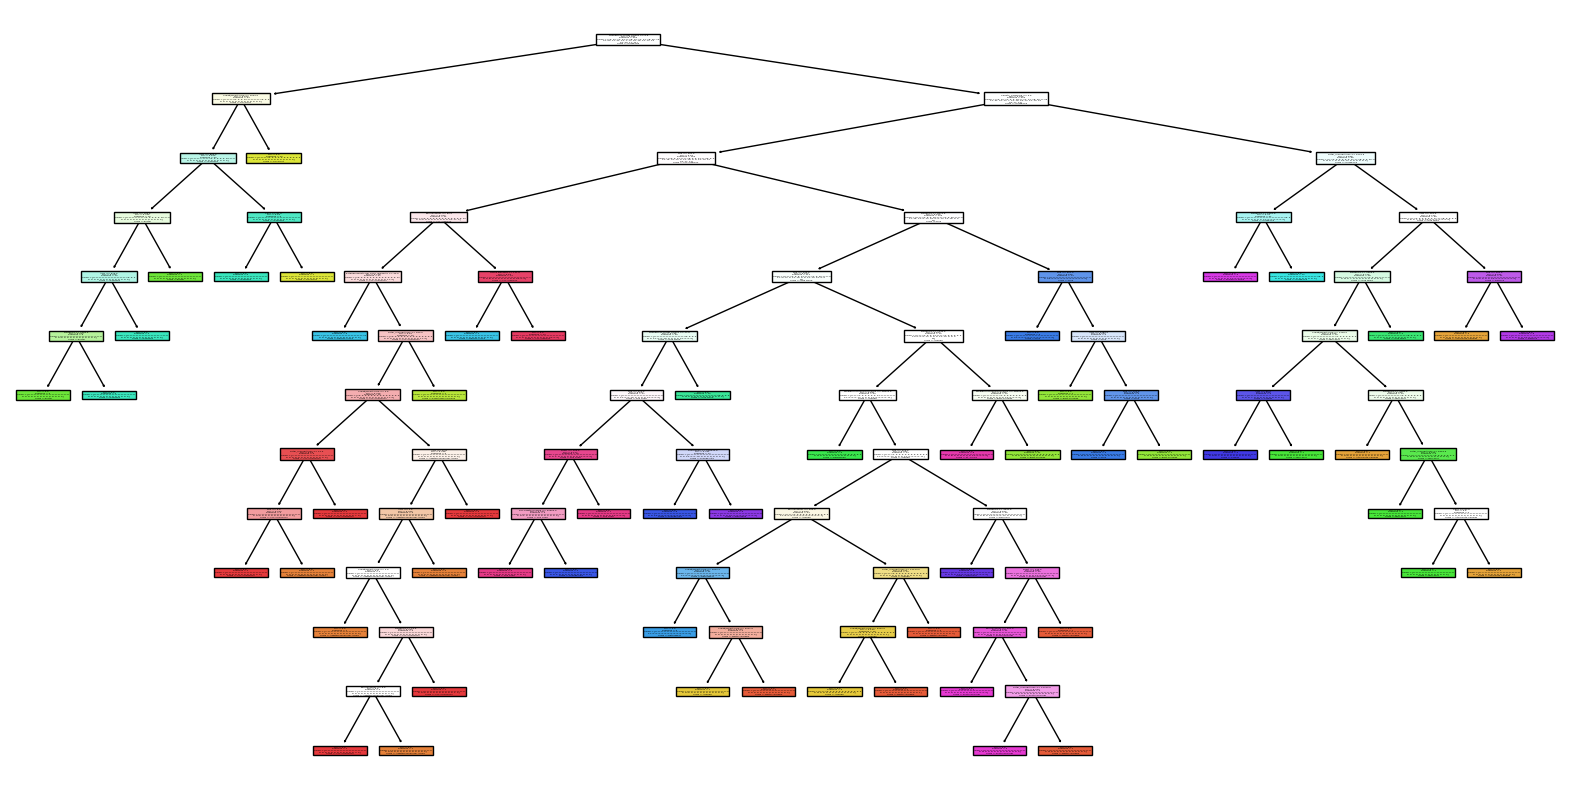

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

# Dummy encode the 'County' column
df_encoded = pd.get_dummies(df_relevant, columns=['County'], drop_first=False)

# Split the data into features (X) and response variable (y)
X = df_encoded.drop(['BranchCategory'], axis=1)
y = df_encoded['BranchCategory']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier model
model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")
# Access the feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances in order
print(importance_df)
# Plot the first tree in the forest
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=X.columns, filled=True, class_names=model.classes_)
plt.show()

Same model but without 'County' dummy encoding, so we use the df without dummy encoding.

In [70]:
# Split the data into features (X) and response variable (y)
X = df_relevant.drop(['BranchCategory','County'], axis=1)
y = df_relevant['BranchCategory']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier model
model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")
# Access the feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances in order
print(importance_df)

Model Accuracy: 0.9142857142857143
                              Feature  Importance
8                            Dividend    0.163584
5                                 Fee    0.157864
9                  Total_Transactions    0.096193
6                   Credit/Debit Card    0.071719
0                                 ATM    0.070287
7                        Home Banking    0.050287
3                               Draft    0.047930
17  Establishments per 1000 residents    0.041982
1                        Bill Payment    0.040261
12               Median Family Income    0.034913
16            Number of Credit Unions    0.034795
13                         Population    0.033049
10                  Per Capita Income    0.031950
11            Median Household Income    0.031267
2                                Cash    0.026887
15   Total Number of Small Businesses    0.026264
14               Number of households    0.024992
4                                 ACH    0.015776


Now we will use k-fold cross validation without the county instead of the train-test split.

In [71]:
# Split the data into features (X) and response variable (y)
X = df_relevant.drop(['BranchCategory','County'], axis=1)
y = df_relevant['BranchCategory']
# Create a Random Forest Classifier model
model = RandomForestClassifier(random_state=42)
model.fit(X,y)
# Create 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and print the accuracy for each fold
accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print(f"Accuracy for each fold: {accuracy_scores}")

# Print the average accuracy across all folds
print(f"Average Accuracy: {accuracy_scores.mean()}")

# Access the feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances in order
print(importance_df)

Accuracy for each fold: [1.         0.94339623 0.94230769 0.94230769 0.98076923 0.94230769
 0.90384615 0.94230769 0.94230769 0.98076923]
Average Accuracy: 0.952031930333817
                              Feature  Importance
8                            Dividend    0.172116
5                                 Fee    0.152148
9                  Total_Transactions    0.107781
6                   Credit/Debit Card    0.071116
0                                 ATM    0.069988
7                        Home Banking    0.052065
3                               Draft    0.044178
1                        Bill Payment    0.041271
17  Establishments per 1000 residents    0.038104
11            Median Household Income    0.034429
12               Median Family Income    0.033878
16            Number of Credit Unions    0.032133
10                  Per Capita Income    0.030384
13                         Population    0.030041
15   Total Number of Small Businesses    0.026963
14               Number of 

New approach only using features with an importance of .05 or higher. To get these, we will use the k-fold cross validation with county model, then run the model again with only the most important features.

In [72]:
# Split the data into features (X) and response variable (y)
X = df_encoded.drop(['BranchCategory'], axis=1)
y = df_encoded['BranchCategory']

# Create a Random Forest Classifier model
model = RandomForestClassifier(random_state=42)

# Fit the model
model.fit(X, y)

# Access the feature importances
feature_importances = model.feature_importances_

# Create a DataFrame with feature importances and corresponding column names
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by Importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Filter features with importance >= 0.05
important_features = feature_importance_df.loc[feature_importance_df['Importance'] >= 0.05, 'Feature']

# Create a new DataFrame X_important with only important features
X_important = X[important_features]

# Create a new Random Forest Classifier with the important features
model_important = RandomForestClassifier(random_state=42)

# Fit the new model to the important features
model_important.fit(X_important, y)

# Perform cross-validation and print the accuracy for each fold
accuracy_scores = cross_val_score(model_important, X_important, y, cv=cv, scoring='accuracy')
print(f"Accuracy for each fold: {accuracy_scores}")

# Print the average accuracy across all folds
print(f"Average Accuracy: {accuracy_scores.mean()}")

# Access the feature importances of the new model
feature_importances_important = model_important.feature_importances_

# Create a DataFrame to hold feature names and their importances
importance_df_important = pd.DataFrame({'Feature': important_features, 'Importance': feature_importances_important})

# Sort the DataFrame by importance in descending order
importance_df_important = importance_df_important.sort_values(by='Importance', ascending=False)

# Print the feature importances in order for the new model
print(importance_df_important)
print(X_important.columns)

Accuracy for each fold: [0.96226415 0.88679245 0.94230769 0.90384615 0.96153846 0.90384615
 0.88461538 0.90384615 0.94230769 0.98076923]
Average Accuracy: 0.9272133526850507
              Feature  Importance
8            Dividend    0.340068
5                 Fee    0.281710
9  Total_Transactions    0.158531
6   Credit/Debit Card    0.112823
0                 ATM    0.106867
Index(['Dividend', 'Fee', 'Total_Transactions', 'Credit/Debit Card', 'ATM'], dtype='object')


Use k-means clustering with the most important features that we found from the random forest model.
First, determine ideal number of clusters using elbow mthod. Important note: for the clustering algorithms, we will utilize a standard scaler to handle the difference in scale of the variables.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

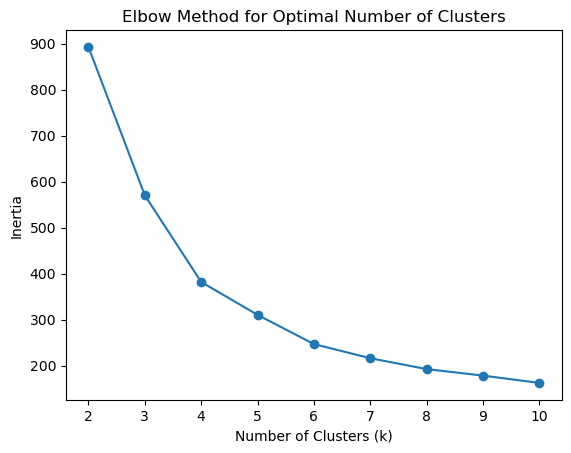

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


# Standardize the features
scaler = StandardScaler()
# Fit and transform X_important
X_important_scaled_array = scaler.fit_transform(X_important)

# Convert the scaled array back to a DataFrame with the original column names
X_important_scaled = pd.DataFrame(X_important_scaled_array, columns=X_important.columns)
# Initialize an empty list to store the inertia (within-cluster sum of squares) values
inertia = []

# Define a range of cluster numbers to test
k_values = range(2, 11)

# Iterate through different cluster numbers
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_important_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


Now check the silhouette method.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

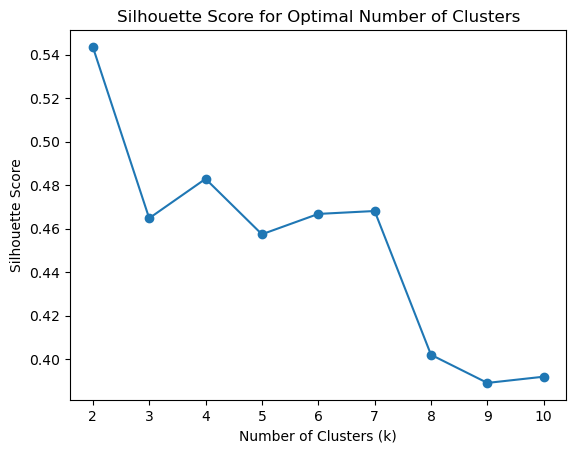

In [74]:
# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Iterate through different cluster numbers
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_important_scaled)
    silhouette_scores.append(silhouette_score(X_important_scaled, labels))

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


Between the two methods, it seems that k = 4 is a good number of clusters, with a decently clear elbow point local maximum silloutette score. Create kmeans clustering algorithm using k = 4.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



Inertia for k = 4: 381.9352951527073


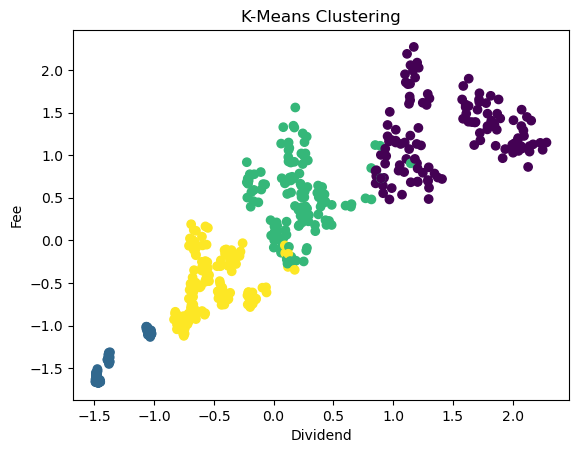

In [75]:
# Create a KMeans clustering model
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the model to the scaled data
kmeans.fit(X_important_scaled)

# Add cluster labels to the DataFrame
X_important_scaled['Cluster'] = kmeans.labels_

# Print the inertia value for k = 4 to show the 'success' level
print(f"Inertia for k = 4: {inertia[2]}")

# Visualize the clustering result (for 2D data)
plt.scatter(X_important_scaled.iloc[:, 0], X_important_scaled.iloc[:, 1], c=X_important_scaled['Cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel(X_important_scaled.columns[0])
plt.ylabel(X_important_scaled.columns[1])
plt.show()

Examine the clusters.

In [76]:
# Extract the 'cluster' column from 'X_important_scaled'
cluster_column = X_important_scaled['Cluster']


# Merge 'cluster_column' with 'df_relevant' based on the index
df_relevant_important_cluster = pd.merge(df_relevant, cluster_column, left_index=True, right_index=True, how='left')
# Merge 'cluster_column' with 'df_encoded' based on the index
df_encoded = pd.merge(df_encoded, cluster_column, left_index=True, right_index=True, how='left')
df_encoded.rename(columns={'Cluster': 'Cluster (Important)'}, inplace=True)


Show which cluster each branch belongs to. Branches that appear more than once can be in a different cluster for different months.

In [77]:
# Count the occurrences of each cluster for each 'BranchCategory'
cluster_counts_important = df_encoded.groupby(['BranchCategory', 'Cluster (Important)']).size().reset_index(name='count')

# Print the results
print(cluster_counts_important)

              BranchCategory  Cluster (Important)  count
0   Addition Financial Arena                    1     14
1          Altamonte Springs                    2     19
2                     Apopka                    0     14
3                     Apopka                    2      5
4                   Clermont                    2     19
5            Downtown Campus                    1     19
6               East Orlando                    0     19
7                     Eustis                    3     19
8                  Fern Park                    2     13
9                  Fern Park                    3      6
10                 Kissimmee                    0     19
11                 Lake Mary                    2     19
12                 Lake Nona                    3     19
13                  Leesburg                    3     19
14                  Longwood                    3     19
15            Merritt Island                    1     19
16                 MetroWest   

In [85]:
df_encoded.

BranchCategory                        object
ATM                                    int64
Bill Payment                           int64
Cash                                   int64
Draft                                  int64
ACH                                    int64
Fee                                    int64
Credit/Debit Card                      int64
Home Banking                           int64
Dividend                               int64
Total_Transactions                     int64
Per Capita Income                      int64
Median Household Income                int64
Median Family Income                   int64
Population                             int64
Number of households                   int64
Total Number of Small Businesses     float64
Number of Credit Unions              float64
Establishments per 1000 residents    float64
County_Brevard                          bool
County_Lake                             bool
County_Orange                           bool
County_Osc

Averages for each feature broken down by cluster.

In [86]:
df_temp = df_encoded.copy()
df_temp.drop(columns=['BranchCategory'], inplace=True)

# Group by 'cluster' and calculate the mean for each column
average_by_cluster_important = df_temp.groupby('Cluster (Important)').mean()

# Print the results
print(average_by_cluster_important)

                            ATM  Bill Payment        Cash       Draft  \
Cluster (Important)                                                     
0                    209.416000    468.800000  108.424000  660.232000   
1                     10.447059     18.247059    6.388235   44.776471   
2                    172.096296    587.392593   93.051852  443.918519   
3                     73.943503    162.694915   37.451977  240.299435   

                             ACH         Fee  Credit/Debit Card  Home Banking  \
Cluster (Important)                                                             
0                    1948.304000  682.472000        3292.344000    963.784000   
1                      78.176471   55.623529         145.317647     46.270588   
2                    1168.244444  506.525926        1935.733333    602.859259   
3                     672.265537  263.355932        1110.723164    347.638418   

                        Dividend  Total_Transactions  ...  \
Cluster (Impo

Same process but with only the 3 most important features, to reduce the curse of dimensionality. This will allow us to fully visualize the clusters in 3D.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

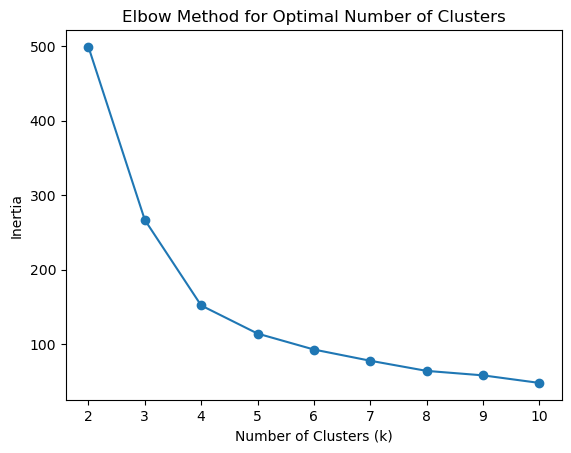

In [87]:
top_3_columns = X_important_scaled.columns[:3]
X_important_reduced_scaled = X_important_scaled[top_3_columns]

# Initialize an empty list to store the inertia (within-cluster sum of squares) values
inertia = []

# Define a range of cluster numbers to test
k_values = range(2, 11)

# Iterate through different cluster numbers
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_important_reduced_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

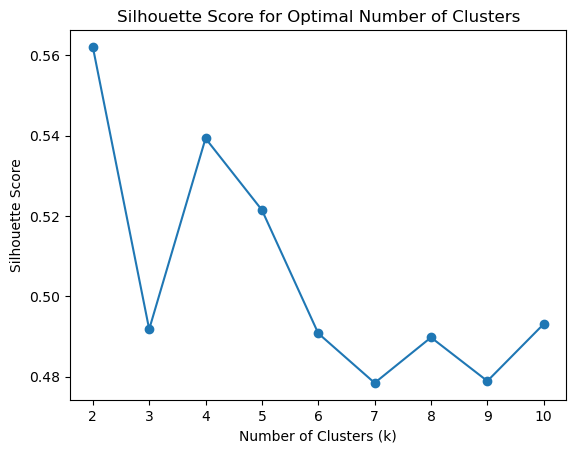

In [88]:
#now using silhouette method
# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Iterate through different cluster numbers
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_important_reduced_scaled)
    silhouette_scores.append(silhouette_score(X_important_reduced_scaled, labels))

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


With the reduced features, our best value of k is still 4.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



Inertia for k = 4: 151.75731871983749


C:\Users\perez\AppData\Local\Temp\ipykernel_14192\4284633092.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



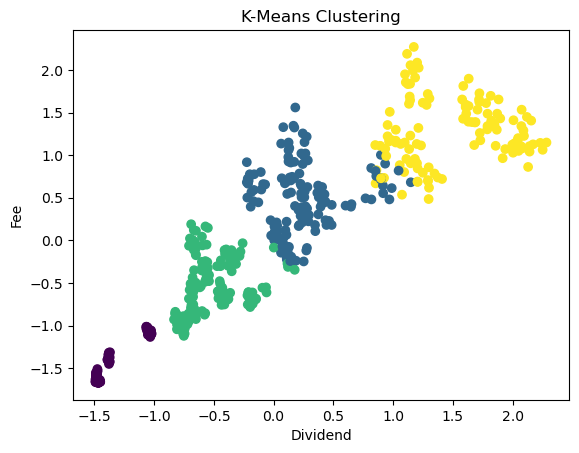

In [89]:
# Create a KMeans clustering model
kmeans = KMeans(n_clusters=4, random_state=42)  # Adjust the number of clusters as needed

# Fit the model to the data
kmeans.fit(X_important_reduced_scaled)

# Add cluster labels to the DataFrame
X_important_reduced_scaled['Cluster'] = kmeans.labels_

# Print the inertia value for k = 4, to show the 'success' level
print(f"Inertia for k = 4: {inertia[2]}")

# Visualize the clustering result (for 2D data)
plt.scatter(X_important_reduced_scaled.iloc[:, 0], X_important_reduced_scaled.iloc[:, 1], c=X_important_reduced_scaled['Cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel(X_important_reduced_scaled.columns[0])
plt.ylabel(X_important_reduced_scaled.columns[1])
plt.show()

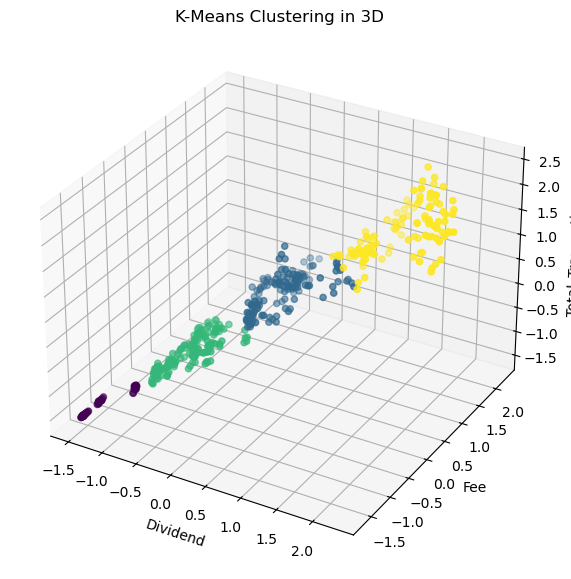

In [90]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Visualize the clustering result in 3D
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with cluster colors
scatter = ax.scatter(X_important_reduced_scaled.iloc[:, 0], X_important_reduced_scaled.iloc[:, 1], X_important_reduced_scaled.iloc[:, 2], c=X_important_reduced_scaled['Cluster'], cmap='viridis')

# Add labels and title
ax.set_xlabel(X_important_reduced_scaled.columns[0])
ax.set_ylabel(X_important_reduced_scaled.columns[1])
ax.set_zlabel(X_important_reduced_scaled.columns[2])
ax.set_title('K-Means Clustering in 3D')

plt.show()

We can see the 4 clusters rather clearly. Let's examine them again.

In [91]:
# Extract the 'cluster' column from 'X_important_reduced_scaled'
cluster_column = X_important_reduced_scaled['Cluster']

# Merge 'cluster_column' with 'df_relevant' based on the index
df_relevant_reduced_cluster = pd.merge(df_relevant, cluster_column, left_index=True, right_index=True, how='left')
df_relevant_reduced_cluster

# Merge 'cluster_column' with 'df_encoded' based on the index
df_encoded = pd.merge(df_encoded, cluster_column, left_index=True, right_index=True, how='left')
df_encoded.rename(columns={'Cluster': 'Cluster (Top 3)'}, inplace=True)

In [92]:
# Count the occurrences of each cluster for each 'BranchCategory'
cluster_counts_top3 = df_encoded.groupby(['BranchCategory', 'Cluster (Top 3)']).size().reset_index(name='count')

# Print the results
print(cluster_counts_top3)

              BranchCategory  Cluster (Top 3)  count
0   Addition Financial Arena                0     14
1          Altamonte Springs                1     18
2          Altamonte Springs                2      1
3                     Apopka                1     12
4                     Apopka                3      7
5                   Clermont                1     19
6            Downtown Campus                0     19
7               East Orlando                3     19
8                     Eustis                2     19
9                  Fern Park                1     15
10                 Fern Park                2      4
11                 Kissimmee                3     19
12                 Lake Mary                1     19
13                 Lake Nona                2     19
14                  Leesburg                2     19
15                  Longwood                2     19
16            Merritt Island                0     19
17                 MetroWest                1 

In [94]:
df_temp = df_encoded.copy()
df_temp.drop(columns=['BranchCategory'], inplace=True)

# Group by 'cluster' and calculate the mean for each column
average_by_cluster_top3 = df_temp.groupby('Cluster (Top 3)').mean()

# Print the results
print(average_by_cluster_top3)

                        ATM  Bill Payment        Cash       Draft  \
Cluster (Top 3)                                                     
0                 10.447059     18.247059    6.388235   44.776471   
1                174.486111    569.423611   89.902778  440.055556   
2                 74.352273    160.255682   36.579545  233.795455   
3                207.572650    482.846154  114.188034  687.820513   

                         ACH         Fee  Credit/Debit Card  Home Banking  \
Cluster (Top 3)                                                             
0                  78.176471   55.623529         145.317647     46.270588   
1                1133.972222  507.590278        1999.576389    602.361111   
2                 639.676136  262.363636        1122.482955    343.392045   
3                2088.606838  692.606838        3281.786325    993.282051   

                    Dividend  Total_Transactions  ...  \
Cluster (Top 3)                                   ...   
0       

Based on the Cluster (Important) values being close to whole numbers, we can see that our 2 clustering methods yielded very similar results. We will use the Top 3 cluster since the results are similar and a simpler model is prefered. Now analyze by county.

In [95]:
df_encoded

BranchCategory  ATM  Bill Payment  Cash  Draft   ACH  Fee  \
0    Addition Financial Arena    0             3     0     28     5   20   
1    Addition Financial Arena    1             0     0     18     8   24   
2    Addition Financial Arena    1             0     0     25     2   19   
3    Addition Financial Arena    0             1     0     18     0   16   
4    Addition Financial Arena    0             0     0     20     2   15   
..                        ...  ...           ...   ...    ...   ...  ...   
517             Winter Garden  267           452   173    574  1204  537   
518             Winter Garden  209           269     0    284     0  506   
519             Winter Garden  214           410   145    803  1992  565   
520             Winter Garden  280           567   185    562  1346  561   
521             Winter Garden  167           448   114    665  2382  576   

     Credit/Debit Card  Home Banking  Dividend  ...  \
0                    6             4        14  ...   
1                   14             0        13  ...   
2                    6             2        13  ...   
3                    5             0        12  ...   
4                    5             1         9  ...   
..                 ...           ...       ...  ...   
517               3481          1025      6698  ...   
518               3458           613      6691  ...   
519               3215           989      6874  ...   
520               3546          1122      6960  ...   
521               2933           774      6809  ...   

     Establishments per 1000 residents  County_Brevard  County_Lake  \
0                                 56.0           False        False   
1                                 56.0           False        False   
2                                 56.0           False        False   
3                                 56.0           False        False   
4                                 56.0           False        False   
..                                 ...             ...          ...   
517                               56.0           False        False   
518                               56.0           False        False   
519                               56.0           False        False   
520                               56.0           False        False   
521                               56.0           False        False   

     County_Orange  County_Osceola  County_Polk  County_Seminole  \
0             True           False        False            False   
1             True           False        False            False   
2             True           False        False            False   
3             True           False        False            False   
4             True           False        False            False   
..             ...             ...          ...              ...   
517           True           False        False            False   
518           True           False        False            False   
519           True           False        False            False   
520           True           False        False            False   
521           True           False        False            False   

     County_Volusia  Cluster (Important)  Cluster (Top 3)  
0             False                    1                0  
1             False                    1                0  
2             False                    1                0  
3             False                    1                0  
4             False                    1                0  
..              ...                  ...              ...  
517           False                    0                3  
518           False                    0                3  
519           False                    0                3  
520           False                    0                3  
521           False                    0                3  

[522 rows x 28 columns]

In [96]:
# Extract columns starting with 'County_'
county_columns = df_encoded.filter(like='County_')

# Concatenate 'Cluster (Top 3)' and the selected county columns
concatenated_df = pd.concat([df_encoded['Cluster (Top 3)'], county_columns], axis=1)

# Count occurrences for each county within each 'Cluster (Top 3)'
county_counts = concatenated_df.groupby('Cluster (Top 3)').sum()

# Display the result
print(county_counts)

                 County_Brevard  County_Lake  County_Orange  County_Osceola  \
Cluster (Top 3)                                                               
0                            19            0             47               0   
1                             0           19             54               0   
2                             0           38             38              19   
3                             0            0             79              38   

                 County_Polk  County_Seminole  County_Volusia  
Cluster (Top 3)                                                
0                          0               19               0  
1                          0               71               0  
2                         19               43              19  
3                          0                0               0  


Now rewrite the cluster numbers to be in ascending order based on our top 3 factors (standardized)

In [97]:
# Create a copy of the DataFrame for standardization
df_encoded_copy = df_encoded.copy()

# Select columns for standard scaling
columns_to_scale = top_3_columns

# Standard scale the selected columns in the copy
scaler = StandardScaler()
df_encoded_copy[columns_to_scale] = scaler.fit_transform(df_encoded_copy[columns_to_scale])

In [98]:
# Group by 'Cluster' and calculate the average for each group
cluster_means = df_encoded_copy.groupby('Cluster (Top 3)')[columns_to_scale].mean()

# Rename the clusters based on the average values in ascending order
average_order = cluster_means.mean(axis=1).sort_values().index
cluster_mapping = {cluster: new_cluster for cluster, new_cluster in zip(average_order, range(len(average_order)))}
df_encoded_copy['Cluster (Top 3)'] = df_encoded_copy['Cluster (Top 3)'].map(cluster_mapping)

In [99]:
# Extract columns starting with 'County_'
county_columns = df_encoded_copy.filter(like='County_')

# Concatenate 'Cluster (Top 3)' and the selected county columns
concatenated_df = pd.concat([df_encoded_copy['Cluster (Top 3)'], county_columns], axis=1)

# Count occurrences for each county within each 'Cluster (Top 3)'
county_counts = concatenated_df.groupby('Cluster (Top 3)').sum()

# Display the result
print(county_counts)


                 County_Brevard  County_Lake  County_Orange  County_Osceola  \
Cluster (Top 3)                                                               
0                            19            0             47               0   
1                             0           38             38              19   
2                             0           19             54               0   
3                             0            0             79              38   

                 County_Polk  County_Seminole  County_Volusia  
Cluster (Top 3)                                                
0                          0               19               0  
1                         19               43              19  
2                          0               71               0  
3                          0                0               0  


With some simple math, we can see that the counties with the best performing branches are likely Seminole (average value 1.39), Osceola (2.33), and Orange (1.76). Additionally, for Orange County, the 47 instances in cluster 0 are the Addition Financial Arena, UCF Commons, and UCF Downtown, which are not normal branches. If  we remove those from its cluster score, Orange County now has an average of 2.24. If we look into employment and wage data for those counties, Orange county, compared to Osceola, has nearly 9 times the amount of people employed who also make around 4,000 dollars more per quarter ($16,000 per year). This would lead to the conclusion of expanding with another branch in Orange County.

https://www.floridajobs.org/workforce-statistics/data-center/statistical-programs/quarterly-census-of-employment-and-wages


To see validity of weighting the clusters and showing that branches in cluster 3 are notably better than the others, we can look at the averages of those clusters. We can see below that cluster 3 branches average much higher numbers for the the most relevant differentiators. It is also worth noting that cluster 3 branches are also located in counties that already contain more credit unions. While this may add some validity to the results, it also implies that these areas will have more competition.

In [102]:
#inverse the scaler to see the averages for each cluster
df_encoded_copy[columns_to_scale] = scaler.inverse_transform(df_encoded_copy[columns_to_scale])

df_encoded_copy_copy = df_encoded_copy.copy()
df_encoded_copy_copy.drop(columns=['BranchCategory'], inplace=True)

# Group by 'cluster' and calculate the mean for each column
average_by_cluster_top3 = df_encoded_copy_copy.groupby('Cluster (Top 3)').mean()

# Print columns excluding those that start with 'County'
filtered_columns = average_by_cluster_top3.filter(regex='^(?!County)')
print(filtered_columns)

                        ATM  Bill Payment        Cash       Draft  \
Cluster (Top 3)                                                     
0                 10.447059     18.247059    6.388235   44.776471   
1                 74.352273    160.255682   36.579545  233.795455   
2                174.486111    569.423611   89.902778  440.055556   
3                207.572650    482.846154  114.188034  687.820513   

                         ACH           Fee  Credit/Debit Card  Home Banking  \
Cluster (Top 3)                                                               
0                  78.176471  3.125329e+06         145.317647     46.270588   
1                 639.676136  1.439910e+07        1122.482955    343.392045   
2                1133.972222  2.777159e+07        1999.576389    602.361111   
3                2088.606838  3.786075e+07        3281.786325    993.282051   

                     Dividend  Total_Transactions  Per Capita Income  \
Cluster (Top 3)                       

# XXXXX

•	EDA: Explore multicollinearity using variance inflation factors, pinpoint heteroscedasticity, and delineate variable relationships.

In [111]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [112]:
branch_level_data = pd.read_csv('data/Branch_Level_Dataset.csv')
branch_level_data.head(5)

EOM_TRANS_DATE            BranchCategory  ATM  Bill Payment  Cash  Draft  \
0     2022-01-31  Addition Financial Arena    0             3     0     28   
1     2022-01-31         Altamonte Springs   98           394    64    469   
2     2022-01-31                    Apopka  198           540   132    705   
3     2022-01-31         Boone High School    1            10     2      8   
4     2022-01-31                  Clermont  143           482   103    499   

    ACH  Fee  Credit/Debit Card  Home Banking  Dividend  
0     5   20                  6             4        14  
1  1589  416               1642           646      3650  
2  2219  560               1983           724      5731  
3    30    9                 80            21        59  
4  1940  539               1834           580      4551

In [113]:
# Remove rows where BranchCategory is 'High School' or 'Virtual Branch'
branch_level_data = branch_level_data[~branch_level_data['BranchCategory'].str.contains("High School|Virtual Branch|UCF Commons|Addition Financial Arena")]

# Check for null values in the DataFrame
null_values = branch_level_data.isnull().sum()

# Displaying the DataFrame and the null values information
print(branch_level_data.head())
print(null_values)


  EOM_TRANS_DATE     BranchCategory  ATM  Bill Payment  Cash  Draft   ACH  \
1     2022-01-31  Altamonte Springs   98           394    64    469  1589   
2     2022-01-31             Apopka  198           540   132    705  2219   
4     2022-01-31           Clermont  143           482   103    499  1940   
6     2022-01-31    Downtown Campus   27            35    12     62   134   
7     2022-01-31       East Orlando  165           701   106    836  3325   

   Fee  Credit/Debit Card  Home Banking  Dividend  
1  416               1642           646      3650  
2  560               1983           724      5731  
4  539               1834           580      4551  
6   78                227            47       275  
7  789               2993          1057      7938  
EOM_TRANS_DATE       0
BranchCategory       0
ATM                  0
Bill Payment         0
Cash                 0
Draft                0
ACH                  0
Fee                  0
Credit/Debit Card    0
Home Banking      

In [114]:
import pandas as pd

# Load the Excel file
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only the 'County' and 'TOTAL - All Revenue Account Codes' columns
# Assuming these are the first and the third-last columns in your DataFrame
df_revenue = df_revenue.iloc[:, [0, -3]]

# Renaming the columns for clarity
df_revenue.columns = ['County', 'Revenue_Per_County']

# Dropping the first row if it contains headers from the original table
df_revenue = df_revenue.drop(0)

# Displaying the modified DataFrame
print(df_revenue.head())



     County Revenue_Per_County
1   Alachua         1082349199
2     Baker           89157684
3       Bay         1193216378
4  Bradford           85933027
5   Brevard          958971976


In [115]:
import pandas as pd

# Map BranchCategory to County
city_to_county_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}

branch_level_data['County'] = branch_level_data['BranchCategory'].map(city_to_county_mapping)

# Load revenue data
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only 'County' and 'TOTAL - All Revenue Account Codes' columns
df_revenue = df_revenue.iloc[:, [0, -3]]
df_revenue.columns = ['County', 'Revenue_Per_County']
df_revenue = df_revenue.drop(0)

# Merging the DataFrames
branch_level_data = pd.merge(branch_level_data, df_revenue, on='County', how='left')

# Displaying the combined DataFrame
print(branch_level_data.head())


  EOM_TRANS_DATE     BranchCategory  ATM  Bill Payment  Cash  Draft   ACH  \
0     2022-01-31  Altamonte Springs   98           394    64    469  1589   
1     2022-01-31             Apopka  198           540   132    705  2219   
2     2022-01-31           Clermont  143           482   103    499  1940   
3     2022-01-31    Downtown Campus   27            35    12     62   134   
4     2022-01-31       East Orlando  165           701   106    836  3325   

   Fee  Credit/Debit Card  Home Banking  Dividend    County Revenue_Per_County  
0  416               1642           646      3650  Seminole         1830400546  
1  560               1983           724      5731    Orange         6968835122  
2  539               1834           580      4551      Lake         1003940427  
3   78                227            47       275    Orange         6968835122  
4  789               2993          1057      7938    Orange         6968835122  


            Variable        VIF
0                ATM  31.967666
1       Bill Payment   1.764924
2               Cash  14.576531
3              Draft  57.956488
4                ACH  23.411729
5                Fee  46.507688
6  Credit/Debit Card  32.471129
7       Home Banking  46.806628
8           Dividend  47.214718


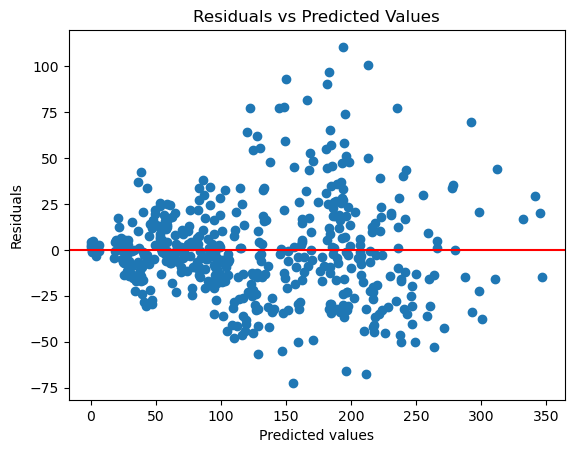

In [116]:
# Creating a copy of branch_level_data for VIF calculation
branch_level_data_copy = branch_level_data.copy()

# Dropping non-numeric columns for VIF calculation
features = branch_level_data_copy.drop(columns=['EOM_TRANS_DATE', 'BranchCategory', 'County', 'Revenue_Per_County'])

vif_data = pd.DataFrame()
vif_data["Variable"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
print(vif_data)

# Dropping a column from the copy for regression analysis
X = features.drop(columns=['ATM'])
y = branch_level_data_copy['ATM']
X = sm.add_constant(X)  # Adding a constant for the intercept

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
residuals = y - predictions

# Plotting Residuals vs Predicted Values
plt.scatter(predictions, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='-')  # Adding a horizontal line at y=0 for reference
plt.show()


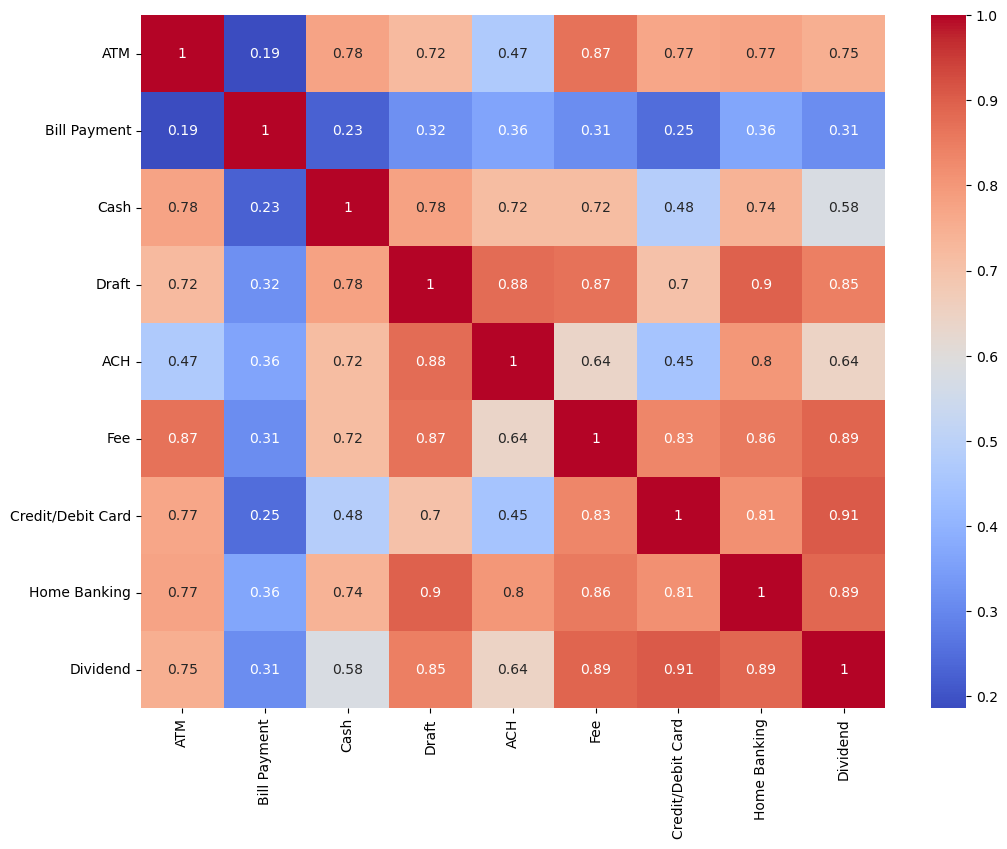

In [117]:
# Using a heatmap to visualize correlations
correlation_matrix = features.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


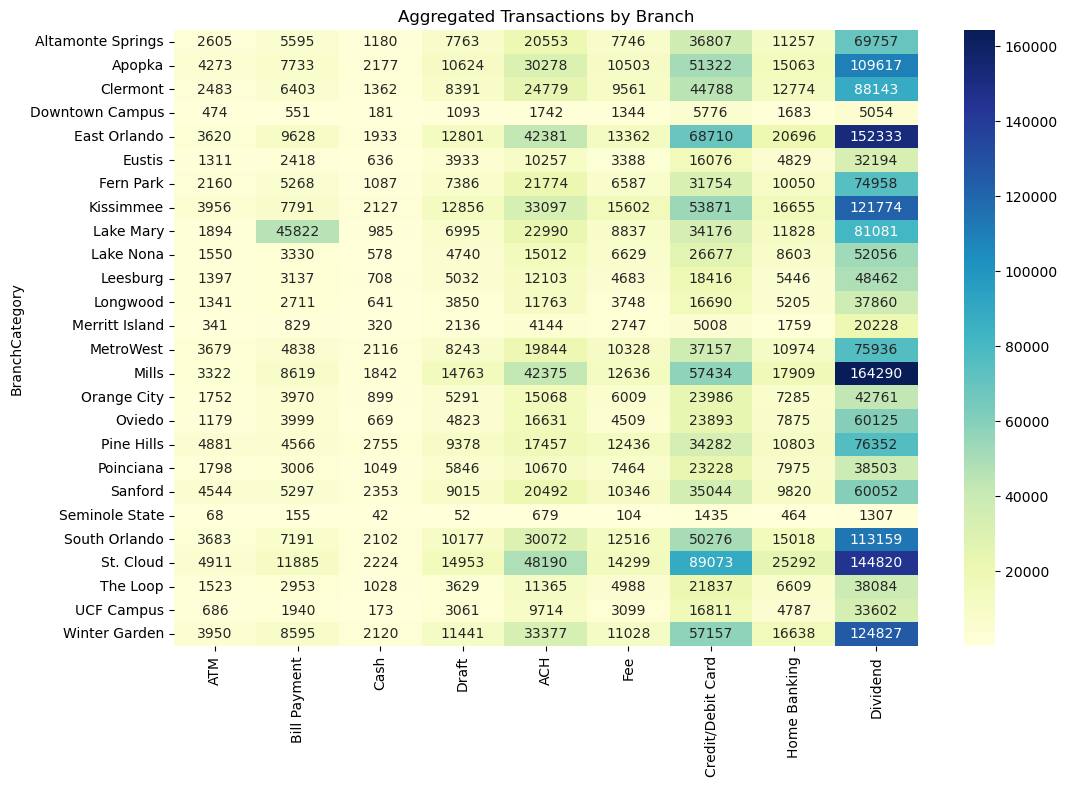

In [118]:
# Creating a separate copy for the heatmap visualization
branch_level_data_for_heatmap = branch_level_data.copy()

branch_level_data_for_heatmap = branch_level_data_for_heatmap.drop(['EOM_TRANS_DATE', 'County', 'Revenue_Per_County'], axis=1)

# Aggregating data by BranchCategory
branch_level_data_for_heatmap = branch_level_data_for_heatmap.groupby("BranchCategory").sum()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(branch_level_data_for_heatmap, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Aggregated Transactions by Branch")
plt.show()


In [119]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Create a copy of the DataFrame to use for the analysis
branch_level_data_copy = branch_level_data.copy()

# Selecting features and target variable
# Drop non-feature columns and the target 'Revenue_Per_County' column
X = branch_level_data_copy.drop(columns=['Revenue_Per_County', 'EOM_TRANS_DATE', 'BranchCategory', 'County'])
y = branch_level_data_copy['Revenue_Per_County']

# Convert 'Revenue_Per_County' to numeric, in case it's not
y = pd.to_numeric(y, errors='coerce')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Coefficient of Determination (R^2):', r2_score(y_test, y_pred))

# Optionally, print the coefficients for each feature
feature_coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(feature_coefficients)



Mean Squared Error: 6.31973809787383e+18
Coefficient of Determination (R^2): 0.17238557367881435
                    Coefficient
ATM                9.823840e+06
Bill Payment      -6.186985e+05
Cash               1.014348e+07
Draft             -6.268392e+06
ACH                5.743753e+05
Fee               -9.672007e+05
Credit/Debit Card -1.153158e+06
Home Banking      -2.917264e+06
Dividend           1.430058e+06


In [120]:
branch_level_data

EOM_TRANS_DATE     BranchCategory  ATM  Bill Payment  Cash  Draft   ACH  \
0       2022-01-31  Altamonte Springs   98           394    64    469  1589   
1       2022-01-31             Apopka  198           540   132    705  2219   
2       2022-01-31           Clermont  143           482   103    499  1940   
3       2022-01-31    Downtown Campus   27            35    12     62   134   
4       2022-01-31       East Orlando  165           701   106    836  3325   
..             ...                ...  ...           ...   ...    ...   ...   
489     2023-07-31      South Orlando  158           396   130    615  2166   
490     2023-07-31          St. Cloud  208           623   145    846  3279   
491     2023-07-31           The Loop   66           155    68    210   871   
492     2023-07-31         UCF Campus   30            92    11    153   715   
493     2023-07-31      Winter Garden  167           448   114    665  2382   

     Fee  Credit/Debit Card  Home Banking  Dividend    County  \
0    416               1642           646      3650  Seminole   
1    560               1983           724      5731    Orange   
2    539               1834           580      4551      Lake   
3     78                227            47       275    Orange   
4    789               2993          1057      7938    Orange   
..   ...                ...           ...       ...       ...   
489  661               2600           752      6210    Orange   
490  779               4750          1269      8096   Osceola   
491  287               1206           378      2218   Osceola   
492  192                839           250      1867    Orange   
493  576               2933           774      6809    Orange   

    Revenue_Per_County  
0           1830400546  
1           6968835122  
2           1003940427  
3           6968835122  
4           6968835122  
..                 ...  
489         6968835122  
490         1592120547  
491         1592120547  
492         6968835122  
493         6968835122  

[494 rows x 13 columns]

In [121]:
unique_branch_categories = branch_level_data['BranchCategory'].unique()
number_of_unique_branch_categories = len(unique_branch_categories)

# Output the unique values
print("Unique Branch Categories:", unique_branch_categories)

# Output the number of unique values
print("Number of Unique Branch Categories:", number_of_unique_branch_categories)


Unique Branch Categories: ['Altamonte Springs' 'Apopka' 'Clermont' 'Downtown Campus' 'East Orlando'
 'Eustis' 'Fern Park' 'Kissimmee' 'Lake Mary' 'Lake Nona' 'Leesburg'
 'Longwood' 'Merritt Island' 'MetroWest' 'Mills' 'Orange City' 'Oviedo'
 'Pine Hills' 'Poinciana' 'Sanford' 'Seminole State' 'South Orlando'
 'St. Cloud' 'The Loop' 'UCF Campus' 'Winter Garden']
Number of Unique Branch Categories: 26


In [122]:
branch_count = branch_level_data.groupby('County')['BranchCategory'].nunique()
branch_count.name = 'Branch_Count'

# Aggregate the transaction data by the 'County' column, summing up all the transaction-related columns
county_transactions_agg = branch_level_data.groupby('County').agg({
    'ATM': 'sum',
    'Bill Payment': 'sum',
    'Cash': 'sum',
    'Draft': 'sum',
    'ACH': 'sum',
    'Fee': 'sum',
    'Credit/Debit Card': 'sum',
    'Home Banking': 'sum',
    'Dividend': 'sum'
}).reset_index()

# Calculate the total transactions per county
county_transactions_agg['Total_Transactions'] = county_transactions_agg.drop('County', axis=1).sum(axis=1)

# Calculate the average transactions per branch for each county
county_transactions_agg = county_transactions_agg.merge(branch_count.reset_index(), on='County')
county_transactions_agg['Average_Transactions_Per_Branch'] = county_transactions_agg['Total_Transactions'] / county_transactions_agg['Branch_Count']

# Display the DataFrame with total and average transactions
county_transactions_agg[['County', 'Total_Transactions', 'Branch_Count', 'Average_Transactions_Per_Branch']]



County  Total_Transactions  Branch_Count  Average_Transactions_Per_Branch
0   Brevard               37512             1                          37512.0
1      Lake              373110             3                         124370.0
2    Orange             1960542            10                         196054.2
3   Osceola              715392             3                         238464.0
4      Polk               99539             1                          99539.0
5  Seminole              907676             7                         129668.0
6   Volusia              107021             1                         107021.0

     County  Total_Transactions  Branch_Count  Average_Transactions_Per_Branch
3   Osceola              715392             3                         238464.0
2    Orange             1960542            10                         196054.2
5  Seminole              907676             7                         129668.0
1      Lake              373110             3                         124370.0
6   Volusia              107021             1                         107021.0
4      Polk               99539             1                          99539.0
0   Brevard               37512             1                          37512.0


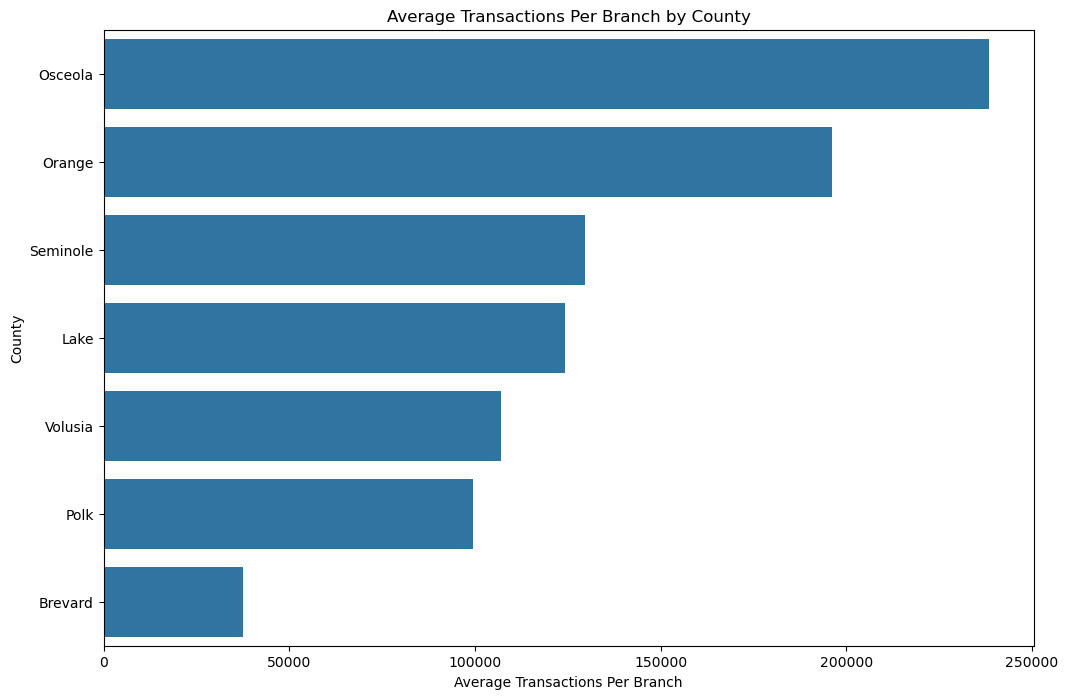

In [123]:
# Sorting counties by the average transactions per branch
county_transactions_agg_sorted = county_transactions_agg.sort_values(by='Average_Transactions_Per_Branch', ascending=False)

# Displaying the counties with their average transaction data per branch
print(county_transactions_agg_sorted[['County', 'Total_Transactions', 'Branch_Count', 'Average_Transactions_Per_Branch']])

# Visualization - Average Transactions per Branch by County
plt.figure(figsize=(12, 8))
sns.barplot(y=county_transactions_agg_sorted['County'], x=county_transactions_agg_sorted['Average_Transactions_Per_Branch'])
plt.title('Average Transactions Per Branch by County')
plt.ylabel('County')
plt.xlabel('Average Transactions Per Branch')
plt.show()


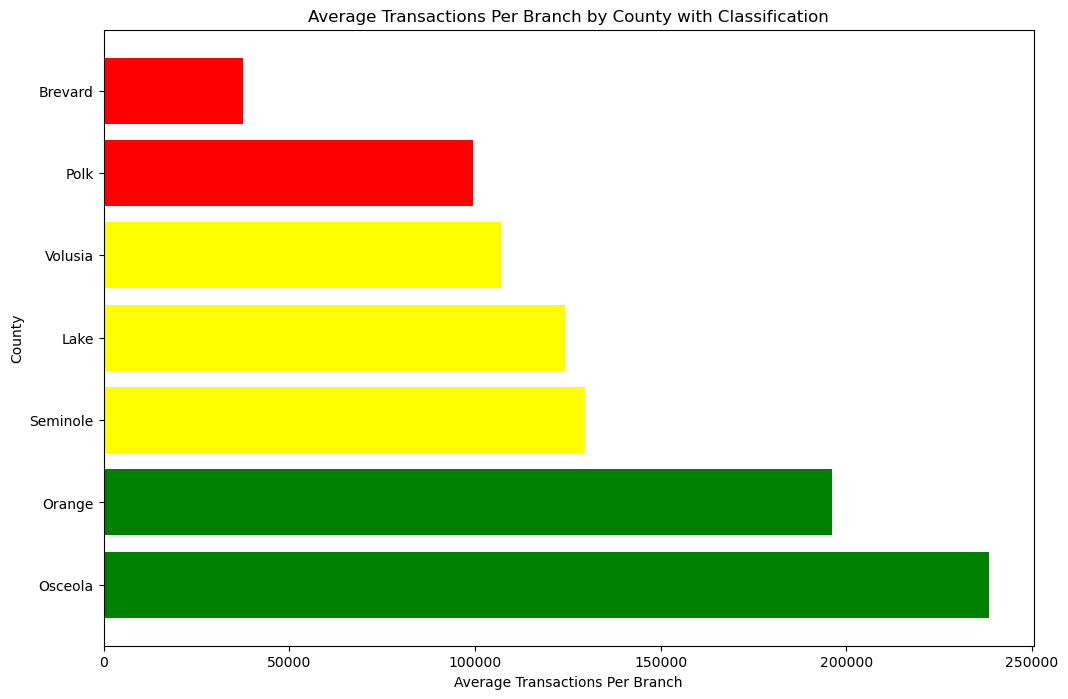

In [124]:
# Define classification thresholds
high_threshold = county_transactions_agg_sorted['Average_Transactions_Per_Branch'].quantile(0.75) # top 25%
medium_threshold = county_transactions_agg_sorted['Average_Transactions_Per_Branch'].quantile(0.25) # bottom 25%

# Classify counties
county_transactions_agg_sorted['Classification'] = 'Low'
county_transactions_agg_sorted.loc[county_transactions_agg_sorted['Average_Transactions_Per_Branch'] >= medium_threshold, 'Classification'] = 'Medium'
county_transactions_agg_sorted.loc[county_transactions_agg_sorted['Average_Transactions_Per_Branch'] >= high_threshold, 'Classification'] = 'High'

# Visualize the classified data
colors = {'Low': 'red', 'Medium': 'yellow', 'High': 'green'}
plt.figure(figsize=(12, 8))
plt.barh(county_transactions_agg_sorted['County'], county_transactions_agg_sorted['Average_Transactions_Per_Branch'], color=[colors[cls] for cls in county_transactions_agg_sorted['Classification']])
plt.title('Average Transactions Per Branch by County with Classification')
plt.xlabel('Average Transactions Per Branch')
plt.ylabel('County')
plt.show()


In [125]:
import requests

def get_coordinates(county_name):
    county_name_formatted = county_name.replace(' ', '+') + ',+Florida'
    url = f"https://nominatim.openstreetmap.org/search?q={county_name_formatted}&format=json"
    response = requests.get(url)
    data = response.json()
    latitude = data[0]['lat']
    longitude = data[0]['lon']
    return latitude, longitude

# List of counties
counties = ['Orange', 'Seminole', 'Lake', 'Osceola', 'Brevard', 'Volusia', 'Polk']

# Fetching and printing coordinates for each county
for county in counties:
    latitude, longitude = get_coordinates(county + ' County')
    print(f"The coordinates for {county} County are Latitude: {latitude} and Longitude: {longitude}")



The coordinates for Orange County are Latitude: 28.5421109 and Longitude: -81.3790304
The coordinates for Seminole County are Latitude: 28.7225829 and Longitude: -81.2353683
The coordinates for Lake County are Latitude: 28.7006859 and Longitude: -81.78994
The coordinates for Osceola County are Latitude: 28.0443842 and Longitude: -81.1437541
The coordinates for Brevard County are Latitude: 28.2100203 and Longitude: -80.7997185
The coordinates for Volusia County are Latitude: 29.0533409 and Longitude: -81.1310761
The coordinates for Polk County are Latitude: 27.9448537 and Longitude: -81.7268789


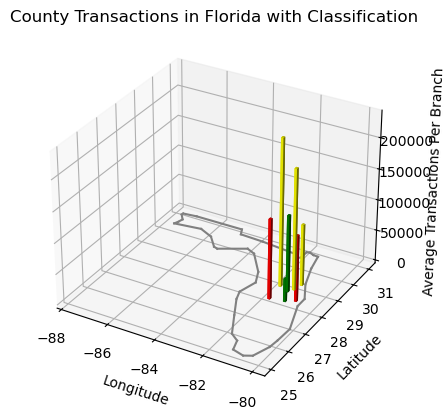

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

states = gpd.read_file('Florida_shape/ne_110m_admin_1_states_provinces.shp')
florida = states[states['name'] == 'Florida']
florida_boundary = florida.geometry.values[0].exterior.coords.xy
florida_x = list(florida_boundary[0])
florida_y = list(florida_boundary[1])

County_Coordinates = {
    'Osceola': (28.0443842, -81.1437541),
    'Orange': (28.5421109, -81.3790304),
    'Seminole': (28.7225829, -81.2353683),
    'Lake': (28.7006859, -81.78994),
    'Volusia': (29.0533409, -81.1310761),
    'Polk': (27.9448537, -81.7268789),
    'Brevard': (28.2100203, -80.7997185)
}

# Define classification thresholds and colors
high_threshold = county_transactions_agg_sorted['Average_Transactions_Per_Branch'].quantile(0.75)
medium_threshold = county_transactions_agg_sorted['Average_Transactions_Per_Branch'].quantile(0.25)
county_transactions_agg_sorted['Classification'] = 'Low'
county_transactions_agg_sorted.loc[county_transactions_agg_sorted['Average_Transactions_Per_Branch'] >= medium_threshold, 'Classification'] = 'Medium'
county_transactions_agg_sorted.loc[county_transactions_agg_sorted['Average_Transactions_Per_Branch'] >= high_threshold, 'Classification'] = 'High'
colors = {'Low': 'red', 'Medium': 'yellow', 'High': 'green'}

# Extract x, y, z data for counties
x = [County_Coordinates[county][1] for county in county_transactions_agg_sorted['County']]  # longitude
y = [County_Coordinates[county][0] for county in county_transactions_agg_sorted['County']]  # latitude
z = county_transactions_agg_sorted['Average_Transactions_Per_Branch']
color_map = [colors[cls] for cls in county_transactions_agg_sorted['Classification']]

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the shape of Florida
for i in range(len(florida_x) - 1):
    ax.plot([florida_x[i], florida_x[i+1]], 
            [florida_y[i], florida_y[i+1]], 
            [0, 0], color='gray')

# Plot each county's data as a colored pillar
for i in range(len(x)):
    ax.bar3d(x[i], y[i], 0, 0.1, 0.1, z[i], color=color_map[i], shade=True)

# Labeling and titles
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Average Transactions Per Branch')
ax.set_title('County Transactions in Florida with Classification')

plt.show()



In [127]:
county_transactions_agg_sorted

County    ATM  Bill Payment   Cash  Draft     ACH    Fee  \
3   Osceola  10390         22629   5379  31438   92652  34889   
2    Orange  30118         56991  15977  86321  242252  93881   
5  Seminole  13791         68847   6957  39884  114882  41877   
1      Lake   5191         11958   2706  17356   47139  17632   
6   Volusia   1752          3970    899   5291   15068   6009   
4      Polk   1798          3006   1049   5846   10670   7464   
0   Brevard    341           829    320   2136    4144   2747   

   Credit/Debit Card  Home Banking  Dividend  Total_Transactions  \
3             164781         48556    304678              715392   
2             405602        122174    907226             1960542   
5             179799         56499    385140              907676   
1              79280         23049    168799              373110   
6              23986          7285     42761              107021   
4              23228          7975     38503               99539   
0               5008          1759     20228               37512   

   Branch_Count  Average_Transactions_Per_Branch Classification  
3             3                         238464.0           High  
2            10                         196054.2           High  
5             7                         129668.0         Medium  
1             3                         124370.0         Medium  
6             1                         107021.0         Medium  
4             1                          99539.0            Low  
0             1                          37512.0            Low

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

population_data = pd.read_csv('data/Population_Data.csv')

# Correct the column name after loading the data
population_data.rename(columns={'name': 'County'}, inplace=True)

# Remove the word "County" from the 'County' column to match county_transactions_agg_sorted
population_data['County'] = population_data['County'].str.replace(' County', '')


# Correct the column name after loading the data
population_data.rename(columns={'name': 'County'}, inplace=True)

# Filter for the counties of interest and calculate the average population
counties_of_interest = ['Orange', 'Seminole', 'Lake', 'Osceola', 'Brevard', 'Volusia', 'Polk']
population_data = population_data[population_data['County'].isin(counties_of_interest)]
population_data['Average_Population'] = population_data.loc[:, 'pop2010':'pop2023'].mean(axis=1)

# Merge this average population data with your transactions data
county_transactions_agg_sorted = county_transactions_agg_sorted.merge(
    population_data[['County', 'Average_Population']],
    on='County'
)

# Calculate the average transactions per capita
county_transactions_agg_sorted['Transactions_Per_Capita'] = (
    county_transactions_agg_sorted['Average_Transactions_Per_Branch'] /
    county_transactions_agg_sorted['Average_Population']
)

Osceola: Classification - High, Transactions Per Capita - 0.6878782459197037
Orange: Classification - High, Transactions Per Capita - 0.14735106343400667
Seminole: Classification - Medium, Transactions Per Capita - 0.2856073020739723
Lake: Classification - Medium, Transactions Per Capita - 0.3517858001521756
Volusia: Classification - Medium, Transactions Per Capita - 0.20082359045280587
Polk: Classification - Low, Transactions Per Capita - 0.14594883088738778
Brevard: Classification - Low, Transactions Per Capita - 0.06418012592389817


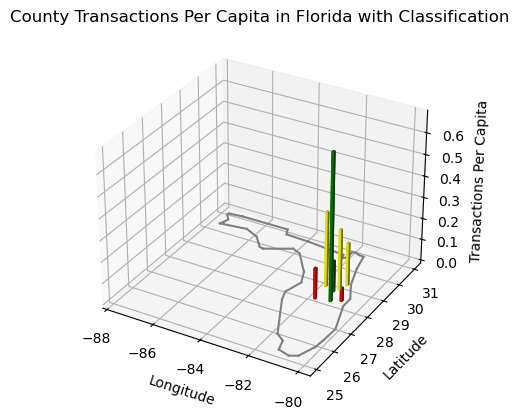

In [129]:
# Print classifications and transactions per capita for each county
for index, row in county_transactions_agg_sorted.iterrows():
    print(f"{row['County']}: Classification - {row['Classification']}, "
          f"Transactions Per Capita - {row['Transactions_Per_Capita']}")

z = county_transactions_agg_sorted['Transactions_Per_Capita']

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the shape of Florida
for i in range(len(florida_x) - 1):
    ax.plot([florida_x[i], florida_x[i+1]], [florida_y[i], florida_y[i+1]], [0, 0], color='gray')

# Plot each county's average transactions per capita as a colored pillar
for i in range(len(x)):
    ax.bar3d(x[i], y[i], 0, 0.1, 0.1, z[i], color=color_map[i], shade=True)

# Labeling and titles
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions Per Capita')
ax.set_title('County Transactions Per Capita in Florida with Classification')

plt.show()


In [130]:
county_transactions_agg_sorted

County    ATM  Bill Payment   Cash  Draft     ACH    Fee  \
0   Osceola  10390         22629   5379  31438   92652  34889   
1    Orange  30118         56991  15977  86321  242252  93881   
2  Seminole  13791         68847   6957  39884  114882  41877   
3      Lake   5191         11958   2706  17356   47139  17632   
4   Volusia   1752          3970    899   5291   15068   6009   
5      Polk   1798          3006   1049   5846   10670   7464   
6   Brevard    341           829    320   2136    4144   2747   

   Credit/Debit Card  Home Banking  Dividend  Total_Transactions  \
0             164781         48556    304678              715392   
1             405602        122174    907226             1960542   
2             179799         56499    385140              907676   
3              79280         23049    168799              373110   
4              23986          7285     42761              107021   
5              23228          7975     38503               99539   
6               5008          1759     20228               37512   

   Branch_Count  Average_Transactions_Per_Branch Classification  \
0             3                         238464.0           High   
1            10                         196054.2           High   
2             7                         129668.0         Medium   
3             3                         124370.0         Medium   
4             1                         107021.0         Medium   
5             1                          99539.0            Low   
6             1                          37512.0            Low   

   Average_Population  Transactions_Per_Capita  
0            346666.0                 0.687878  
1           1330524.5                 0.147351  
2            454008.0                 0.285607  
3            353539.0                 0.351786  
4            532910.5                 0.200824  
5            682013.0                 0.145949  
6            584480.0                 0.064180

In [131]:
import requests

def get_coordinates(address):
    try:
        address_formatted = address.replace(' ', '+') + ',+Florida'
        url = f"https://nominatim.openstreetmap.org/search?q={address_formatted}&format=json"
        response = requests.get(url)
        data = response.json()
        if not data:
            return 'No data', 'No data'
        latitude = data[0]['lat']
        longitude = data[0]['lon']
        return latitude, longitude
    except Exception as e:
        return f'Error: {e}', f'Error: {e}'
    
    # List of all 27 branch addresses
branch_addresses = [
    '1000 Primera Blvd, Lake Mary, FL 32746',  # Lake Mary Branch
    '847 S Orange Blossom Trail, Apopka, FL 32703',  # Apopka Branch
    '1948 W County Road 419, Chuluota, FL 32766',  # Oviedo Branch
    '2390 E Highway 50, Clermont, FL 34711',  # Clermont Branch
    '15830 US Highway 441, Eustis, FL 32726',  # Eustis Branch
    '215 Oxford Rd, Fern Park, FL 32730',  # Fern Park Branch
    '855 S State Road 434, Forest City, FL 32714',  # Altamonte Springs Branch
    '708 E Vine St, Kissimmee, FL 34744',  # Kissimmee Branch
    '3070 N Orange Blossom Trail, Kissimmee, FL 34741',  # The Loop Branch
    '4620 Pleasant Hill Rd, Kissimmee, FL 34759',  # Poinciana Branch
    '8040 US Highway 441, Leesburg, FL 34788',  # Leesburg Branch
    '901 E State Road 434, Longwood, FL 32750',  # Longwood Branch
    '1380 N Courtenay Pkwy, Merritt Island, FL 32953',  # Merritt Island Branch
    '920 Saxon Blvd, Orange City, FL 32763',  # Orange City Branch
    '13810 Narcoossee Rd, Orlando, FL 32832',  # Lake Nona Branch
    '12795 Aquaris Agora Dr, Orlando, FL 32816',  # UCF Campus Branch
    '5301 S Orange Ave, Orlando, FL 32809',  # South Orlando Branch
    '947 N Mills Ave, Orlando, FL 32803',  # Mills Branch
    '5990 MetroWest Blvd, Orlando, FL 32835',  # Metro West Branch
    '4601 Silver Star Rd, Orlando, FL 32808',  # Pine Hills Branch
    '101 E 25th St, Sanford, FL 32771',  # Sanford Branch
    '101 E 25th St, Sanford, FL 32771',  # Seminole State Branch
    '3335 13th St, Saint Cloud, FL 34769',  # St. Cloud Branch
    '950 9th St, Winter Garden, FL 34787',  # Winter Garden Branch
    '617 W Livingston St, Orlando, FL 32801',  # Downtown Campus Branch
    '1823 N Alafaya Trail, Orlando, FL 32826',  # East Orlando Branch
]

# List to store results
results = []

# Fetching coordinates for each branch
for address in branch_addresses:
    latitude, longitude = get_coordinates(address)
    results.append({'Address': address, 'Latitude': latitude, 'Longitude': longitude})

# Convert the list to a DataFrame
df_coordinates = pd.DataFrame(results)

# Display the DataFrame
print(df_coordinates)

# Print addresses with 'No data' coordinates
print("Addresses without coordinates:")
print(df_coordinates[df_coordinates['Latitude'] == 'No data']['Address'])



                                             Address           Latitude  \
0             1000 Primera Blvd, Lake Mary, FL 32746  28.76514713597197   
1       847 S Orange Blossom Trail, Apopka, FL 32703         28.6688026   
2         1948 W County Road 419, Chuluota, FL 32766            No data   
3              2390 E Highway 50, Clermont, FL 34711         28.5473196   
4             15830 US Highway 441, Eustis, FL 32726         28.8224177   
5                 215 Oxford Rd, Fern Park, FL 32730            No data   
6        855 S State Road 434, Forest City, FL 32714            No data   
7                 708 E Vine St, Kissimmee, FL 34744          28.304381   
8   3070 N Orange Blossom Trail, Kissimmee, FL 34741         28.3219603   
9         4620 Pleasant Hill Rd, Kissimmee, FL 34759            No data   
10           8040 US Highway 441, Leesburg, FL 34788         28.8218183   
11          901 E State Road 434, Longwood, FL 32750         28.6977684   
12   1380 N Courtenay Pkw

1948 W County Road 419, Chuluota, FL 32766, Lat: 28.655315, Long: -81.169944

215 Oxford Rd, Fern Park, FL 32730, Lat: 28.655927,  Long: -81.339953

855 S State Road 434, Forest City, FL 32714, Lat: 28.665416 , Long: -81.419095

4620 Pleasant Hill Rd, Kissimmee, FL 34759, Lat: 28.085617 , Long: -81.517654

901 E State Road 434, Longwood, FL 32750, Lat: 28.697926 , Long: -81.330179

12795 Aquaris Agora Dr, Orlando, FL 32816, Lat: 28.603338, Long: -81.20376

947 N Mills Ave, Orlando, FL 32803, Lat: 28.55761 , Long: -81.364377

617 W Livingston St, Orlando, FL 32801, Lat: 28.547566 , Long: -81.372652

1823 N Alafaya Trail, Orlando, FL 32826, Lat: 28.569098, Long: -81.207569

In [132]:
# Dictionary of addresses with manual coordinates
manual_coordinates = {
    '1948 W County Road 419, Chuluota, FL 32766': (28.655315, -81.169944),
    '215 Oxford Rd, Fern Park, FL 32730': (28.655927, -81.339953),
    '855 S State Road 434, Forest City, FL 32714': (28.665416, -81.419095),
    '4620 Pleasant Hill Rd, Kissimmee, FL 34759': (28.085617, -81.517654),
    '901 E State Road 434, Longwood, FL 32750': (28.697926, -81.330179),
    '12795 Aquaris Agora Dr, Orlando, FL 32816': (28.603338, -81.20376),
    '947 N Mills Ave, Orlando, FL 32803': (28.55761, -81.364377),
    '617 W Livingston St, Orlando, FL 32801': (28.547566, -81.372652),
    '1823 N Alafaya Trail, Orlando, FL 32826': (28.569098, -81.207569)
}

# Update DataFrame
for index, row in df_coordinates.iterrows():
    if row['Latitude'] == 'No data' and row['Address'] in manual_coordinates:
        lat, long = manual_coordinates[row['Address']]
        df_coordinates.at[index, 'Latitude'] = lat
        df_coordinates.at[index, 'Longitude'] = long

# Display the updated DataFrame
print(df_coordinates)


                                             Address           Latitude  \
0             1000 Primera Blvd, Lake Mary, FL 32746  28.76514713597197   
1       847 S Orange Blossom Trail, Apopka, FL 32703         28.6688026   
2         1948 W County Road 419, Chuluota, FL 32766          28.655315   
3              2390 E Highway 50, Clermont, FL 34711         28.5473196   
4             15830 US Highway 441, Eustis, FL 32726         28.8224177   
5                 215 Oxford Rd, Fern Park, FL 32730          28.655927   
6        855 S State Road 434, Forest City, FL 32714          28.665416   
7                 708 E Vine St, Kissimmee, FL 34744          28.304381   
8   3070 N Orange Blossom Trail, Kissimmee, FL 34741         28.3219603   
9         4620 Pleasant Hill Rd, Kissimmee, FL 34759          28.085617   
10           8040 US Highway 441, Leesburg, FL 34788         28.8218183   
11          901 E State Road 434, Longwood, FL 32750         28.6977684   
12   1380 N Courtenay Pkw

In [133]:
import pandas as pd

# Sum the transaction-related columns to get the total transactions for each branch
branch_level_data['Total_Transactions'] = branch_level_data[['ATM', 'Bill Payment', 'Cash', 'Draft', 'ACH', 'Fee', 'Credit/Debit Card', 'Home Banking', 'Dividend']].sum(axis=1)

# Now, group by 'BranchCategory' and sum up the 'Total_Transactions' to get the total per city
transactions_per_city = branch_level_data.groupby('BranchCategory')['Total_Transactions'].sum().reset_index()

# Display the result
print(transactions_per_city)


       BranchCategory  Total_Transactions
0   Altamonte Springs              163263
1              Apopka              241590
2            Clermont              198684
3     Downtown Campus               17898
4        East Orlando              325464
5              Eustis               75042
6           Fern Park              161024
7           Kissimmee              267729
8           Lake Mary              214608
9           Lake Nona              119175
10           Leesburg               99384
11           Longwood               83809
12     Merritt Island               37512
13          MetroWest              173115
14              Mills              323190
15        Orange City              107021
16             Oviedo              123703
17         Pine Hills              172910
18          Poinciana               99539
19            Sanford              156963
20     Seminole State                4306
21      South Orlando              244194
22          St. Cloud             

In [134]:
import pandas as pd

# Sum the transaction-related columns to get the total transactions for each branch
branch_level_data['Total_Transactions'] = branch_level_data[['ATM', 'Bill Payment', 'Cash', 'Draft', 'ACH', 'Fee', 'Credit/Debit Card', 'Home Banking', 'Dividend']].sum(axis=1)

# Group by 'BranchCategory' and sum up the 'Total_Transactions' to get the total per city
transactions_per_city = branch_level_data.groupby('BranchCategory')['Total_Transactions'].sum().reset_index()

# Manual mapping of BranchCategory to address
branch_to_address = {
    'Altamonte Springs': '855 S State Road 434, Forest City, FL 32714',
    'Apopka': '847 S Orange Blossom Trail, Apopka, FL 32703',
    'Clermont': '2390 E Highway 50, Clermont, FL 34711',
    'Downtown Campus': '617 W Livingston St, Orlando, FL 32801',
    'East Orlando': '1823 N Alafaya Trail, Orlando, FL 32826',
    'Eustis': '15830 US Highway 441, Eustis, FL 32726',
    'Fern Park': '215 Oxford Rd, Fern Park, FL 32730',
    'Kissimmee': '708 E Vine St, Kissimmee, FL 34744',
    'Lake Mary': '1000 Primera Blvd, Lake Mary, FL 32746',
    'Lake Nona': '13810 Narcoossee Rd, Orlando, FL 32832',
    'Leesburg': '8040 US Highway 441, Leesburg, FL 34788',
    'Longwood': '901 E State Road 434, Longwood, FL 32750',
    'Merritt Island': '1380 N Courtenay Pkwy, Merritt Island, FL 32953',
    'MetroWest': '5990 MetroWest Blvd, Orlando, FL 32835',
    'Mills': '947 N Mills Ave, Orlando, FL 32803',
    'Orange City': '920 Saxon Blvd, Orange City, FL 32763',
    'Oviedo': '1948 W County Road 419, Chuluota, FL 32766',
    'Pine Hills': '4601 Silver Star Rd, Orlando, FL 32808',
    'Poinciana': '4620 Pleasant Hill Rd, Kissimmee, FL 34759',
    'Sanford': '101 E 25th St, Sanford, FL 32771',
    'Seminole State': '101 E 25th St, Sanford, FL 32771',
    'South Orlando': '5301 S Orange Ave, Orlando, FL 32809',
    'St. Cloud': '3335 13th St, Saint Cloud, FL 34769',
    'The Loop': '3070 N Orange Blossom Trail, Kissimmee, FL 34741',
    'UCF Campus': '12795 Aquaris Agora Dr, Orlando, FL 32816',
    'Winter Garden': '950 9th St, Winter Garden, FL 34787'
}


# Creating a DataFrame from the mapping
address_df = pd.DataFrame(list(branch_to_address.items()), columns=['BranchCategory', 'Address'])

# Merge the transactions DataFrame with the address DataFrame
transactions_with_address = transactions_per_city.merge(address_df, on='BranchCategory', how='left')

# Merge the transactions with address DataFrame with the coordinates DataFrame
final_df = transactions_with_address.merge(df_coordinates, on='Address', how='left')

# Print the final DataFrame with transactions, addresses, and coordinates
print(final_df)


       BranchCategory  Total_Transactions  \
0   Altamonte Springs              163263   
1              Apopka              241590   
2            Clermont              198684   
3     Downtown Campus               17898   
4        East Orlando              325464   
5              Eustis               75042   
6           Fern Park              161024   
7           Kissimmee              267729   
8           Lake Mary              214608   
9           Lake Nona              119175   
10           Leesburg               99384   
11           Longwood               83809   
12     Merritt Island               37512   
13          MetroWest              173115   
14              Mills              323190   
15        Orange City              107021   
16             Oviedo              123703   
17         Pine Hills              172910   
18          Poinciana               99539   
19            Sanford              156963   
20            Sanford              156963   
21     Sem

In [135]:
branch_to_city_map = {
    'Downtown Campus': 'Orlando',
    'East Orlando': 'Orlando',
    'MetroWest': 'Orlando',
    'Lake Nona': 'Orlando',
    'Mills': 'Orlando',
    'Pine Hills': 'Orlando',
    'The Loop': 'Kissimmee',
    'UCF Campus': 'Orlando',
    'Fern Park': 'Casselberry',
    'Merritt Island': 'Cape Canaveral',
    'Poinciana': 'Kissimmee',
    'Seminole State': 'Sanford',
    'South Orlando' :'Orlando'
}

# Update BranchCategory in final_df
for index, row in final_df.iterrows():
    if row['BranchCategory'] in branch_to_city_map:
        final_df.at[index, 'BranchCategory'] = branch_to_city_map[row['BranchCategory']]

# Now final_df will have updated BranchCategory names
print(final_df)



       BranchCategory  Total_Transactions  \
0   Altamonte Springs              163263   
1              Apopka              241590   
2            Clermont              198684   
3             Orlando               17898   
4             Orlando              325464   
5              Eustis               75042   
6         Casselberry              161024   
7           Kissimmee              267729   
8           Lake Mary              214608   
9             Orlando              119175   
10           Leesburg               99384   
11           Longwood               83809   
12     Cape Canaveral               37512   
13            Orlando              173115   
14            Orlando              323190   
15        Orange City              107021   
16             Oviedo              123703   
17            Orlando              172910   
18          Kissimmee               99539   
19            Sanford              156963   
20            Sanford              156963   
21        

In [136]:
import pandas as pd

population_data = pd.read_csv('data/us-cities-table-for-florida.csv')

# Calculate the average population for 2020 and 2023
population_data['Average_Population_2020_2023'] = population_data[['pop2020', 'pop2023']].mean(axis=1)

# Rename the 'name' column to match the 'BranchCategory' in final_df
population_data.rename(columns={'name': 'BranchCategory'}, inplace=True)


# Merge the population data with final_df
final_df = final_df.merge(population_data[['BranchCategory', 'Average_Population_2020_2023']], on='BranchCategory', how='left')

# Calculate the Transactions_to_Population_Ratio
final_df['Transactions_to_Population_Ratio'] = final_df['Total_Transactions'] / final_df['Average_Population_2020_2023']

# Display the final DataFrame with the new column
print(final_df)



       BranchCategory  Total_Transactions  \
0   Altamonte Springs              163263   
1              Apopka              241590   
2            Clermont              198684   
3             Orlando               17898   
4             Orlando              325464   
5              Eustis               75042   
6         Casselberry              161024   
7           Kissimmee              267729   
8           Lake Mary              214608   
9             Orlando              119175   
10           Leesburg               99384   
11           Longwood               83809   
12     Cape Canaveral               37512   
13            Orlando              173115   
14            Orlando              323190   
15        Orange City              107021   
16             Oviedo              123703   
17            Orlando              172910   
18          Kissimmee               99539   
19            Sanford              156963   
20            Sanford              156963   
21        

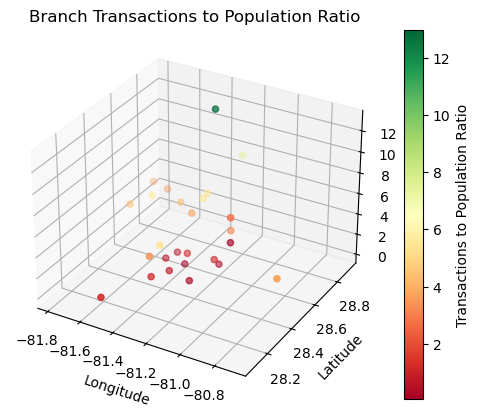

In [137]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates and ratio
x = final_df['Longitude'].astype(float)  # Longitude
y = final_df['Latitude'].astype(float)   # Latitude
z = final_df['Transactions_to_Population_Ratio']  # Transactions to population ratio

# Scatter plot
scatter = ax.scatter(x, y, z, c=z, cmap='RdYlGn', marker='o')

# Add color bar which maps values to colors
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Transactions to Population Ratio')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions/Population Ratio')
ax.set_title('Branch Transactions to Population Ratio')

# Show the plot
plt.show()


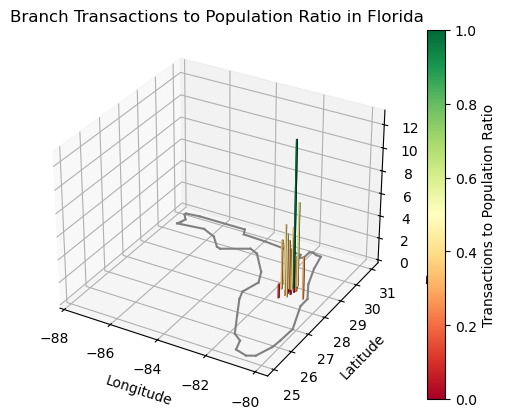

In [138]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geopandas as gpd
import numpy as np

# Convert 'Latitude' and 'Longitude' to numeric, handling non-numeric values
final_df['Latitude'] = pd.to_numeric(final_df['Latitude'], errors='coerce')
final_df['Longitude'] = pd.to_numeric(final_df['Longitude'], errors='coerce')


# Load the US states shapefile
states = gpd.read_file('Florida_shape/ne_110m_admin_1_states_provinces.shp')
florida = states[states['name'] == 'Florida']

# Extract the boundary coordinates of Florida
florida_boundary = florida.geometry.values[0].exterior.coords.xy
florida_x = list(florida_boundary[0])
florida_y = list(florida_boundary[1])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the shape of Florida
for i in range(len(florida_x) - 1):
    ax.plot([florida_x[i], florida_x[i+1]], [florida_y[i], florida_y[i+1]], [0, 0], color='gray')

# Extract coordinates and ratio from final_df
x = final_df['Longitude'].astype(float)  # Longitude
y = final_df['Latitude'].astype(float)   # Latitude
z = final_df['Transactions_to_Population_Ratio']  # Transactions to population ratio

# Normalize the z values for color mapping
z_normalized = (z - z.min()) / (z.max() - z.min())

# Plot pillars for branches
for i in range(len(x)):
    ax.bar3d(x[i], y[i], 0, 0.05, 0.05, z[i], color=plt.cm.RdYlGn(z_normalized[i]))

# Add color bar (optional)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlGn'), ax=ax)
cbar.set_label('Transactions to Population Ratio')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions/Population Ratio')
ax.set_title('Branch Transactions to Population Ratio in Florida')

# Show the plot
plt.show()


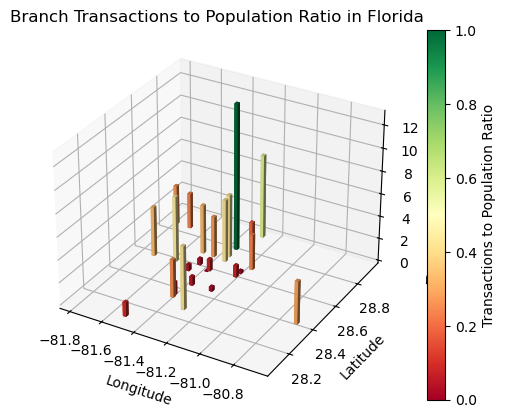

Address: 1000 Primera Blvd, Lake Mary, FL 32746, Transactions to Population Ratio: 12.97
Address: 920 Saxon Blvd, Orange City, FL 32763, Transactions to Population Ratio: 7.43
Address: 950 9th St, Winter Garden, FL 34787, Transactions to Population Ratio: 5.82
Address: 3335 13th St, Saint Cloud, FL 34769, Transactions to Population Ratio: 5.60
Address: 901 E State Road 434, Longwood, FL 32750, Transactions to Population Ratio: 5.57
Address: 215 Oxford Rd, Fern Park, FL 32730, Transactions to Population Ratio: 5.52
Address: 2390 E Highway 50, Clermont, FL 34711, Transactions to Population Ratio: 4.40
Address: 847 S Orange Blossom Trail, Apopka, FL 32703, Transactions to Population Ratio: 4.33
Address: 1380 N Courtenay Pkwy, Merritt Island, FL 32953, Transactions to Population Ratio: 3.77
Address: 855 S State Road 434, Forest City, FL 32714, Transactions to Population Ratio: 3.61
Address: 8040 US Highway 441, Leesburg, FL 34788, Transactions to Population Ratio: 3.52
Address: 708 E Vine 

In [139]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates and ratio from final_df
x = final_df['Longitude'].astype(float)  # Longitude
y = final_df['Latitude'].astype(float)   # Latitude
z = final_df['Transactions_to_Population_Ratio']  # Transactions to population ratio

# Normalize the z values for color mapping
z_normalized = (z - z.min()) / (z.max() - z.min())

# Plot pillars for branches
for i in range(len(x)):
    ax.bar3d(x[i], y[i], 0, 0.02, 0.02, z[i], color=plt.cm.RdYlGn(z_normalized[i]))

# Add color bar (optional)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlGn'), ax=ax)
cbar.set_label('Transactions to Population Ratio')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions/Population Ratio')
ax.set_title('Branch Transactions to Population Ratio in Florida')

# Show the plot
plt.show()

# Sorting the DataFrame by 'Transactions_to_Population_Ratio' in descending order
sorted_df = final_df.sort_values(by='Transactions_to_Population_Ratio', ascending=False)

# Loop through each row in the sorted_df and print the address and ratio
for index, row in sorted_df.iterrows():
    address = row['Address']  # Assuming 'Address' is a column in final_df
    ratio = row['Transactions_to_Population_Ratio']
    print(f"Address: {address}, Transactions to Population Ratio: {ratio:.2f}")

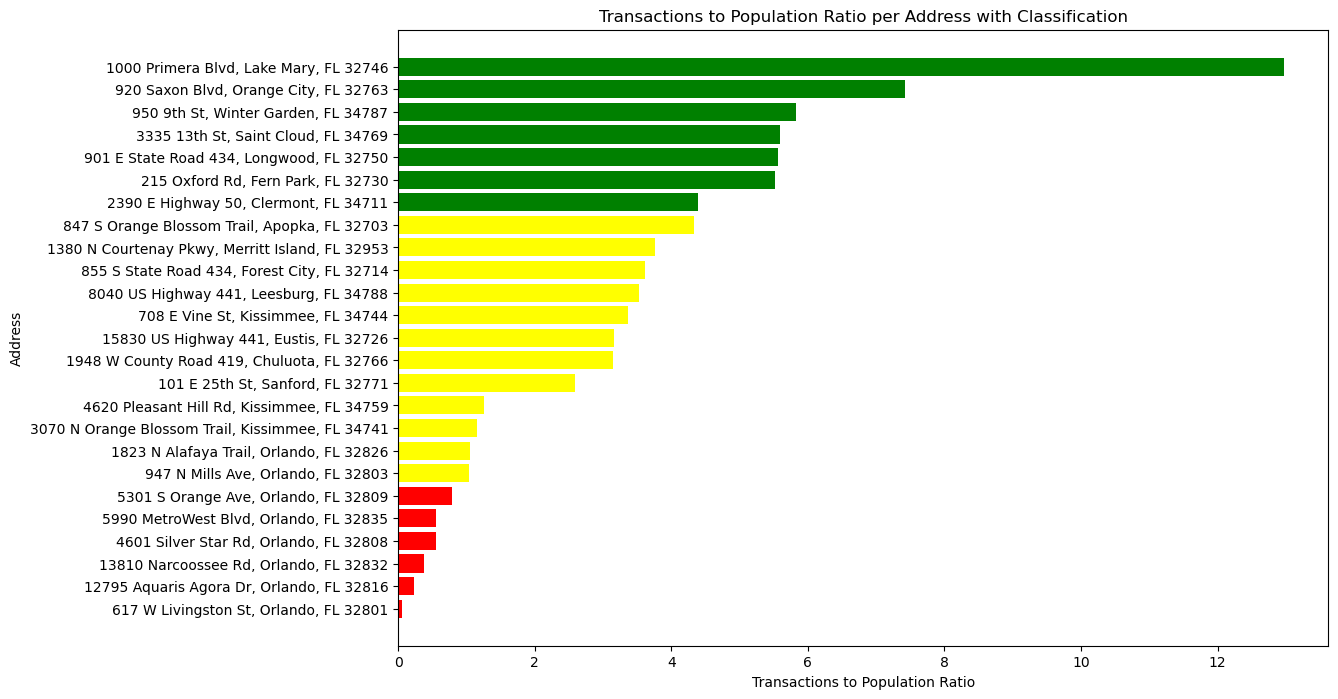

In [140]:
# Define classification thresholds
final_df = final_df.drop_duplicates(subset='Address', keep='first')
import matplotlib.pyplot as plt

# Define classification thresholds based on Transactions_to_Population_Ratio
high_threshold = final_df['Transactions_to_Population_Ratio'].quantile(0.75)  # top 25%
medium_threshold = final_df['Transactions_to_Population_Ratio'].quantile(0.25)  # bottom 25%

# Classify addresses
final_df['Classification'] = 'Low'
final_df.loc[final_df['Transactions_to_Population_Ratio'] >= medium_threshold, 'Classification'] = 'Medium'
final_df.loc[final_df['Transactions_to_Population_Ratio'] >= high_threshold, 'Classification'] = 'High'

# Sort final_df by 'Transactions_to_Population_Ratio' in descending order
sorted_final_df = final_df.sort_values(by='Transactions_to_Population_Ratio', ascending=False)

# Visualize the classified data
colors = {'Low': 'red', 'Medium': 'yellow', 'High': 'green'}
plt.figure(figsize=(12, 8))
plt.barh(sorted_final_df['Address'], sorted_final_df['Transactions_to_Population_Ratio'], color=[colors[cls] for cls in sorted_final_df['Classification']])
plt.title('Transactions to Population Ratio per Address with Classification')
plt.xlabel('Transactions to Population Ratio')
plt.ylabel('Address')
plt.gca().invert_yaxis()  # Invert the y-axis to show highest at the top
plt.show()



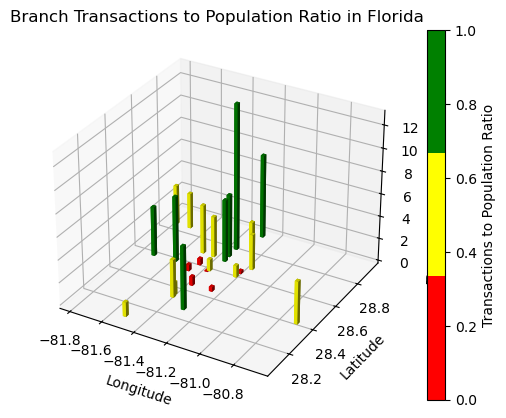

Address: 1000 Primera Blvd, Lake Mary, FL 32746, Transactions to Population Ratio: 12.97
Address: 920 Saxon Blvd, Orange City, FL 32763, Transactions to Population Ratio: 7.43
Address: 950 9th St, Winter Garden, FL 34787, Transactions to Population Ratio: 5.82
Address: 3335 13th St, Saint Cloud, FL 34769, Transactions to Population Ratio: 5.60
Address: 901 E State Road 434, Longwood, FL 32750, Transactions to Population Ratio: 5.57
Address: 215 Oxford Rd, Fern Park, FL 32730, Transactions to Population Ratio: 5.52
Address: 2390 E Highway 50, Clermont, FL 34711, Transactions to Population Ratio: 4.40
Address: 847 S Orange Blossom Trail, Apopka, FL 32703, Transactions to Population Ratio: 4.33
Address: 1380 N Courtenay Pkwy, Merritt Island, FL 32953, Transactions to Population Ratio: 3.77
Address: 855 S State Road 434, Forest City, FL 32714, Transactions to Population Ratio: 3.61
Address: 8040 US Highway 441, Leesburg, FL 34788, Transactions to Population Ratio: 3.52
Address: 708 E Vine 

In [141]:
# Define classification thresholds
high_threshold = final_df['Transactions_to_Population_Ratio'].quantile(0.75)  # top 25%
medium_threshold = final_df['Transactions_to_Population_Ratio'].quantile(0.25)  # bottom 25%

# Function to determine color based on ratio
def get_color(ratio):
    if ratio >= high_threshold:
        return 'green'  # High ratio
    elif ratio >= medium_threshold:
        return 'yellow'  # Medium ratio
    else:
        return 'red'  # Low ratio

# Apply color based on the ratio
colors = [get_color(ratio) for ratio in z]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot pillars for branches with color based on thresholds
for i in range(len(x)):
    ax.bar3d(x[i], y[i], 0, 0.02, 0.02, z[i], color=colors[i])

# Add color bar (optional)
# Create a custom color map for the color bar
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'yellow', 'green'])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax)
cbar.set_label('Transactions to Population Ratio')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions/Population Ratio')
ax.set_title('Branch Transactions to Population Ratio in Florida')

# Show the plot
plt.show()

# Sorting the DataFrame by 'Transactions_to_Population_Ratio' in descending order
sorted_df = final_df.sort_values(by='Transactions_to_Population_Ratio', ascending=False)

# Loop through each row in the sorted_df and print the address and ratio
for index, row in sorted_df.iterrows():
    address = row['Address']  # Assuming 'Address' is a column in final_df
    ratio = row['Transactions_to_Population_Ratio']
    print(f"Address: {address}, Transactions to Population Ratio: {ratio:.2f}")


In [142]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

high_threshold = final_df['Transactions_to_Population_Ratio'].quantile(0.75)  # top 25%
medium_threshold = final_df['Transactions_to_Population_Ratio'].quantile(0.25)  # bottom 25%

def get_category(ratio):
    if ratio >= high_threshold:
        return 'High'  # High ratio
    elif ratio >= medium_threshold:
        return 'Medium'  # Medium ratio
    else:
        return 'Low'  # Low ratio

# Apply category based on the ratio
final_df['Transaction_Category'] = final_df['Transactions_to_Population_Ratio'].apply(get_category)

# SVM Classifier Implementation
X = final_df[['Latitude', 'Longitude']]
y = final_df['Transaction_Category']  # Categorized target variable

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initializing and training the SVM classifier
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


              precision    recall  f1-score   support

        High       0.00      0.00      0.00         2
         Low       0.00      0.00      0.00         1
      Medium       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.13      0.33      0.19         5
weighted avg       0.16      0.40      0.23         5

Accuracy: 0.4


c:\Users\perez\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

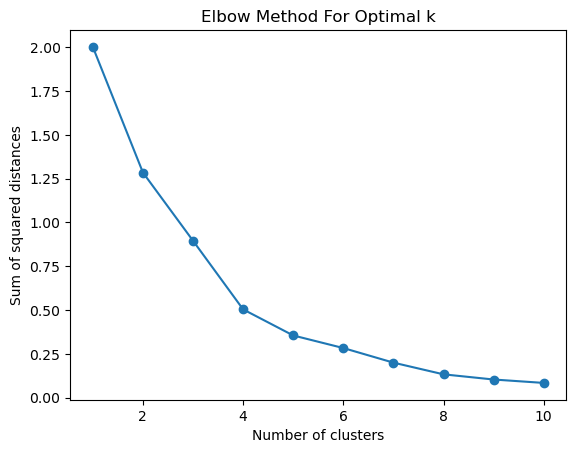

In [143]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
X = final_df[['Latitude', 'Longitude']]

# Calculating the sum of squared distances
sse = []
for k in range(1, 11):  # Trying different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    sse.append(kmeans.inertia_)

# Plotting the results
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [144]:
# Prepare new city data
new_cities_coords = pd.DataFrame([
    {'City': 'Ocoee', 'Latitude': 28.5694468, 'Longitude': -81.5441944},
    {'City': 'Winter Park', 'Latitude': 28.5977707, 'Longitude': -81.3510264},
    {'City': 'Maitland', 'Latitude': 28.6275253, 'Longitude': -81.3656419},
])

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X)

# Assigning new points to clusters
new_cities_coords['Cluster'] = kmeans.predict(new_cities_coords[['Latitude', 'Longitude']])

# Estimating transaction ratio for new points
cluster_means = final_df.groupby(kmeans.labels_)['Transactions_to_Population_Ratio'].mean()
new_cities_coords['Estimated_Ratio'] = new_cities_coords['Cluster'].map(cluster_means)

# Output the estimated ratios
for index, row in new_cities_coords.iterrows():
    city = row['City']
    estimated_ratio = row['Estimated_Ratio']
    print(f"{city}: Estimated Ratio = {estimated_ratio:.4f}")


c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Ocoee: Estimated Ratio = 4.2243
Winter Park: Estimated Ratio = 3.4764
Maitland: Estimated Ratio = 3.4764


c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



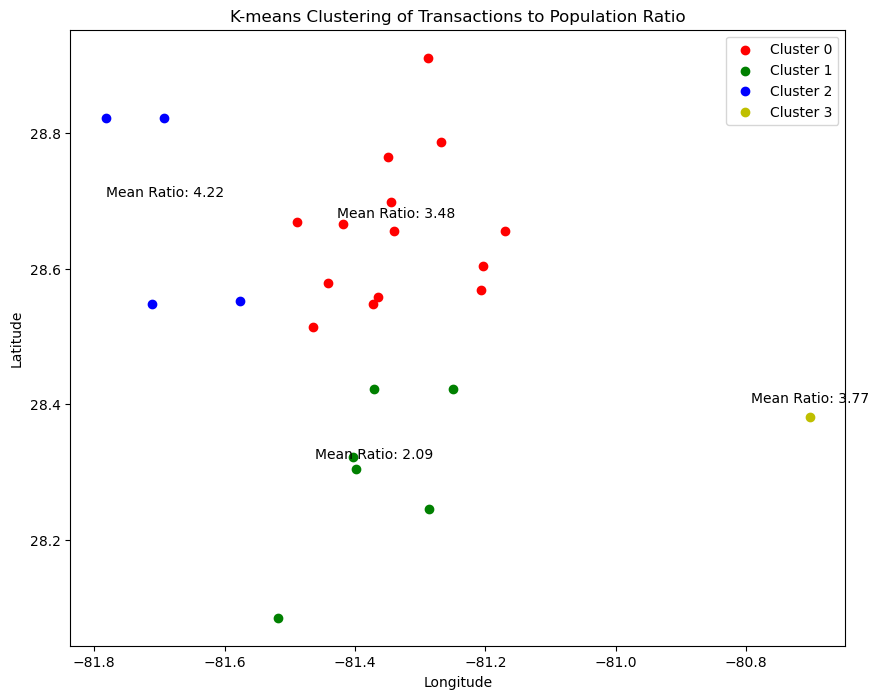

In [145]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42).fit(final_df[['Latitude', 'Longitude']])
final_df['Cluster'] = kmeans.labels_
cluster_means = final_df.groupby('Cluster')['Transactions_to_Population_Ratio'].mean().to_dict()

# Define colors for each cluster
colors = ['r', 'g', 'b', 'y']  # Add more colors if you have more clusters

# Create a 2D plot
plt.figure(figsize=(10, 8))

# Plot each data point with color based on their cluster assignment
for cluster in range(4):
    cluster_data = final_df[final_df['Cluster'] == cluster]
    plt.scatter(cluster_data['Longitude'], cluster_data['Latitude'], c=colors[cluster], label=f'Cluster {cluster}')

# Annotate the mean ratio for each cluster
for cluster, mean_ratio in cluster_means.items():
    # Get the centroid of the cluster for annotation
    centroid = kmeans.cluster_centers_[cluster]
    plt.annotate(f'Mean Ratio: {mean_ratio:.2f}', (centroid[1], centroid[0]), textcoords="offset points", xytext=(0,10), ha='center')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Transactions to Population Ratio')
plt.legend()
plt.show()


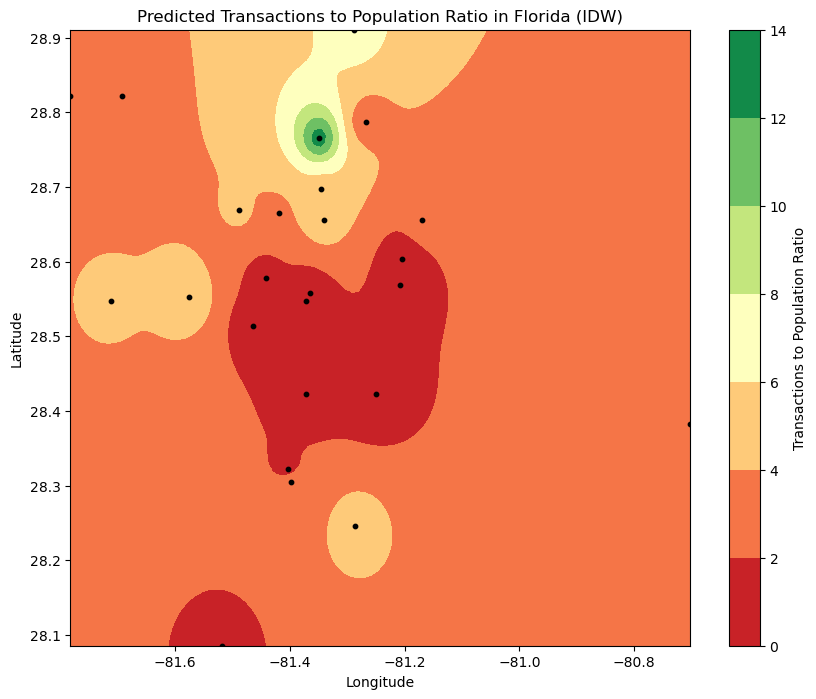

In [146]:
import numpy as np
import matplotlib.pyplot as plt

def inverse_distance_weighting(x, y, z, xi, yi, power=2):
    # The power parameter determines the weight decay with distance
    zi = np.zeros_like(xi)
    for i in range(len(xi)):
        # Calculate the inverse distance weight for each known data point
        distances = np.sqrt((x - xi[i])**2 + (y - yi[i])**2)
        if np.any(distances == 0):
            # If the point is exactly at a known point, take that value
            zi[i] = z[np.argmin(distances)]
        else:
            weights = 1 / distances**power
            zi[i] = np.sum(weights * z) / np.sum(weights)
    return zi

# Create a grid of points where you want to estimate values
grid_x, grid_y = np.meshgrid(
    np.linspace(final_df['Longitude'].min(), final_df['Longitude'].max(), 100),
    np.linspace(final_df['Latitude'].min(), final_df['Latitude'].max(), 100)
)

# Apply IDW to the grid points using the known data points
predicted_ratios = inverse_distance_weighting(
    final_df['Longitude'].values,
    final_df['Latitude'].values,
    final_df['Transactions_to_Population_Ratio'].values,
    grid_x.ravel(),
    grid_y.ravel(),
    power=2 
)

# Plot the predicted ratios as a heatmap
plt.figure(figsize=(10, 8))
plt.contourf(grid_x, grid_y, predicted_ratios.reshape(grid_x.shape), cmap='RdYlGn')
plt.colorbar(label='Transactions to Population Ratio')
plt.scatter(final_df['Longitude'], final_df['Latitude'], c='black', s=10) # Plot the known points
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Transactions to Population Ratio in Florida (IDW)')
plt.show()


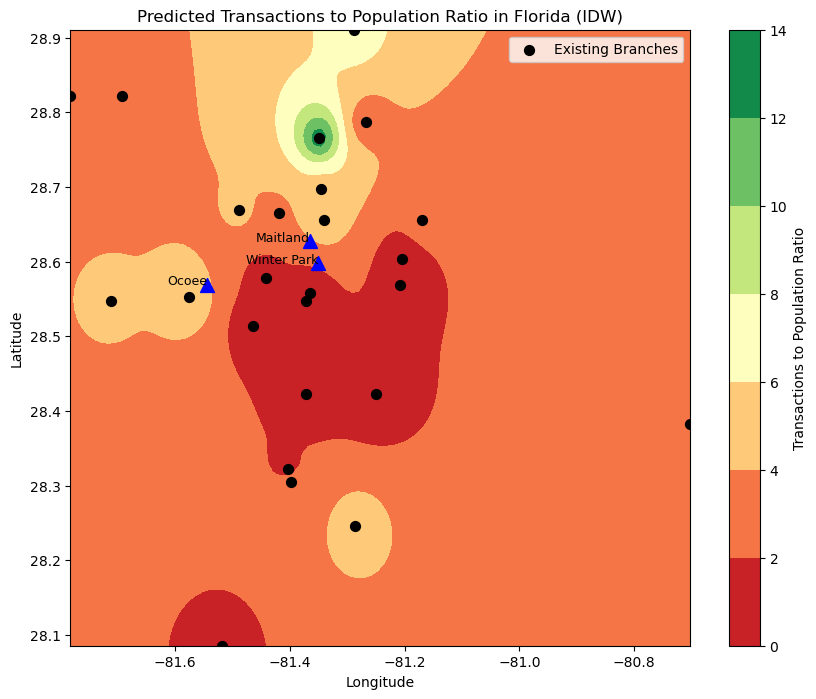

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Function for Inverse Distance Weighting
def inverse_distance_weighting(x, y, z, xi, yi, power=2):
    zi = np.zeros_like(xi)
    for i in range(len(xi)):
        distances = np.sqrt((x - xi[i])**2 + (y - yi[i])**2)
        if np.any(distances == 0):
            zi[i] = z[np.argmin(distances)]
        else:
            weights = 1 / distances**power
            zi[i] = np.sum(weights * z) / np.sum(weights)
    return zi

# Create a grid of points for the heatmap
grid_x, grid_y = np.meshgrid(
    np.linspace(final_df['Longitude'].min(), final_df['Longitude'].max(), 100),
    np.linspace(final_df['Latitude'].min(), final_df['Latitude'].max(), 100)
)

# Apply IDW to the grid points
predicted_ratios = inverse_distance_weighting(
    final_df['Longitude'].values,
    final_df['Latitude'].values,
    final_df['Transactions_to_Population_Ratio'].values,
    grid_x.ravel(),
    grid_y.ravel(),
    power=2
)

# Prepare new city data
new_cities_coords = pd.DataFrame([
    {'City': 'Ocoee', 'Latitude': 28.5694468, 'Longitude': -81.5441944},
    {'City': 'Winter Park', 'Latitude': 28.5977707, 'Longitude': -81.3510264},
    {'City': 'Maitland', 'Latitude': 28.6275253, 'Longitude': -81.3656419},
])

# Predict ratios using KNN
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(final_df[['Latitude', 'Longitude']], final_df['Transactions_to_Population_Ratio'])
new_cities_coords['Predicted_Ratio'] = knn.predict(new_cities_coords[['Latitude', 'Longitude']])

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.contourf(grid_x, grid_y, predicted_ratios.reshape(grid_x.shape), cmap='RdYlGn')
plt.colorbar(label='Transactions to Population Ratio')

# Plot known points (existing branches)
plt.scatter(final_df['Longitude'], final_df['Latitude'], c='black', s=50, label='Existing Branches')

# Plot new city points with labels
for i, row in new_cities_coords.iterrows():
    plt.scatter(row['Longitude'], row['Latitude'], c='blue', s=100, marker='^')
    plt.text(row['Longitude'], row['Latitude'], row['City'], fontsize=9, ha='right')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Transactions to Population Ratio in Florida (IDW)')
plt.legend()
plt.show()


In [148]:
import requests

def get_coordinates(city_name):
    formatted_name = city_name.replace(' ', '+') + ',+Florida'
    url = f"https://nominatim.openstreetmap.org/search?q={formatted_name}&format=json"
    response = requests.get(url)
    data = response.json()
    if data:
        latitude = data[0]['lat']
        longitude = data[0]['lon']
        return latitude, longitude
    else:
        return 'No data', 'No data'

cities_for_testing = ['Ocoee' ,'Winter Park', 'Maitland']
for city in cities_for_testing:
    latitude, longitude = get_coordinates(city)
    print(f"The coordinates for {city} City are Latitude: {latitude} and Longitude: {longitude}")



The coordinates for Ocoee City are Latitude: 28.5694468 and Longitude: -81.5441944
The coordinates for Winter Park City are Latitude: 28.5977707 and Longitude: -81.3510264
The coordinates for Maitland City are Latitude: 28.6275253 and Longitude: -81.3656419


In [149]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data into features and target variable
X = final_df[['Latitude', 'Longitude']]
y = final_df['Transactions_to_Population_Ratio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the KNN model
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train, y_train)

# Predict the ratios for the test data
y_pred = knn.predict(X_test)

# Calculate the Mean Squared Error and R-squared values
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 14.532186274727422
R-squared: 0.20885828043714294


In [150]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

X_train = final_df[['Latitude', 'Longitude']]
y_train = final_df['Transactions_to_Population_Ratio']

# Initialize and train the KNN model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# New cities coordinates as DataFrame with column names matching X_train
new_cities_coords = pd.DataFrame([
    {'City': 'Ocoee', 'Latitude': 28.5694468, 'Longitude': -81.5441944}, # Orange
    {'City': 'Winter Springs', 'Latitude': 28.6987064, 'Longitude': -81.3054759}, # Seminole
    {'City': 'Groveland', 'Latitude': 28.5602149, 'Longitude': -81.8561226}, # Lake
    {'City': 'Deltona', 'Latitude': 28.9005446, 'Longitude': -81.2636738}, # Volusia
    {'City': 'Lakeland', 'Latitude': 28.0394654, 'Longitude': -81.9498042}, # Polk
    {'City': 'Palm Bay', 'Latitude': 27.9946969, 'Longitude': -80.6366144} # Brevard
])

# Predict the ratio for new cities
new_cities_coords['Predicted_Ratio'] = knn.predict(new_cities_coords[['Latitude', 'Longitude']])

# Define thresholds for classification
thresholds = {'Low': 0.25, 'Medium': 0.5, 'High': 0.75}

# Classify the predicted ratios
new_cities_coords['Classification'] = [
    'High' if r >= thresholds['High'] else 'Medium' if r >= thresholds['Medium'] else 'Low'
    for r in new_cities_coords['Predicted_Ratio']
]

# Output results
for index, row in new_cities_coords.iterrows():
    city = row['City']
    ratio = row['Predicted_Ratio']
    classification = row['Classification']
    print(f"{city}: Ratio = {ratio:.4f}, Classification = {classification}")


Ocoee: Ratio = 2.9757, Classification = High
Winter Springs: Ratio = 6.0519, Classification = High
Groveland: Ratio = 4.2451, Classification = High
Deltona: Ratio = 6.8150, Classification = High
Lakeland: Ratio = 3.1977, Classification = High
Palm Bay: Ratio = 2.8325, Classification = High


In [151]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

X_train = final_df[['Latitude', 'Longitude']]
y_train = final_df['Transactions_to_Population_Ratio']

# Initialize and train the KNN model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# New cities coordinates as DataFrame with column names matching X_train
new_cities_coords = pd.DataFrame([
    {'City': 'Ocoee', 'Latitude': 28.5694468 , 'Longitude': -81.5441944}, # Orange
    {'City': 'Winter Park', 'Latitude': 28.5977707 , 'Longitude': -81.3510264}, # Orange
    {'City': 'Maitland', 'Latitude': 28.6275253 , 'Longitude': -81.3656419}, # Orange

])

# Predict the ratio for new cities
new_cities_coords['Predicted_Ratio'] = knn.predict(new_cities_coords[['Latitude', 'Longitude']])

# Define thresholds for classification
thresholds = {'Low': 0.25, 'Medium': 0.5, 'High': 0.75}

# Classify the predicted ratios
new_cities_coords['Classification'] = [
    'High' if r >= thresholds['High'] else 'Medium' if r >= thresholds['Medium'] else 'Low'
    for r in new_cities_coords['Predicted_Ratio']
]

# Output results
for index, row in new_cities_coords.iterrows():
    city = row['City']
    ratio = row['Predicted_Ratio']
    classification = row['Classification']
    print(f"{city}: Ratio = {ratio:.4f}, Classification = {classification}")

Ocoee: Ratio = 2.9757, Classification = High
Winter Park: Ratio = 2.1582, Classification = High
Maitland: Ratio = 3.1599, Classification = High


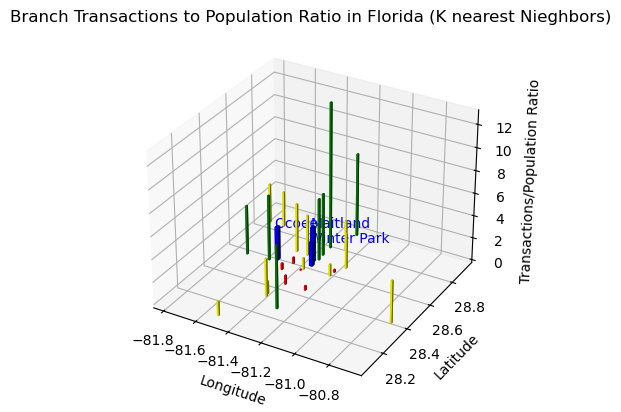

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a function to categorize the ratio
def get_color(ratio):
    if ratio >= high_threshold:
        return 'green'
    elif ratio >= medium_threshold:
        return 'yellow'
    else:
        return 'red'

# Add new cities coordinates
new_cities_coords = pd.DataFrame([
    {'City': 'Ocoee', 'Latitude': 28.5694468 , 'Longitude': -81.5441944, 'Ratio': 2.9757}, # Orange
    {'City': 'Winter Park', 'Latitude': 28.5977707 , 'Longitude': -81.3510264, 'Ratio': 2.1582}, # Orange
    {'City': 'Maitland', 'Latitude': 28.6275253 , 'Longitude': -81.3656419, 'Ratio': 3.1599}, # Orange
], index=['Ocoee', 'Winter Park', 'Maitland'])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot existing branches
for i in range(len(final_df)):
    x = final_df['Longitude'].iloc[i]
    y = final_df['Latitude'].iloc[i]
    z = final_df['Transactions_to_Population_Ratio'].iloc[i]
    color = get_color(z)
    ax.bar3d(x, y, 0, 0.01, 0.01, z, color=color)

# Plot new cities as blue pillars
for city, row in new_cities_coords.iterrows():
    x, y, z = row['Longitude'], row['Latitude'], row['Ratio']
    ax.bar3d(x, y, 0, 0.02, 0.02, z, color='blue')  # Blue pillars for new cities
    ax.text(x, y, z, city, color='blue')  # Label for new city

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions/Population Ratio')
ax.set_title('Branch Transactions to Population Ratio in Florida (K nearest Nieghbors)')

# Show the plot
plt.show()


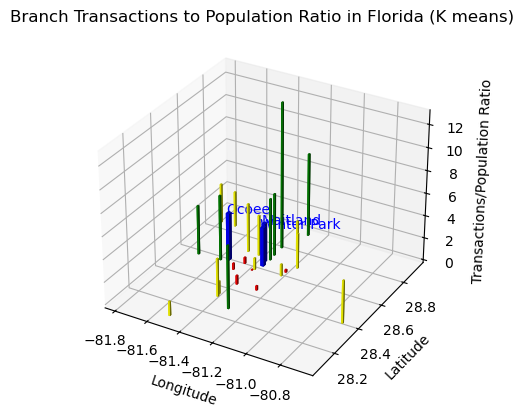

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a function to categorize the ratio
def get_color(ratio):
    if ratio >= high_threshold:
        return 'green'
    elif ratio >= medium_threshold:
        return 'yellow'
    else:
        return 'red'

# Add new cities coordinates
new_cities_coords = pd.DataFrame([
    {'City': 'Ocoee', 'Latitude': 28.5694468 , 'Longitude': -81.5441944, 'Ratio': 4.2243}, # Orange
    {'City': 'Winter Park', 'Latitude': 28.5977707 , 'Longitude': -81.3510264, 'Ratio': 3.4764}, # Orange
    {'City': 'Maitland', 'Latitude': 28.6275253 , 'Longitude': -81.3656419, 'Ratio': 3.4764}, # Orange
], index=['Ocoee', 'Winter Park', 'Maitland'])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot existing branches
for i in range(len(final_df)):
    x = final_df['Longitude'].iloc[i]
    y = final_df['Latitude'].iloc[i]
    z = final_df['Transactions_to_Population_Ratio'].iloc[i]
    color = get_color(z)
    ax.bar3d(x, y, 0, 0.01, 0.01, z, color=color)

# Plot new cities as blue pillars
for city, row in new_cities_coords.iterrows():
    x, y, z = row['Longitude'], row['Latitude'], row['Ratio']
    ax.bar3d(x, y, 0, 0.02, 0.02, z, color='blue')  # Blue pillars for new cities
    ax.text(x, y, z, city, color='blue')  # Label for new city

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions/Population Ratio')
ax.set_title('Branch Transactions to Population Ratio in Florida (K means)')

# Show the plot
plt.show()